<a href="https://colab.research.google.com/github/danosaku/Geracao_lista_de_alimentos/blob/main/GCEMOO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

##### Comparar o mapa de probabilidade conjunta dos cardapios gerados que estao na fronteira zero com os cardapios reais.
##### porcentagem de solucoes na fronteira zero.
##### maiores pontuadores.


#!pip install fireducks

#!pip install keras==2.12.0
#!pip install tensorflow==2.12.0

In [ ]:
#import fireducks.pandas as pd
import pandas as pd

# Geração de cardápios alternativos por meio de informações mútua de pares de componentes de avaliação.

## Passos:


1.   Calcular a infomação mútua dos componentes de avaliação dos cardápios e definição dos pares de componentes de avaliação para o cômputo da probabilidade conjunta.
2.   Divisão dos cardápios em quartis com maior, médio e menor escore.
3.   Cálculo da distribuição de probabilidade conjunta dos pares de componentes de avaliação com os conjuntos de cardápios com maior e menor escore separadamente.
4.   Geração de cardápios sintéticos levando-se em conta as distribuições conjuntas de cada par de componente de avaliação, isto é, dada distribuição de probabilidade de possíveis valores de a e b, onde a e b são componentes de avaliação com valores entre [0,5], são considerados candidatos valores de a e b se a probabilidade P(a,b)>0.

Duas abordagens foram testadas:


*   Alimentos escolhidos com probabilidade p de realizar troca de alimentos caso um componente já tenha sido escolhido. Alimentos redundantes que foram escolhidos em componentes de avaliação diferentes foram removidos. A pontuação dos componentes de avaliação foram revisadas para corrigir os alimentos que pontuam em mais de 1 componente de avaliação.

*   Escolha de alimentos levando-se em conta também o escore médio.

Limitações.

A probabilidade conjunta apresenta apenas a distribuição de pontos nos cardápios sem relacionar os escores. Por exemplo, a compatibilidade de horário possui cerca de 90 % dos cardápios considerados incopatíveis com o horário, logo, haverá muitos cardápios com escore alto que são incompatíveis com o horário. Então o método de seleção tenderá a recomendar tal componente como incompatível, mesmo sendo penalizado pela incompatibilidade de horário.









# 1 - Instalando e Importando Bibliotecas


### Pandas e Numpy

In [ ]:
#import pandas as pd
import numpy as np
from math import fabs

### Dataset

# 2 - Baixar planilhas e descompactá-las

In [ ]:
#!pip install gdown==4.6.0
import os
if not os.path.isfile('/content/IQCAE_R_corrigido_27_mar.zip'):
  !gdown --id 1KyQYag8NDBxfdSuaYHkfW3TzObkiGdol  #IQCAE_R_24novCompleto.zip
#file_id = '1KyQYag8NDBxfdSuaYHkfW3TzObkiGdol'
  !unzip IQCAE_R_corrigido_27_mar.zip
#!unzip /content/drive/MyDrive/planilha_nutricao/IQCAE_R_corrigido_27_mar.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1KyQYag8NDBxfdSuaYHkfW3TzObkiGdol
To: /content/IQCAE_R_corrigido_27_mar.zip
100% 214k/214k [00:00<00:00, 57.1MB/s]
Archive:  IQCAE_R_corrigido_27_mar.zip
  inflating: IQCAE_R_corrigido_27_mar.xlsx  


Concatena as planilhas

In [ ]:
d = pd.ExcelFile('/content/IQCAE_R_corrigido_27_mar.xlsx')
df = d.parse('Cálculo cardápios', skiprows=2)
ca = d.parse('Dimensões')


In [ ]:

df

ID                    MUN EST 2_HORA  2_TIPO  \
0      1             Rio Branco  AC     NI  lanche   
1      2           Assis Brasil  AC     NI  almoço   
2      3                 Macapá  AP     NI  lanche   
3      4                 Manaus  AM     9h  lanche   
4      5  Presidente Figueiredo  AM    12h  almoço   
..   ...                    ...  ..    ...     ...   
420  421               Cidreira  RS  10h30  almoço   
421  422         Nova Boa Vista  RS     NI  lanche   
422  423              Campo Bom  RS     NI  lanche   
423  424        Flores da Cunha  RS     NI  lanche   
424  425             Rio Grande  RS     NI  almoço   

                                           2_ALIMENTOS  2_1  2_2  2_3  2_4  \
0    Suco de polpa de cupuaçu, leite em pó, biscoit...    0    0    0    1   
1               Macarronada, carne moída, suco, salada    1    0    1    0   
2                     Mingau de fubá, biscoito salgado    1    0    0    0   
3    Leite, achocolatado, biscoito doce de maisena,...    0    0    0    0   
4    Pirarucu guisado com abóbora, baião de dois, f...    1    1    1    1   
..                                                 ...  ...  ...  ...  ...   
420  Arroz, Feijão Preto, Iscas de Carne, Farofa, S...    1    1    1    0   
421                            Pipoca salgada, pêssego    1    0    0    1   
422  Leite com chocolate, pão de milho com doce de ...    1    0    0    1   
423  Café com leite, biscoito de gergelim com doce ...    0    0    0    1   
424  Arroz, Feijão, Frango xadrez, Sal. Tomate, Lar...    1    1    1    1   

     ...  6_7  6_8  6_9  6_10  6_11  6_12  6_13  6_14  6_T  TOTAL_S  
0    ...    0    0    1     0     0     0     0     0   10       46  
1    ...    0    0    1     0     0     0     1     0    6       27  
2    ...    0    0    1     0     0     0     0     0   10       16  
3    ...    0    0    0     0     1     0     0     0   12       26  
4    ...    1    0    0     0     0     0     0     1   12       56  
..   ...  ...  ...  ...   ...   ...   ...   ...   ...  ...      ...  
420  ...    0    0    1     0     0     1     0     0    8       37  
421  ...    0    1    0     0     0     0     0     0    2       27  
422  ...    1    0    0     0     1     0     0     0    4       35  
423  ...    0    0    0     0     0     0     0     0   10       34  
424  ...    0    1    0     0     0     1     0     0    4       58  

[425 rows x 94 columns]

Ordenação dos cardápios de acordo com o escore

In [ ]:
df_sorted = df.sort_values(by=['TOTAL_S'], ascending=False)
df_sorted.head(5)

ID                            MUN EST 2_HORA  2_TIPO  \
266  267                       Ilhabela  SP     NI  almoço   
361  362                   Major Vieira  SC     NI  almoço   
319  320  São José do Vale do Rio Preto  RJ     NI  almoço   
229  230                          Tietê  SP     NI  almoço   
211  212                      Nova Lima  MG  11h30  almoço   

                                           2_ALIMENTOS  2_1  2_2  2_3  2_4  \
266  Ovo cozido ao molho com seleta de legumes, arr...    1    1    1    1   
361  ARROZ, FEIJÃO, FRANGO ACEBOLADO, CREME DE MILH...    1    1    1    1   
319  Bolo de batata com peito de frango desfiado, A...    1    1    1    0   
229  Arroz, feijão, ovo mexido com cenoura e cheiro...    1    1    1    1   
211  Arroz, feijão, macarrão parafuso com molho de ...    1    1    1    1   

     ...  6_7  6_8  6_9  6_10  6_11  6_12  6_13  6_14  6_T  TOTAL_S  
266  ...    0    0    1     0     0     0     0     0   14       78  
361  ...    0    1    0     0     0     1     0     0   14       76  
319  ...    0    0    0     0     0     1     0     0   16       75  
229  ...    0    0    0     0     0     1     0     0   14       74  
211  ...    0    0    0     0     1     1     0     1   14       74  

[5 rows x 94 columns]

# Implementação de redes neurais

# 3 - Carrega a lista de alimentos dos componentes de avaliação (ILAC)

In [ ]:
import re
def ExtractListOfEvaluationComponents(ca):
  index = [1,2,3,4,5,6,7,8,9,10,11]
  name_list = ca.columns.values.tolist()
  componentes_de_avaliacao = {}
  ## componentes de 1 a 11##
  for k in name_list:
    if k in index:
      lista = [i.lstrip().replace('*', '') for i in ca[k][1:].dropna().tolist()]
      new = []
      for l in range(len(lista)):
        lista[l] = lista[l].replace('"','')
        lista[l] = lista[l].replace('moida','moída')
        if (':' in lista[l]):
           lista[l] = lista[l].split(':')[-1]
        if ('/' in lista[l]):
          new = new+ lista[l].split('/')
        elif ('(' in lista[l] or ',' in lista[l]):
           lista[l] = lista[l].replace('(', ',').replace(')', '')
           new = new + lista[l].split(',')
        else:
         new.append(lista[l])
      new = list(set(new))
      componentes_de_avaliacao[k] = new
  for k in componentes_de_avaliacao.keys():
    componentes_de_avaliacao[k] = [i.lstrip().rstrip().lower() for i in componentes_de_avaliacao[k]]
  remove_list = ['ata', 'mari','crem']
  reg2 = [' Norte', ' Nordeste', ' Centroeste', ' Sudeste', ' RegSul']
## componente 12  Alimentos Regionais
  lista2 = []
  lista2.append([i.lstrip().rstrip().replace('*', '') for i in ca[12][2:7].dropna().tolist()])
  lista2.append([i.lstrip().rstrip().replace('*', '') for i in ca[12][8:13].dropna().tolist()])
  lista2.append([i.lstrip().rstrip().replace('*', '') for i in ca[12][14:18].dropna().tolist()])
  lista2.append([i.lstrip().rstrip().replace('*', '') for i in ca[12][19:23].dropna().tolist()])
  lista2.append([i.lstrip().rstrip().replace('*', '') for i in ca[12][24:31].dropna().tolist()])

  new = []
  for l in range(len(lista2)):
    for m in range(len(lista2[l])):
      if (':' in lista2[l][m]):
          lista2[l][m] = lista2[l][m].split(':')[-1]
      lista2[l][m] = lista2[l][m].replace('/', ',')
      lista2[l][m] = lista2[l][m].replace('- ', '-')
      lista2[l][m] = lista2[l][m].replace(' -', '-')
      lista2[l][m] = lista2[l][m].replace(' e ', ', ')
      lista2[l][m] = lista2[l][m].replace('-', ' ')
      if ('(' in lista2[l][m] or ',' in lista2[l][m]):
         lista2[l][m] = lista2[l][m].replace('(', ',').replace(')', '')
         nn = lista2[l][m].split(',')
         nn = [[i.lstrip().rstrip().replace(".", ""), reg2[l]] for i in nn]
         new = new+ nn
      else:
         nn = lista2[l][m].split(',')
         nn = [[i.lstrip().rstrip().replace(".", ""), reg2[l]] for i in nn]
         new = new+ nn

  new = [[i[0].lstrip().rstrip(), i[1]] for i in new if len(i[0])>1 and i[0] not in remove_list]
  new2 = [[i[0].replace("-", " "), i[1]] for i in new]
  for i in new2:
    if i not in new:
      new.append(i)
  componentes_de_avaliacao[12] = new
## componente 13
  #lista = [i.lstrip().rstrip().replace('*', '') for i in ca[12][1:].dropna().tolist()]

  lista2 = []

  lista2.append([i.lstrip().rstrip().replace('*', '') for i in ca[13][2:91].dropna().tolist()])
  lista2.append([i.lstrip().rstrip().replace('*', '') for i in ca['Unnamed: 15'][2:91].dropna().tolist()])


  #lista = [i for i in lista if 'REGI' not in i]
  new = []

  for m in range(len(lista2[0])):
    if (':' in lista2[0][m]):
        lista2[0][m] = lista2[0][m].split(':')[-1]
    lista2[0][m] = lista2[0][m].replace('/', ',')
    lista2[0][m] = lista2[0][m].replace('- ', '-')
    lista2[0][m] = lista2[0][m].replace(' -', '-')
    lista2[0][m] = lista2[0][m].replace(' e ', ', ')
    lista2[0][m] = lista2[0][m].replace('"', '')
    lista2[0][m] = lista2[0][m].replace('-', ' ')

    reg2 = []
    regioes = re.findall(r'\((.*?)\)',lista2[1][m])
    for g in regioes:
      reg2 = reg2+g.split()
    reg2 = [i.replace(",", "") for i in reg2]
    if ('(' in lista2[0][m] or ',' in lista2[0][m]):
       lista2[0][m] = lista2[0][m].replace('(', ',').replace(')', '')
       nn = lista2[0][m].split(',')

       nn = [[i.lstrip().rstrip().replace(".", ""), j] for i in nn for j in reg2]
       new = new+ nn

    else:

       nn = lista2[0][m].split(',')
       nn = [[i.lstrip().rstrip().replace(".", ""), j] for i in nn for j in reg2]
       new = new+ nn
  new = [[i[0].lstrip().rstrip().lower(), i[1]] for i in new if len(i[0])>1 and i[0] not in remove_list]
  new2 = [[i[0].replace("-", " "), i[1]] for i in new]
  for i in new2:
    if i not in new:
      new.append(i)
  componentes_de_avaliacao[13] = new


  return componentes_de_avaliacao

In [ ]:
componentes_de_avaliacao = ExtractListOfEvaluationComponents(ca)
for i in componentes_de_avaliacao.keys():
  print(i, componentes_de_avaliacao[i])

1 ['baião de três', 'baião', 'polenta de fubá orgânico', 'escondidinho diferente de peixe', 'polvilho azedo', 'mugunzá', 'massa a bolonhesa', 'massa ao sugo', 'arroz', 'polenta cremosa ao molho', 'batata doce', 'inhame', 'tropeiro', 'engrossado de fubá', 'beiju', 'tapioca', 'cuscuz', 'penne', 'baião- de- três enriquecido', 'batata', 'mandioca', 'parafuso', 'espaguete', 'tapioca de corte', 'milho', 'tubérculo', 'macarrão de panela', 'pão mandi', 'farinha amarela', 'canjicão', 'maria izabel', 'angu baiano', 'carreteiro', 'angu', 'mangulão', 'galinhadinha', 'polenta', 'arroz carreteiro', 'sopa', 'macaxeira', 'mingau de fubá', 'tutu ralinho', 'lasanha de guisado', 'mandioquinha', 'aletria', 'feijão tropeiro', 'macarronada', 'pirão de carne desfiada', 'risoto de carne', 'risoto', 'mandioquinha salsa refogada', 'baroa', 'macarrão', 'quirera', 'farinha de tapioca', 'arroz da terra', 'pirão de carne guisada', 'nhoque à bolonhesa', 'virado de feijão', 'milho para pipoca', 'creme de milho', 'pur

In [ ]:
def custom_tokenize(item):
      item = item.replace(')', '')
      item = item.replace('moida', 'moída')
      item = item.replace('maça', 'maçã')
      item = item.replace('Maça', 'Maçã')
      item = item.replace('\n', ' ')
      item = item.replace('+', ' ').lower()
      item = item.replace('. ', ',')
      item = item.replace('  ', ' ')
      item = item.replace('+', ',')
      item = item.replace(' - ', ',')
      item = item.replace(' -', '-')
      item = item.replace('- ', '-')
      item = item.replace(' com ', ',')
      item = item.replace(' e ', ', ')
      item = item.replace('\n', ' ')
      item = item.replace(' / ', ', ')
      item = item.replace(' ou ', ', ')
      item = item.replace('*', '')
      item = item.replace(' (',', ')
      item = item.replace(')', '')
      item = item.replace('fruta: ', '')
      item = item.replace(': ',', ')
      item = item.replace('-', ' ')
      #item = re.sub("[\(\[].*?[\)\]]", " ", item)
      item = item.split(',')
      return [x.lstrip().rstrip() for x in item if len(x)>0]

In [ ]:
regiao = {}
regiao['AM'] = ' Norte'
regiao['AP'] = ' Norte'
regiao['AC'] = ' Norte'
regiao['RO'] = ' Norte'
regiao['RR'] = ' Norte'
regiao['TO'] = ' Norte'
regiao['PA'] = ' Norte'
regiao['BA'] = ' Nordeste'
regiao['MA'] = ' Nordeste'
regiao['CE'] = ' Nordeste'
regiao['PB'] = ' Nordeste'
regiao['PE'] = ' Nordeste'
regiao['PI'] = ' Nordeste'
regiao['RN'] = ' Nordeste'
regiao['SE'] = ' Nordeste'
regiao['AL'] = ' Nordeste'
regiao['GO'] = ' Centroeste'
regiao['MT'] = ' Centroeste'
regiao['MS'] = ' Centroeste'
regiao['DF'] = ' Centroeste'
regiao['ES'] = ' Sudeste'
regiao['MG'] = ' Sudeste'
regiao['RJ'] = ' Sudeste'
regiao['SP'] = ' Sudeste'
regiao['PR'] = ' RegSul'
regiao['SC'] = ' RegSul'
regiao['RS'] = ' RegSul'

# Revisa os componentes de avaliação gerados

In [ ]:
def recepi_revision(items,ca, regiao, estado):
  new_fv = np.zeros(14)
  total = 0
  reconhecido = 0

  items_nao_reconhecidos = []
  for subitems in items:
     for i in subitems:
         total+=1
         rr = 0
         for j in ca.keys():
            c = 0
            flag=0
            while( c < len(ca[j]) and flag==0):
               #print(j, isinstance(i, str), isinstance(ca[j][c], str),isinstance(i, list), isinstance(ca[j][c], list) )
               ##if isin isinstance(ca[j][c], list)):
                  if (j==12):
                     if isinstance(i, list):
                       if ca[j][c][0] in i[0] and ca[j][c][1] in i[1]:
                          new_fv[j-1]+=1
                          rr  =1
                          flag = 1
                     else:
                      if regiao is not None:
                        if ca[j][c][0] in i and ca[j][c][1] in regiao:
                          new_fv[j-1]+=1
                          rr  =1
                          flag = 1
                  elif j==13:
                     if isinstance(i, list):
                        if ca[j][c][0] in i[0] and ca[j][c][1] in i[1]  :
                          new_fv[j-1]+=1
                          rr  =1
                          flag = 1
                     else:
                      if estado is not None:
                        if ca[j][c][0] in i and ca[j][c][1] in estado:
                          new_fv[j-1]+=1
                          rr  =1
                          flag = 1
                  else:
                    if ca[j][c] in i:
                      new_fv[j-1]+=1
                      rr  =1
                      flag = 1
                  c+=1
         if rr==1:
          reconhecido+=1
         else:
          items_nao_reconhecidos.append(i)
            #new_fv[i-1]+=1

  return new_fv, reconhecido/total, items_nao_reconhecidos



In [ ]:
def check_recepi(list_of_itens, ca, y, y_t, deactive, reg, est):
  alternatives = []
  conflict = []
  y_t[y_t>5] = 5
  total = 0
  erros1 =0
  erros = 0
  for i in range(y.shape[0]-1):

    if y[i] > y_t[i]:  #
       erros1+=int(y[i] - y_t[i])
       #print(i, y[i], y_t[i], list_of_itens, deactive[i])
       for items in list_of_itens:
          for subitem in items:
             if subitem not in deactive[i]:
               alternatives.append(subitem)

    if y_t[i] > y[i]:
       erros+=int(y_t[i] - y[i])
       for items in list_of_itens:
          for subitem in items:
            if i==11:
               if [subitem, reg] in ca[i+1]:
                  conflict.append(subitem)
            elif i==12:
               if [subitem, est] in ca[i+1]:
                conflict.append(subitem)
            else:
             if subitem in ca[i+1]:
               conflict.append(subitem)
  return alternatives, conflict, (65-erros-erros1)/65



In [ ]:
def find_alternatives(list_of_items, deactive):
   alternativos = []
   for items in list_of_items:
      for subitem in  items:
          if subitem not in deactive:
             alternativos.append(subitem)

   return alternativos


Criar lista de alimentos de cada cardápio separados por componentes de avaliação

# 4 - Extração dos componentes de avaliação

In [ ]:
import glob

arq = []

index = {}
index[0] = [24,38]
index[1] = [42,56]
index[2] = [60,74]
index[3] = [78,92]


y_train = np.array(df_sorted.iloc[:, 6:20].values.tolist())
for i in index:
  aux = np.array(df_sorted.iloc[:, index[i][0]:index[i][1]].values.tolist())
  y_train+=aux
penalty_values = np.array([5,5,5,5,5,5,0,0,2, 1, 3, 5,5,5])
y_train_distribution = y_train.copy()
penalizacao = penalty_values - y_train_distribution
print(penalizacao[:5])
y_train_distribution[y_train_distribution>0]= 1
print(y_train_distribution[:5])
#penalizacao[penalizacao< -3]= 20

y_train_distribution[penalizacao<0]= -1

y_train_distribution[y_train_distribution[:, 10] > 0, 10] = 0
y_train_distribution[y_train_distribution[:, 9] > 0, 9] = 0
print(y_train_distribution[:5])

[[ 0  0  0  0  2  3  0  0  0  1  2  4  4  5]
 [ 0  0  0  0  2  2  0 -2  0  1  2  0  5  5]
 [ 0  0  0  2  0  4  0  0  0  1  3  1  4  5]
 [ 0  0  0  0  2  5  0  0  0  1  3  1  5  5]
 [ 0  0  0  0  2  5  0 -1 -1  1  1  1  5  0]]
[[1 1 1 1 1 1 0 0 1 0 1 1 1 0]
 [1 1 1 1 1 1 0 1 1 0 1 1 0 0]
 [1 1 1 1 1 1 0 0 1 0 0 1 1 0]
 [1 1 1 1 1 0 0 0 1 0 0 1 0 0]
 [1 1 1 1 1 0 0 1 1 0 1 1 0 1]]
[[ 1  1  1  1  1  1  0  0  1  0  0  1  1  0]
 [ 1  1  1  1  1  1  0 -1  1  0  0  1  0  0]
 [ 1  1  1  1  1  1  0  0  1  0  0  1  1  0]
 [ 1  1  1  1  1  0  0  0  1  0  0  1  0  0]
 [ 1  1  1  1  1  0  0 -1 -1  0  0  1  0  1]]


In [ ]:
y_train[:5]

array([[5, 5, 5, 5, 3, 2, 0, 0, 2, 0, 1, 1, 1, 0],
       [5, 5, 5, 5, 3, 3, 0, 2, 2, 0, 1, 5, 0, 0],
       [5, 5, 5, 3, 5, 1, 0, 0, 2, 0, 0, 4, 1, 0],
       [5, 5, 5, 5, 3, 0, 0, 0, 2, 0, 0, 4, 0, 0],
       [5, 5, 5, 5, 3, 0, 0, 1, 3, 0, 2, 4, 0, 5]])

In [ ]:
df_sorted.columns

Index(['ID', 'MUN', 'EST', '2_HORA', '2_TIPO', '2_ALIMENTOS', '2_1', '2_2',
       '2_3', '2_4', '2_5', '2_6', '2_7', '2_8', '2_9', '2_10', '2_11', '2_12',
       '2_13', '2_14', '2_T', '3_HORA', '3_TIPO', '3_ALIMENTOS', '3_1', '3_2',
       '3_3', '3_4', '3_5', '3_6', '3_7', '3_8', '3_9', '3_10', '3_11', '3_12',
       '3_13', '3_14', '3_T', '4_HORA', '4_TIPO', '4_ALIMENTOS', '4_1', '4_2',
       '4_3', '4_4', '4_5', '4_6', '4_7', '4_8', '4_9', '4_10', '4_11', '4_12',
       '4_13', '4_14', '4_T', '5_HORA', '5_TIPO', '5_ALIMENTOS', '5_1', '5_2',
       '5_3', '5_4', '5_5', '5_6', '5_7', '5_8', '5_9', '5_10', '5_11', '5_12',
       '5_13', '5_14', '5_T', '6_HORA', '6_TIPO', '6_ALIMENTOS', '6_1', '6_2',
       '6_3', '6_4', '6_5', '6_6', '6_7', '6_8', '6_9', '6_10', '6_11', '6_12',
       '6_13', '6_14', '6_T', 'TOTAL_S'],
      dtype='object')

In [ ]:
df_custom = df_sorted[['ID', 'EST', '2_1', '2_2',
       '2_3', '2_4', '2_5', '2_6', '2_7', '2_8', '2_9', '2_10', '2_11', '2_12',
       '2_13', '2_14', '2_T',  '3_1', '3_2',
       '3_3', '3_4', '3_5', '3_6', '3_7', '3_8', '3_9', '3_10', '3_11', '3_12',
       '3_13', '3_14', '3_T','4_1', '4_2',
       '4_3', '4_4', '4_5', '4_6', '4_7', '4_8', '4_9', '4_10', '4_11', '4_12',
       '4_13', '4_14', '4_T', '5_1', '5_2',
       '5_3', '5_4', '5_5', '5_6', '5_7', '5_8', '5_9', '5_10', '5_11', '5_12',
       '5_13', '5_14', '5_T', '6_1', '6_2',
       '6_3', '6_4', '6_5', '6_6', '6_7', '6_8', '6_9', '6_10', '6_11', '6_12',
       '6_13', '6_14', '6_T', 'TOTAL_S']]

In [ ]:
df_custom.head(20)

ID EST  2_1  2_2  2_3  2_4  2_5  2_6  2_7  2_8  ...  6_7  6_8  6_9  \
266  267  SP    1    1    1    1    1    0    0    0  ...    0    0    1   
361  362  SC    1    1    1    1    1    1    0    0  ...    0    1    0   
319  320  RJ    1    1    1    0    1    0    0    0  ...    0    0    0   
229  230  SP    1    1    1    1    1    0    0    0  ...    0    0    0   
211  212  MG    1    1    1    1    1    0    0    0  ...    0    0    0   
320  321  RJ    1    1    1    1    0    0    0    0  ...    0    0    1   
250  251  SP    1    1    1    1    1    0    0    0  ...    0    0    0   
293  294  SP    1    1    1    1    1    0    0    0  ...    0    0    0   
317  318  RJ    1    1    1    1    1    0    0    0  ...    0    0    0   
318  319  RJ    1    1    1    1    1    0    0    0  ...    0    0    0   
314  315  RJ    1    1    1    1    0    0    0    0  ...    0    0    1   
322  323  PR    1    1    1    1    1    1    0    0  ...    0    0    0   
226  227  SP    1    1    1    1    0    0    0    0  ...    0    0    0   
214  215  SP    1    1    1    1    1    0    0    0  ...    0    0    0   
217  218  SP    1    1    1    1    1    0    0    0  ...    0    0    0   
233  234  SP    1    0    1    1    1    0    0    0  ...    0    0    1   
292  293  SP    1    1    1    1    1    0    0    0  ...    0    0    1   
365  366  SC    1    1    1    1    1    1    0    0  ...    1    0    1   
208  209  MG    1    1    0    0    1    0    0    0  ...    0    0    1   
170  171  MG    1    1    1    0    1    0    0    0  ...    0    1    0   

     6_10  6_11  6_12  6_13  6_14  6_T  TOTAL_S  
266     0     0     0     0     0   14       78  
361     0     0     1     0     0   14       76  
319     0     0     1     0     0   16       75  
229     0     0     1     0     0   14       74  
211     0     1     1     0     1   14       74  
320     0     0     0     0     0   14       73  
250     0     0     1     0     0   14       72  
293     0     0     0     0     0    8       71  
317     0     0     0     0     0   12       71  
318     0     0     0     0     0   14       70  
314     0     0     0     0     0   14       70  
322     0     0     0     0     0   16       69  
226     0     0     0     0     1   12       69  
214     0     1     1     0     0   14       68  
217     0     1     1     0     0   12       67  
233     0     0     1     0     0   10       67  
292     0     0     0     0     0   12       66  
365     0     0     1     1     0    8       66  
208     0     0     0     1     0   14       66  
170     0     0     0     0     0   12       66  

[20 rows x 78 columns]

In [ ]:
df_custom.to_excel('IQCAE_dataset_T.xlsx')

In [ ]:
target = df_sorted['TOTAL_S'].values.tolist()
target = np.array(target)
maximum = np.max(target)
minimum = np.min(target)
normalized_target = (target-minimum)/(maximum-minimum)

In [ ]:
evaluation = ['alto' for i in range(106)]
for i in range(212):
  evaluation.append('medio')
for i in range(107):
  evaluation.append('baixo')
len(evaluation)

425

Treina um regressor para calcular o score aproximado do IQCAE

In [ ]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression().fit(y_train[50:], normalized_target[50:])
res = regressor.predict(y_train[:50])
res = res*(maximum-minimum) + minimum
print(res, target[:50])

[74.36003166 76.85683474 73.55943751 73.390272   75.42438425 72.86404425
 69.56805221 68.0521793  67.97627637 68.40196747 70.30257986 68.71080402
 65.32100617 70.27044258 65.74912858 65.74583241 65.38078176 63.69287103
 62.70071707 66.51179436 63.61732833 63.99582801 62.18995467 65.06408998
 64.5044217  62.07042072 61.59118434 64.97124737 61.92986082 61.02386993
 61.83251075 63.62357653 61.89128171 63.62357653 62.85440573 62.59562098
 58.91712079 64.10167063 58.69568825 60.81467106 58.50007088 58.0469354
 61.18438992 58.80407733 59.00031924 61.24758396 55.98383931 58.48936321
 57.93450059 62.01969958] [78 76 75 74 74 73 72 71 71 70 70 69 69 68 67 67 66 66 66 66 65 65 65 65
 65 64 64 63 63 63 63 63 63 63 63 62 62 62 61 61 61 61 61 60 60 59 59 59
 59 59]


Cria listas de alimentos agrupados por região

In [ ]:
df_high = df_sorted.copy()
#df_high = df_high[:int(df_high.shape[0]/2)]
alimentos_por_regiao = {' Norte':[], ' Nordeste':[], ' Centroeste':[], ' Sudeste':[], ' RegSul':[]}
estado_high = df_high['EST'].values.tolist()
for i in range(2, 7, 1):  ### Para cada cardápio faça;
   descricoes = df_high[f'{i}_ALIMENTOS'].values.tolist()
   #descricoes = descricoes[:106]
   idx = 0
   for idx in range(len(descricoes)):
      list_of_items = descricoes[idx]
      item = custom_tokenize(list_of_items)
      for subitem in item:
        if subitem not in alimentos_por_regiao[regiao[estado_high[idx]]]:
          alimentos_por_regiao[regiao[estado_high[idx]]].append(subitem)

In [ ]:
def compute_region(alimentos):
  n_por_regiao = {' Norte':0, ' Nordeste':0, ' Centroeste':0, ' Sudeste':0, ' RegSul':0}
  total = 0
  for lista in alimentos:
    for item in lista:
      total+=1
      if isinstance(item, list):
        item = item[0]
      for key in alimentos_por_regiao.keys():
        if item in alimentos_por_regiao[key]:
          n_por_regiao[key]+=1
  for key in n_por_regiao.keys():
    n_por_regiao[key] = n_por_regiao[key]/total
  return n_por_regiao

In [ ]:
estado = df_sorted['EST'].values.tolist()
reg = [regiao[i] for i in estado]
index = {}
index[0] = [6,20]
index[1] = [24,38]
index[2] = [42,56]
index[3] = [60,74]
index[4] = [78,92]
combinations = {}
alimentos_por_componente = {}
## create an empty dict of lists. Each key represent one city
for i in range(len(df_sorted)):
  aux = []

  for j in range(14):
    aux.append([])
  alimentos_por_componente[i] = aux

deactive = []
for i in range(13):
  deactive.append([])
soma = 0
### Gerando lista de alimentos que não pontuam em cada componente, isto é, se a pontuação é zero para o componente de avaliação,
# significa que os alientos da descrição não fazem parte do componente de avaliação

for i in range(2, 7, 1):  ### Para cada cardápio faça;
   descricoes = df_sorted[f'{i}_ALIMENTOS'].values.tolist()
   y = np.array(df_sorted.iloc[:,index[i-2][0]:index[i-2][1]].values.tolist())
   for list_of_items, reg1, est1, alvo in zip(descricoes, reg, estado, y):
      item2 = custom_tokenize(list_of_items) ## Separa a descricao em uma lista de alimentos
      soma+=len(item2)
      for k in range(len(alvo)-1):
        if alvo[k]==0:
         for subitem in item2:
           #if subitem not in deactive:
             if k==11:
               if [subitem, reg1] not in deactive[k]:
                deactive[k].append([subitem, reg1])
             else:
               if k==12:
                 if [subitem, est1] not in deactive[k]:
                   deactive[k].append([subitem, est1])
               else:
                 if subitem not in deactive[k]:
                   deactive[k].append(subitem)


indiceILAC0 = [0 for i in range(len(df_sorted))]
indiceILAC1 = [0 for i in range(len(df_sorted))]
indiceILACC = [0 for i in range(len(df_sorted))]
alimentos_nao_reconhecidos = [[] for i in range(len(df_sorted))]
total_alimentos0 = [0 for i in range(len(df_sorted))]
lista_alimentos_original = [[] for i in range(len(df_sorted))]
total_alimentos1 = [0 for i in range(len(df_sorted))]
total_conflitos = [0 for i in range(len(df_sorted))]
erros = [0 for i in range(len(df_sorted))]
for i in range(2, 7, 1):
   descricoes = df_sorted[f'{i}_ALIMENTOS'].values.tolist()
   y = np.array(df_sorted.iloc[:,index[i-2][0]:index[i-2][1]].values.tolist())
   idx = 0
   for list_of_items, reg1, est1, alvo in zip(descricoes, reg, estado, y):
      item = custom_tokenize(list_of_items)
      partial_list = []
      duplicate = []
      alimentos_nao_reconhecidos[idx] = alimentos_nao_reconhecidos[idx] + item
      for subitem in item:
        if subitem not in duplicate and len(subitem)>2:
           duplicate.append(subitem)
           partial_list.append(subitem)
           for t in range(len(alvo)-1):

             if alvo[t]<=0:
              # total_alimentos0[idx]+=1
               if t==11:
                   if [subitem, reg1] in componentes_de_avaliacao[t+1]:
                     #print('erro1 item ',t+1, subitem, reg1)
                     #erros[idx]+=1
                     alvo[t] -= 1
                    # indiceILAC[idx]+=1
                   else:
                     indiceILAC0[idx]+=1
               else:
                    if t==12:
                      if [subitem,est1] in componentes_de_avaliacao[t+1]:
                         #print('erro2 item ',t+1,  subitem, reg1)
                         #erros[idx]+=1
                         alvo[t] -= 1
                        # indiceILAC[idx]+=1
                      else:
                       indiceILAC0[idx]+=1
                    else:
                       if subitem in componentes_de_avaliacao[t+1]:
                          #print('erro3 item ',t+1, subitem, reg1)
                          #erros[idx]+=1
                          alvo[t] -= 1
                       else:
                          indiceILAC0[idx]+=1
             else:
               flag = 0 ### Caso tenha pontos nos componentes de avaliação, procura se o alimento do cardápio está presente na lista de alimentos do componente.
               for j in componentes_de_avaliacao[t+1]:
                 if t==11:
                   if j[0] in subitem and j[1]==reg1:
                    alvo[t] = 2
                    flag = 1
                 else:
                    if t==12:
                      if j[0] in subitem and j[1]==est1:
                         alvo[t] = 2
                         flag = 1
                    else:

                       if j in subitem:
                         #print(j, subitem)
                         alvo[t] = 2
                         flag = 1
               if flag==1: ## Se encontrou o alimento (flag==1), adiciona na lista de alimentoS.
                #indiceILAC[idx]+=1
                if subitem in alimentos_nao_reconhecidos[idx]:
                   alimentos_nao_reconhecidos[idx].remove(subitem)
                if t==11:
                  alimentos_por_componente[idx][t].append([subitem, reg1])
                else:
                  if t==12:
                    alimentos_por_componente[idx][t].append([subitem, est1])
                  else:
                    alimentos_por_componente[idx][t].append(subitem)
        elif subitem in alimentos_nao_reconhecidos[idx]:
              alimentos_nao_reconhecidos[idx].remove(subitem)
               # indiceILAC[idx]+=1
      if idx not in combinations.keys():
         combinations[idx] = {}
      for t in range(len(alvo)-2):
        for u in range(t+1, len(alvo)-1, 1):
           if len(alimentos_por_componente[idx][t]) < 1:
              for z in range(len(alimentos_por_componente[idx][u])):
                if (t,u) not in combinations[idx].keys():
                  combinations[idx][t,u] = [["", alimentos_por_componente[idx][u][z]]]
                else:
                  combinations[idx][t,u].append(["", alimentos_por_componente[idx][u][z]])
           for v in range(len(alimentos_por_componente[idx][t])):
              if (t,u) not in combinations[idx].keys():
                if (len(alimentos_por_componente[idx][u]))< 1:
                  combinations[idx][t,u] = [[alimentos_por_componente[idx][t][v], ""]]
              else:
                if len(alimentos_por_componente[idx][u])< 1:
                 combinations[idx][t,u].append([alimentos_por_componente[idx][t][v], ""])
              #print(u)
              #print(len(alimentos_por_componente[idx][u]), alimentos_por_componente[idx][u])
              for x in range(len(alimentos_por_componente[idx][u])):
                 if (t,u) not in combinations[idx].keys():
                   combinations[idx][t,u] = [[alimentos_por_componente[idx][t][v], alimentos_por_componente[idx][u][x]]]
                 else:
                    combinations[idx][t,u].append([alimentos_por_componente[idx][t][v], alimentos_por_componente[idx][u][x]])
      lista_conflitos = {}
      for t in range(len(alvo)-1):
         lista_conflitos[t] = []
      for t in range(len(alvo)-1):
         total_alimentos1[idx]+=1
         if alvo[t]==1:
             total_conflitos[idx]+=1
             if t==11:
                for subitem in item:
                   if [subitem, reg1] not in deactive:
                       lista_conflitos[t] = lista_conflitos[t] + [subitem, reg1]
               #alimentos_por_componente[idx][t].append([f'#{t}', reg1])
             else:
              if t==12:
                 for subitem in item:
                   if [subitem, est1] not in deactive:
                       lista_conflitos[t] = lista_conflitos[t]+ [subitem, est1]

                #alimentos_por_componente[idx][t].append([f'#{t}', est1])
              else:
                  for subitem in item:
                   if subitem not in deactive:
                       lista_conflitos[t] = lista_conflitos[t]+[subitem]

         else:
           if alvo[t]<0:
              erros[idx] = erros[idx]+ abs(alvo[t])
           indiceILAC1[idx]+=1
                #print('erro', idx)
                #alimentos_por_componente[idx][t].append(f'#{t}')
      for i in lista_conflitos.keys():
        indiceILACC[idx]+=len(lista_conflitos[i])
      lista_alimentos_original[idx].append(partial_list)
      idx+=1
## IndiceILAC0 = total de itens sem conflito.
## IndiceILAC1 = total_alimentos encontrados
## total_conflitos = não encontrou o alimento
for i in range(len(indiceILAC0)):
   indiceILAC0[i] = (total_alimentos1[i]-erros[i]-total_conflitos[i])/total_alimentos1[i]
for i in range(len(indiceILAC1)):
   indiceILAC1[i] = indiceILAC1[i]/total_alimentos1[i]
   print(i, 'indice ilac0 = ', round(indiceILAC0[i],2),'indice ilac1 = ', round(indiceILAC1[i],2),  'num. alternativos = ', indiceILACC[i], 'num nao encontrados = ',total_conflitos[i], 'conflito (sem pontuação) = ', erros[i])
indiceILAC0 = np.array(indiceILAC0)

q = int(len(df_sorted)/4)
high_score_mean = df_sorted[:q]['TOTAL_S'].mean()  ### media dos escores mais altos

extra_original = []
data = []
ilac_1 = []
excesso_1 = []
reg_norte = []
reg_nordeste = []
reg_centroeste = []
reg_sudeste = []
reg_sul = []
print('dados')
cidade = df_sorted['MUN'].values.tolist()
est = df_sorted['EST'].values.tolist()
ieq = []
idm = []
for i in range(y_train.shape[0]):
#for i in range(106):
   hist = [0 for j in range(6)]
   for j in range(y_train.shape[1]):
      hist[y_train[i,j]] +=1
   new_fv, conf, inr = recepi_revision(lista_alimentos_original[i], componentes_de_avaliacao, reg[i], estado[i])
   new_fv3 = new_fv.copy()
   new_fv3 = new_fv3 - 5
   new_fv3[new_fv3<0] = 0
   excesso = np.sum(new_fv3)
   new_fv[new_fv>5] = 5
   val = y_train[i] - new_fv
   val[val < 0] = 0
   print(i, y_train[i], new_fv, alimentos_nao_reconhecidos[i], np.sum(y_train_distribution[i]))
   alternativos, conflitos, erro = check_recepi(lista_alimentos_original[i], componentes_de_avaliacao, y_train[i], new_fv, deactive, reg[i], estado[i])
   print("status:", len(alternativos), indiceILACC[i], len(conflitos), excesso)
   adjusted_sample = np.maximum(y_train[i], new_fv)
   equilibrio = adjusted_sample.copy()
   penalizacao = penalty_values - equilibrio
   equilibrio[equilibrio>0] = 1
   equilibrio[penalizacao<0] = -1
   #extra_original.append(excesso)
   #data.append([indiceILAC0[i], indiceILACC[i], excesso, lista_alimentos_original[i], 1])
   res = compute_region(lista_alimentos_original[i])
   reg_norte.append(res[' Norte'])
   reg_nordeste.append(res[' Nordeste'])
   reg_centroeste.append(res[' Centroeste'])
   reg_sudeste.append(res[' Sudeste'])
   reg_sul.append(res[' RegSul'])
   data.append([cidade[i], est[i], erro,len(alternativos), excesso, np.sum(y_train_distribution[i]), target[i], hist[0], hist[5], lista_alimentos_original[i], y_train[i], 1, evaluation[i], reg_norte[-1], reg_nordeste[-1],reg_sudeste[-1],reg_sul[-1], reg_centroeste[-1]])
   ilac_1.append(erro)
   idm.append(fabs(target[i] - high_score_mean))
   ieq.append(np.sum(equilibrio))
   excesso_1.append(excesso)


#maximo = max(excesso_1)
#excesso_1 = [i/maximo for i in excesso_1]
df_sorted['IC'] = ilac_1
df_sorted['IEP'] = excesso_1
df_sorted['IE'] = ieq
df_sorted['IDM'] = idm
df_sorted['Reg_Norte'] = reg_norte
df_sorted['Reg_Nordeste'] = reg_nordeste
df_sorted['Reg_Centroeste'] = reg_centroeste
df_sorted['Reg_Sudeste'] = reg_sudeste
df_sorted['Reg_Sul'] = reg_sul


0 indice ilac0 =  1.0 indice ilac1 =  1.0 num. alternativos =  0 num nao encontrados =  0 conflito (sem pontuação) =  0
1 indice ilac0 =  1.0 indice ilac1 =  1.0 num. alternativos =  0 num nao encontrados =  0 conflito (sem pontuação) =  0
2 indice ilac0 =  0.98 indice ilac1 =  1.0 num. alternativos =  0 num nao encontrados =  0 conflito (sem pontuação) =  1
3 indice ilac0 =  1.0 indice ilac1 =  1.0 num. alternativos =  0 num nao encontrados =  0 conflito (sem pontuação) =  0
4 indice ilac0 =  0.97 indice ilac1 =  1.0 num. alternativos =  0 num nao encontrados =  0 conflito (sem pontuação) =  2
5 indice ilac0 =  0.98 indice ilac1 =  1.0 num. alternativos =  0 num nao encontrados =  0 conflito (sem pontuação) =  1
6 indice ilac0 =  1.0 indice ilac1 =  1.0 num. alternativos =  0 num nao encontrados =  0 conflito (sem pontuação) =  0
7 indice ilac0 =  1.0 indice ilac1 =  1.0 num. alternativos =  0 num nao encontrados =  0 conflito (sem pontuação) =  0
8 indice ilac0 =  0.98 indice ilac1 =

In [ ]:
lista_alimentos_original[2]

[['bolo de batata',
  'peito de frango desfiado',
  'arroz',
  'feijão',
  'salada de cenoura',
  'beterraba',
  'azeite',
  'cheiro verde'],
 ['carne refogada',
  'farofa',
  'ovos cozidos',
  'arroz',
  'feijão',
  'repolho refogado'],
 ['coxa de frango refogada',
  'arroz',
  'feijão',
  'suflê de legumes',
  'cenoura',
  'chuchu',
  'vagem',
  'goiaba'],
 ['isca de carne refogada',
  'tutu de feijão',
  'ovos cozidos temperados',
  'azeite',
  'cheiro verde',
  'arroz',
  'couve refogada à mineira',
  'sobremesa',
  'mamão.'],
 ['peito de frango refogado',
  'creme de espinafre',
  'arroz',
  'feijão',
  'salada de tomate',
  'maçã']]

In [ ]:
for i in alimentos_por_componente.keys():
  for j in range(len(alimentos_por_componente[i])):
    if len(alimentos_por_componente[i][j]) <= 0 and y_train[i,j] >0:
       print(i, y_train[i, j], alimentos_por_componente[i][j])


4 5 []
12 5 []
18 1 []
19 1 []
24 1 []
35 5 []
39 5 []
49 1 []
57 5 []
59 5 []
63 4 []
66 5 []
69 2 []
70 1 []
71 5 []
76 2 []
82 1 []
85 5 []
105 1 []
105 5 []
107 1 []
109 2 []
111 5 []
112 2 []
113 5 []
119 1 []
120 1 []
122 1 []
123 1 []
124 1 []
126 1 []
138 1 []
138 2 []
139 2 []
140 1 []
141 1 []
141 2 []
148 1 []
149 2 []
155 1 []
158 2 []
159 2 []
161 5 []
179 2 []
182 1 []
190 2 []
192 2 []
198 3 []
208 3 []
212 2 []
216 2 []
217 2 []
223 2 []
226 3 []
227 3 []
233 1 []
237 2 []
245 1 []
251 2 []
252 2 []
253 1 []
256 3 []
257 2 []
258 2 []
259 2 []
260 2 []
261 1 []
276 1 []
276 1 []
277 3 []
283 2 []
284 2 []
286 1 []
288 2 []
289 2 []
291 2 []
298 2 []
313 2 []
314 1 []
314 2 []
315 1 []
322 1 []
342 2 []
346 3 []
347 2 []
357 2 []
359 1 []
359 2 []
368 2 []
375 3 []
382 3 []
390 1 []
409 2 []
410 4 []
414 1 []
414 3 []


In [ ]:
alimentos_por_componente[0]

[['arroz',
  'arroz',
  'arroz',
  'creme de mandioca',
  'arroz',
  'batata sauté',
  'arroz'],
 ['feijão', 'feijão', 'feijão', 'feijão', 'feijão'],
 ['seleta de legumes',
  'salada mista',
  'abóbora',
  'salada de chicória',
  'berinjela',
  'salada de chuchu',
  'salada de acelga',
  'cenoura',
  'salada de brócolis'],
 ['fruta', 'fruta', 'fruta', 'fruta', 'fruta'],
 ['ovo cozido ao molho', 'frango cozido', 'peixe cozido'],
 ['creme de mandioca', 'strogonoff de carne'],
 [],
 [],
 ['carne moída', 'strogonoff de carne'],
 [],
 ['seleta de legumes'],
 [['berinjela', ' Sudeste']],
 [['creme de mandioca', 'SP']],
 []]

Mostra valores dos componentes de avaliação em cada cardápio.

In [ ]:
print(y_train.shape)

(425, 14)


# Divide os cardápios ao meio em cardápios com escore alto e baixo.

In [ ]:
import glob

arq = []

index = {}
index[0] = [24,38]
index[1] = [42,56]
index[2] = [60,74]
index[3] = [78,92]

y_train_sorted = np.array(df_sorted.iloc[:, 6:20].values.tolist())
for i in index:
  aux = np.array(df_sorted.iloc[:, index[i][0]:index[i][1]].values.tolist())
  y_train_sorted+=aux
real_escore = df_sorted['TOTAL_S'].values.tolist()
up = y_train_sorted[:212]  ## cardapios com escore alto
up_escore = real_escore[:212]
down = y_train_sorted[212:] ## cardapios com escore baixo
down_escore = real_escore[212:]
confy = indiceILAC0[:212]

up1 = up[:int(up.shape[0]/2)]
confy1 = confy[:int(confy.shape[0]/2)]
up2 = up[int(up.shape[0]/2):]
down1 = down[:int(down.shape[0]/2)]
down2 = down[int(down.shape[0]/2):]
med = np.concatenate((up2, down1), axis=0)
print(up2.shape, down1.shape, med.shape)
up41 = up1[:int(up1.shape[0]/2)]
up42 = up1[int(up1.shape[0]/2):]
up43 = up2[int(up2.shape[0]/2):]
up44 = up2[int(up2.shape[0]/2):]
print(up.shape, down.shape)
soma = np.sum(up, axis=1)


media = np.mean(soma)  ## número médio de pontuação de cardapios de escore alto
media
soma = np.sum(down, axis=1)
media_down = np.mean(soma) ## número médio de pontuação de cardapios de escore baixo
print(high_score_mean)


(106, 14) (106, 14) (212, 14)
(212, 14) (213, 14)
59.74528301886792


In [ ]:
down2.shape

(107, 14)

Extrair metricas originais.

# Cálculo da informação mútua

In [ ]:
from sklearn.feature_selection import mutual_info_classif
result = []
results = []
maxi = [0,0,0]
#for i in range(y_train.shape[1]):
for i in range(up1.shape[1]):
#     res= mutual_info_classif(y_train, y_train[:,i])
     res= mutual_info_classif(up1, up1[:,i])
     for j in range(len(res)):
       #if i!=j:
       #  results.append([-res[j], i, j])
       if i!=j and maxi[2] < res[j]:

           maxi = [i, j, res[j]]
     result.append(res)
#for i in range(y_train.shape[1]-1):
for i in range(up1.shape[1]-1):
  for j in range(i+1, up1.shape[1],1):
  #for j in range(i+1, y_train.shape[1],1):
      media = (result[i][j] + result [j][i])/2
      results.append([-media, i, j])
final = np.array(result)
results = sorted(results)
print(f'best_results = {maxi}')
lista = []
i = 0
print(results)
while results[i][0] < -0.02:
   l = sorted([results[i][1], results[i][2]])
   if l not in lista:
     lista.append(l)
   i+=1

best_results = [3, 2, np.float64(0.39637747011715474)]
[[np.float64(-0.2984135471147077), 4, 8], [np.float64(-0.23257946799471763), 2, 3], [np.float64(-0.2268073136993653), 5, 9], [np.float64(-0.17988750987247504), 3, 7], [np.float64(-0.17338131179286098), 2, 13], [np.float64(-0.17124689459667097), 0, 4], [np.float64(-0.15286516114303328), 0, 1], [np.float64(-0.13590108300390247), 1, 6], [np.float64(-0.13245025309209257), 0, 3], [np.float64(-0.12805279750735665), 1, 7], [np.float64(-0.12176744810611762), 0, 13], [np.float64(-0.11236445858865285), 2, 8], [np.float64(-0.09963477655717656), 3, 10], [np.float64(-0.08952905698527902), 3, 12], [np.float64(-0.08847458779450179), 3, 6], [np.float64(-0.0864232510174282), 6, 8], [np.float64(-0.08618672584437626), 1, 12], [np.float64(-0.08577704935518893), 5, 10], [np.float64(-0.08371291809721249), 0, 2], [np.float64(-0.08038620653896389), 5, 7], [np.float64(-0.07977250846946804), 8, 12], [np.float64(-0.07671180323389759), 8, 9], [np.float64(-0.0

In [ ]:
len(lista)

56

In [ ]:
results

[[np.float64(-0.2984135471147077), 4, 8],
 [np.float64(-0.23257946799471763), 2, 3],
 [np.float64(-0.2268073136993653), 5, 9],
 [np.float64(-0.17988750987247504), 3, 7],
 [np.float64(-0.17338131179286098), 2, 13],
 [np.float64(-0.17124689459667097), 0, 4],
 [np.float64(-0.15286516114303328), 0, 1],
 [np.float64(-0.13590108300390247), 1, 6],
 [np.float64(-0.13245025309209257), 0, 3],
 [np.float64(-0.12805279750735665), 1, 7],
 [np.float64(-0.12176744810611762), 0, 13],
 [np.float64(-0.11236445858865285), 2, 8],
 [np.float64(-0.09963477655717656), 3, 10],
 [np.float64(-0.08952905698527902), 3, 12],
 [np.float64(-0.08847458779450179), 3, 6],
 [np.float64(-0.0864232510174282), 6, 8],
 [np.float64(-0.08618672584437626), 1, 12],
 [np.float64(-0.08577704935518893), 5, 10],
 [np.float64(-0.08371291809721249), 0, 2],
 [np.float64(-0.08038620653896389), 5, 7],
 [np.float64(-0.07977250846946804), 8, 12],
 [np.float64(-0.07671180323389759), 8, 9],
 [np.float64(-0.07409012477953814), 3, 5],
 [np.fl

In [ ]:
mti = pd.DataFrame(final)
mti

0         1         2         3         4         5         6   \
0   0.516568  0.158553  0.095164  0.017651  0.142870  0.000000  0.109166   
1   0.147177  1.487453  0.134100  0.003360  0.000000  0.000000  0.051815   
2   0.072262  0.000000  0.825352  0.068781  0.076721  0.003814  0.038701   
3   0.247250  0.050426  0.396377  1.574397  0.023551  0.000000  0.105388   
4   0.199624  0.000000  0.009856  0.099854  1.171248  0.045110  0.000000   
5   0.092283  0.000000  0.005946  0.148180  0.020716  0.900496  0.000000   
6   0.026642  0.219987  0.025449  0.071561  0.000000  0.000000  0.726823   
7   0.067852  0.127122  0.040722  0.246207  0.000000  0.000000  0.086599   
8   0.000000  0.066892  0.124444  0.000000  0.313469  0.000000  0.019437   
9   0.147958  0.000000  0.049491  0.006421  0.000000  0.288977  0.027237   
10  0.000000  0.000000  0.046956  0.137905  0.000000  0.000000  0.022065   
11  0.017992  0.046890  0.034138  0.000000  0.000000  0.000000  0.000000   
12  0.056979  0.109515  0.000000  0.056346  0.000000  0.004563  0.016085   
13  0.105842  0.000000  0.152403  0.011078  0.007969  0.000000  0.000000   

          7         8         9         10        11        12        13  
0   0.063412  0.056804  0.000000  0.085209  0.000000  0.072647  0.137693  
1   0.128983  0.000000  0.005956  0.000000  0.038520  0.062859  0.034145  
2   0.055213  0.100284  0.015039  0.000000  0.000000  0.003381  0.194359  
3   0.113568  0.090393  0.018943  0.061364  0.025018  0.122712  0.087690  
4   0.000000  0.283358  0.017016  0.034451  0.000000  0.000000  0.000000  
5   0.160772  0.029347  0.164637  0.171554  0.000000  0.076364  0.000000  
6   0.053299  0.153410  0.033678  0.023321  0.062244  0.131840  0.000000  
7   1.150817  0.000000  0.038103  0.000000  0.000000  0.117074  0.006127  
8   0.063029  1.180033  0.000000  0.000000  0.000000  0.024356  0.008807  
9   0.000000  0.153424  0.324040  0.000325  0.000000  0.000000  0.072580  
10  0.040649  0.000000  0.000000  0.705327  0.000000  0.000000  0.000000  
11  0.000000  0.082743  0.034417  0.016092  1.594106  0.000000  0.030734  
12  0.000000  0.135189  0.000000  0.000000  0.000000  0.861148  0.048097  
13  0.005158  0.109584  0.000000  0.000025  0.000000  0.049544  0.636093

Calcula a distribuicao entre os componentes

In [ ]:
df_sorted[:212]

ID                            MUN EST 2_HORA  2_TIPO  \
266  267                       Ilhabela  SP     NI  almoço   
361  362                   Major Vieira  SC     NI  almoço   
319  320  São José do Vale do Rio Preto  RJ     NI  almoço   
229  230                          Tietê  SP     NI  almoço   
211  212                      Nova Lima  MG  11h30  almoço   
..   ...                            ...  ..    ...     ...   
150  151                     Bela Vista  MS     9h  almoço   
138  139                        Tapurah  MT     9h  almoço   
109  110                       Serrinha  BA     NI  lanche   
56    57                     Alto Santo  CE     NI  lanche   
309  310                         Paraty  RJ     NI  almoço   

                                           2_ALIMENTOS  2_1  2_2  2_3  2_4  \
266  Ovo cozido ao molho com seleta de legumes, arr...    1    1    1    1   
361  ARROZ, FEIJÃO, FRANGO ACEBOLADO, CREME DE MILH...    1    1    1    1   
319  Bolo de batata com peito de frango desfiado, A...    1    1    1    0   
229  Arroz, feijão, ovo mexido com cenoura e cheiro...    1    1    1    1   
211  Arroz, feijão, macarrão parafuso com molho de ...    1    1    1    1   
..                                                 ...  ...  ...  ...  ...   
150  Carreteiro com carne em pedaço, salada de bete...    1    0    1    0   
138  Arroz branco, feijão carioca, ragu de carne bo...    1    1    1    0   
109                                    IOGURTE, MAÇÃ\n    0    0    0    1   
56   Cuscuz (farinha de milho, margarina e sal) com...    1    0    0    1   
309  Salada fria (macarrão, cenoura ralada, tomate ...    1    1    1    0   

     ...  TOTAL_S        IC   IEP   IE        IDM  Reg_Norte  Reg_Nordeste  \
266  ...       78  0.969231   6.0  9.0  18.254717   0.580645      0.612903   
361  ...       76  0.830769  28.0  8.0  16.254717   0.340426      0.425532   
319  ...       75  0.907692   8.0  7.0  15.254717   0.513514      0.513514   
229  ...       74  1.000000   4.0  7.0  14.254717   0.757576      0.727273   
211  ...       74  0.861538  23.0  6.0  14.254717   0.625000      0.625000   
..   ...      ...       ...   ...  ...        ...        ...           ...   
150  ...       40  0.953846   4.0  2.0  19.745283   0.590909      0.500000   
138  ...       40  0.861538   2.0  7.0  19.745283   0.800000      0.600000   
109  ...       40  0.861538   0.0  9.0  19.745283   0.666667      1.000000   
56   ...       40  0.876923   3.0  4.0  19.745283   0.818182      1.000000   
309  ...       40  0.969231   5.0  6.0  19.745283   0.640000      0.760000   

     Reg_Centroeste  Reg_Sudeste   Reg_Sul  
266        0.580645     1.000000  0.806452  
361        0.361702     0.553191  1.000000  
319        0.540541     1.000000  0.621622  
229        0.727273     1.000000  0.878788  
211        0.666667     1.000000  0.708333  
..              ...          ...       ...  
150        1.000000     0.818182  0.727273  
138        1.000000     0.800000  0.700000  
109        0.666667     0.750000  0.583333  
56         0.636364     0.863636  0.772727  
309        0.720000     1.000000  0.760000  

[212 rows x 103 columns]

In [ ]:
componentes = ['cereais e tuberculos', 'leguminosas', 'legumes e verduras', 'frutas', 'ovos, aves e peixes', 'leites e derivados', 'doces ou preparacoes doces', 'ultraprocessados', 'carnes vermelhas', 'prep. regionais doces', 'processados', 'regionais', 'sociobiodiversidade', 'compatibilidade com o horario']
#componentes = ['cereals and tuber', 'legumes', 'vegetables and greens', 'fruits', 'birds, eggs and fishes', 'milk and derivations', 'sweet or sweet preparations', 'ultra-processed', 'red meat', 'sweet regional preparations', 'processed', 'regionals', 'socio-biodiversity', 'time compatibility']

## Mostra a distribuição de pontos de cada componente de avaliação dos cardápios de escore alto e baixo.

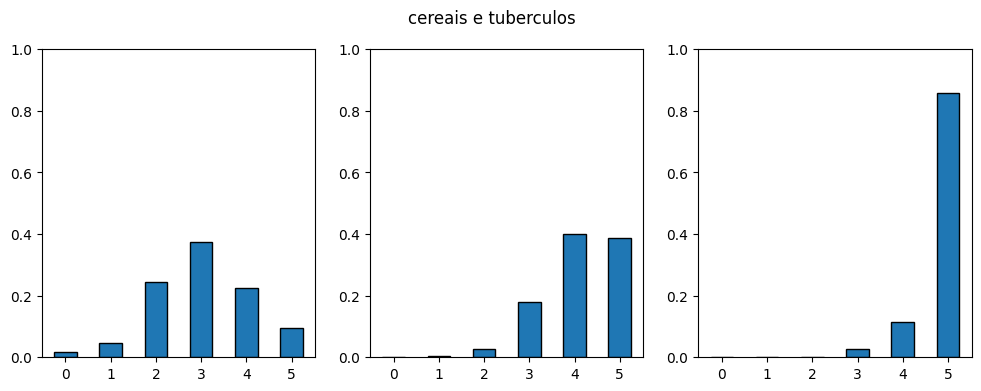

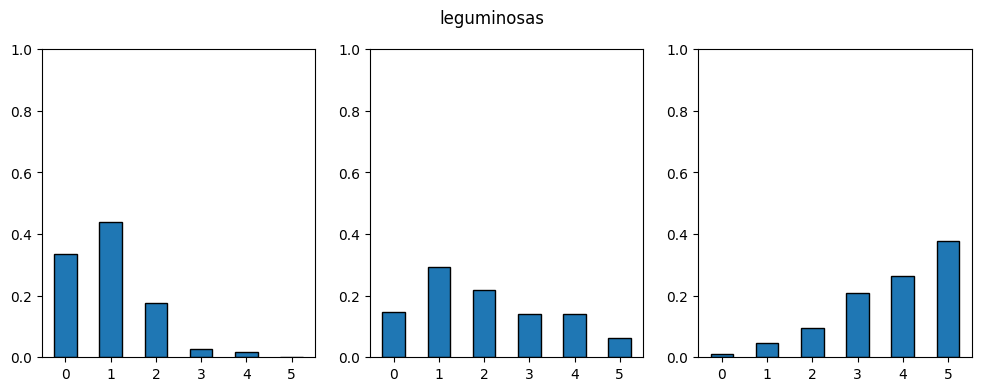

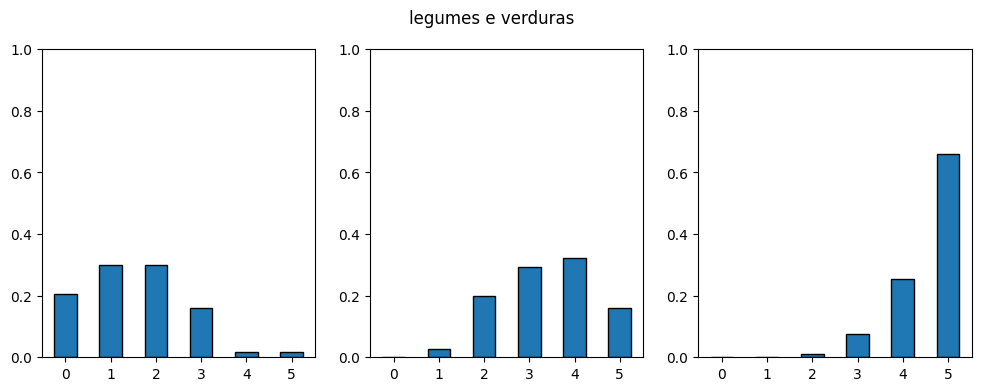

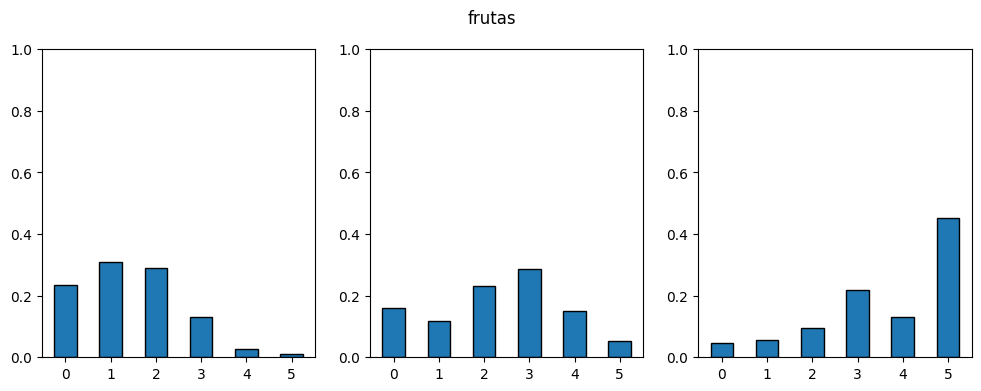

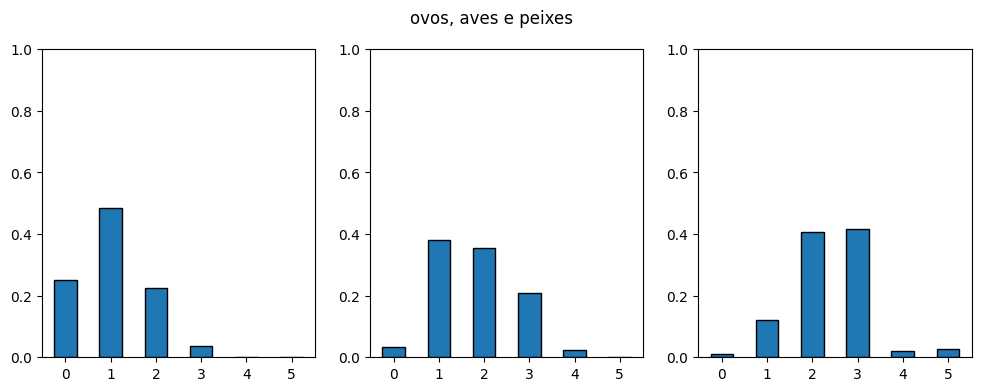

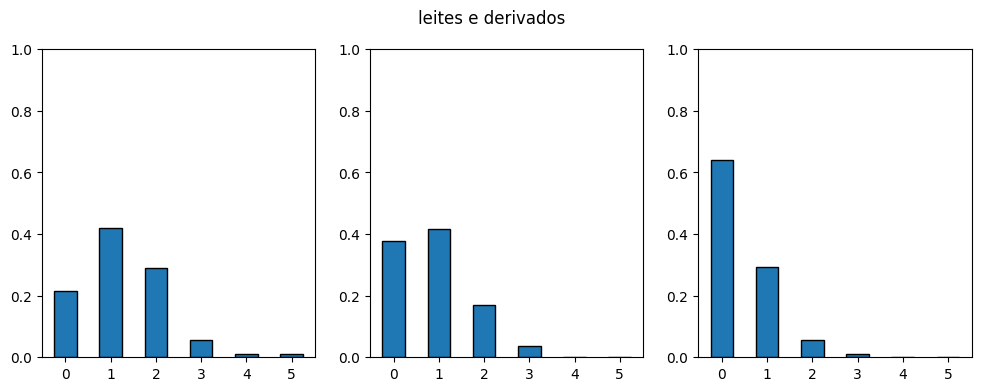

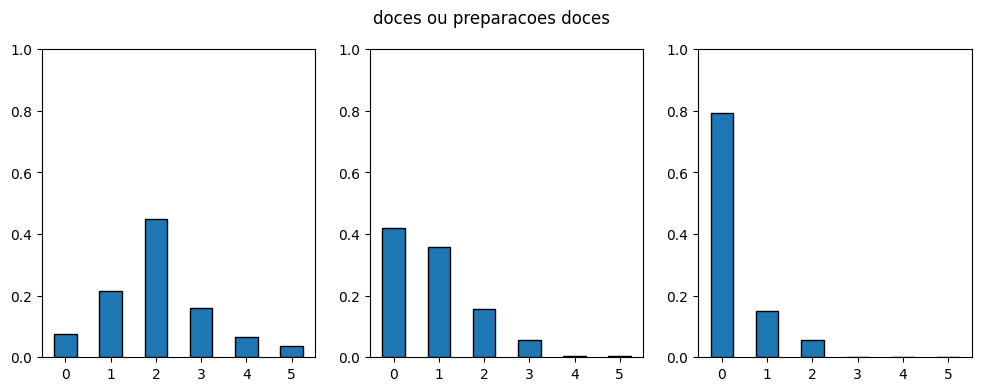

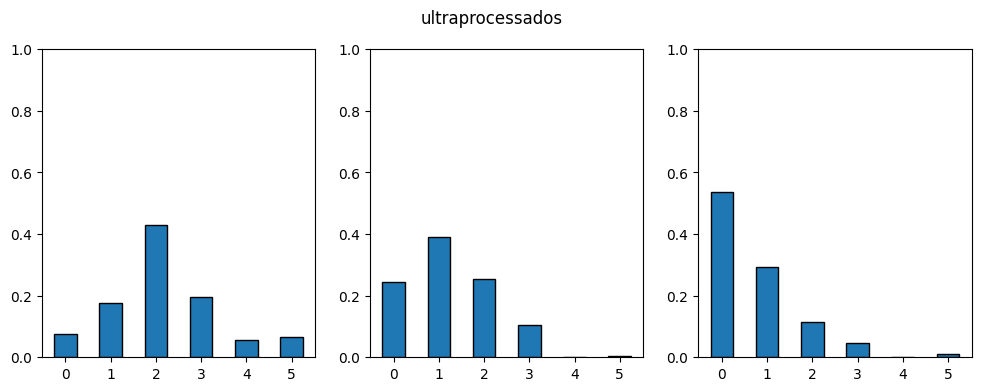

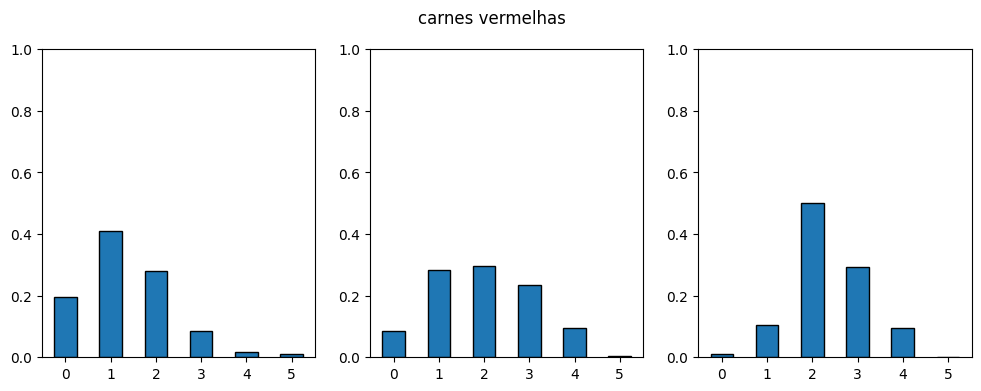

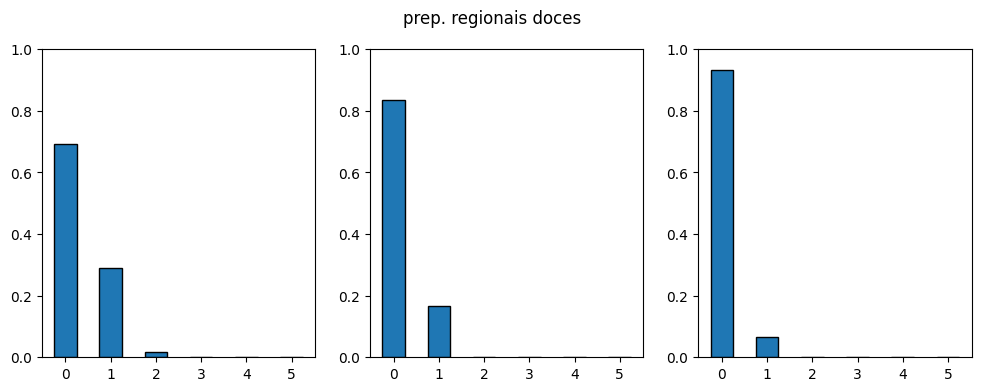

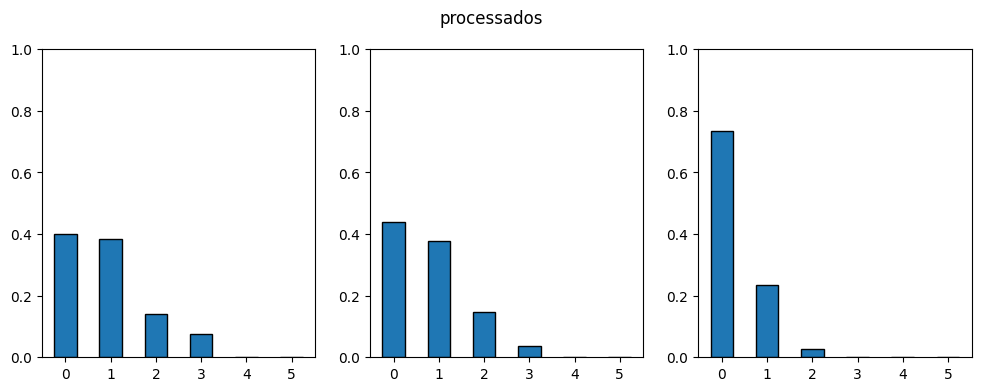

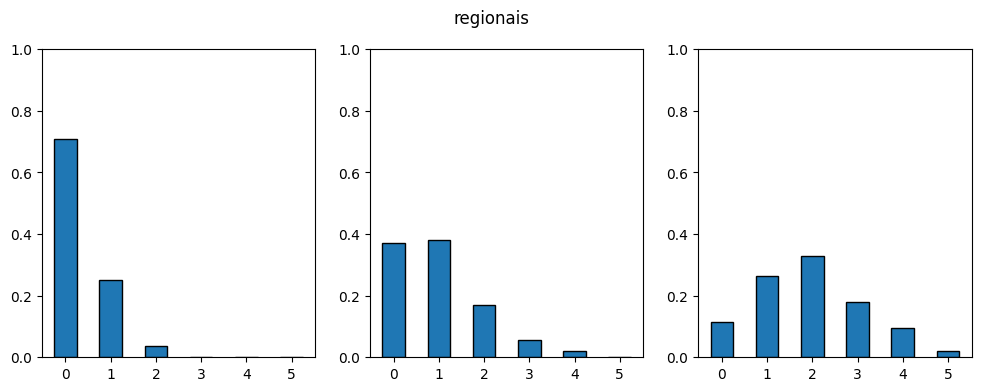

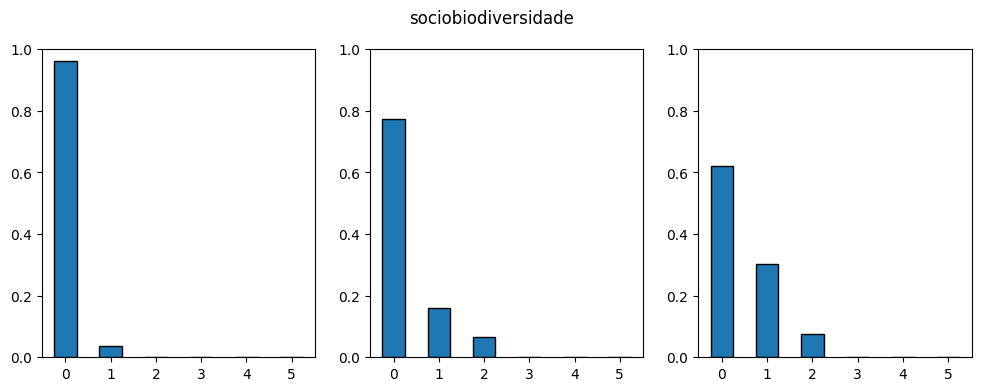

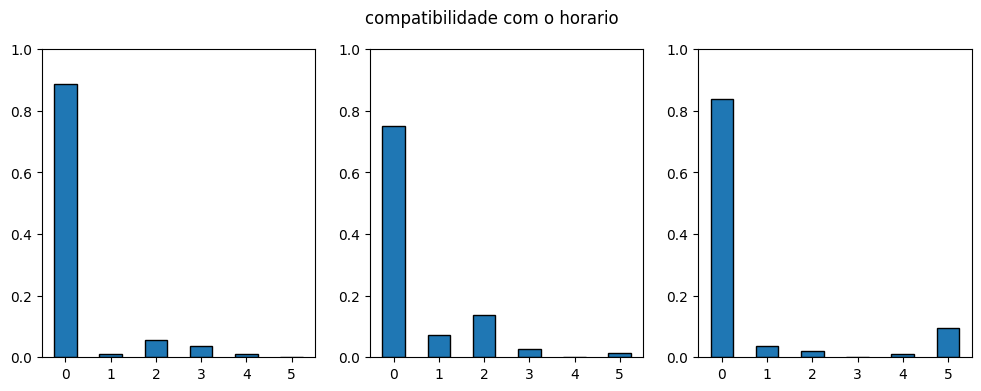

In [ ]:
import matplotlib.pyplot as plt
#vcd
for i in range(up.shape[1]):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 4))
  fig.suptitle(componentes[i])
  #counts = np.histogram(up[:,i], bins=5)
  #counts2 = np.histogram(down[:,i], bins=5)
  hist, bin_edges = np.histogram(up1[:,i], bins=[0,1,2,3,4,5,6], density=True)
  hist2, bin_edges2 = np.histogram(down2[:,i], bins=[0,1,2,3,4,5,6], density=True)

  hist3, bin_edges3 = np.histogram(med[:,i], bins=[0,1,2,3,4,5,6], density=True)
  ax1.bar(bin_edges2[:-1], hist2, width=np.diff(bin_edges2)-0.5, edgecolor='black', align='center')
  ax2.bar(bin_edges3[:-1], hist3, width=np.diff(bin_edges3)-0.5, edgecolor='black')
  ax3.bar(bin_edges[:-1], hist, width=np.diff(bin_edges)-0.5, edgecolor='black')
  #ax3.hist(up1[:,i]-0.5, bins=[0,1,2,3,4,5], rwidth=0.5, density=True)  # arguments are passed to np.histogram
  ax1.set_xticks([0,1,2,3,4,5])
  ax2.set_xticks([0,1,2,3,4,5])
  ax3.set_xticks([0,1,2,3,4,5])
  #ax2.hist(med[:,i]-0.5, bins=[0,1,2,3,4,5], rwidth=0.5, density=True)

  #ax1.hist(down2[:,i]-0.5, bins=[0,1,2,3,4,5], rwidth=0.5, density=True)
  ax1.set_ylim([0,1])
  #ax1.set_title('Escore baixo')
  ax2.set_ylim([0,1])
  #ax2.set_title('Escore medio')
  ax3.set_ylim([0,1])
  #ax3.set_title('Escore alto')
  plt.show()

Distribuição de probabilidade de cada componente de avaliação

In [ ]:
 dp_up = np.zeros((14,6))
 dp_down = np.zeros((14,6))
 dp_med = np.zeros((14,6))
 for i in range(up1.shape[1]):
    hist_up, bin_edges_up = np.histogram(up1[:,i], density=True)
    hist_down, bin_edges_down = np.histogram(down2[:,i], density=True)
    hist_med, bin_edges_med = np.histogram(med[:,i], density=True)

Cálculo da probabilidade conjunta

In [ ]:
!mkdir figuras_por

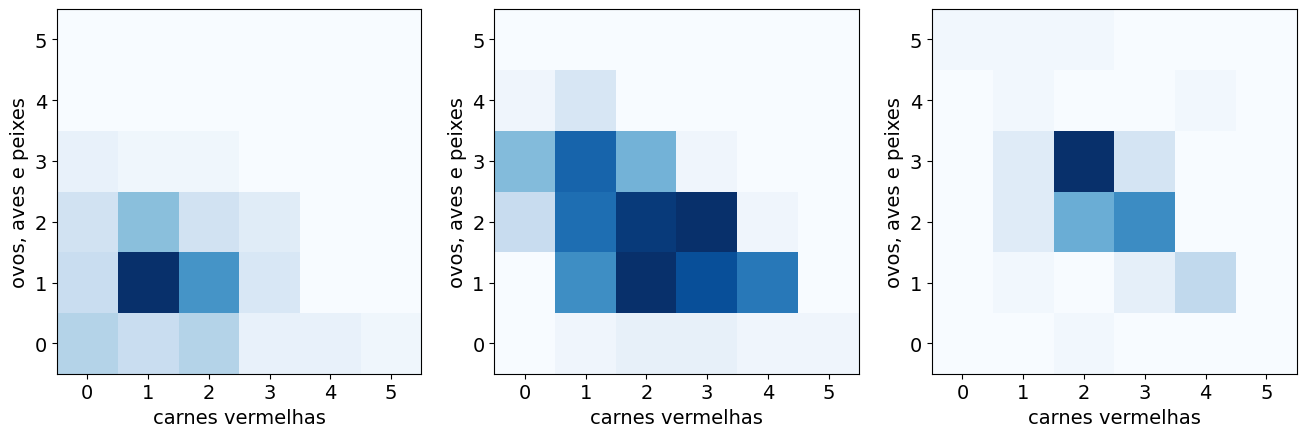

---------------------------------------------------------------------------------------------------------------------


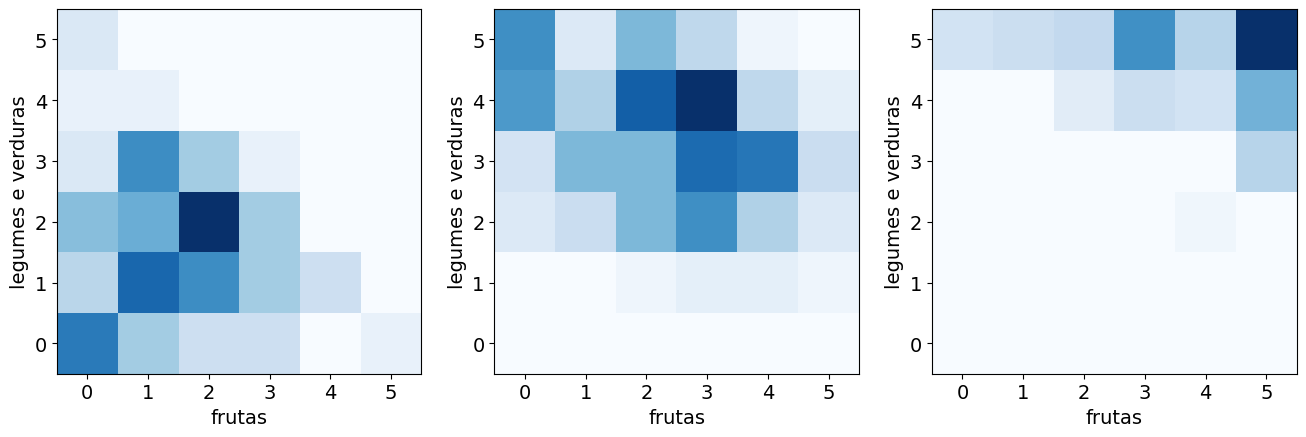

---------------------------------------------------------------------------------------------------------------------


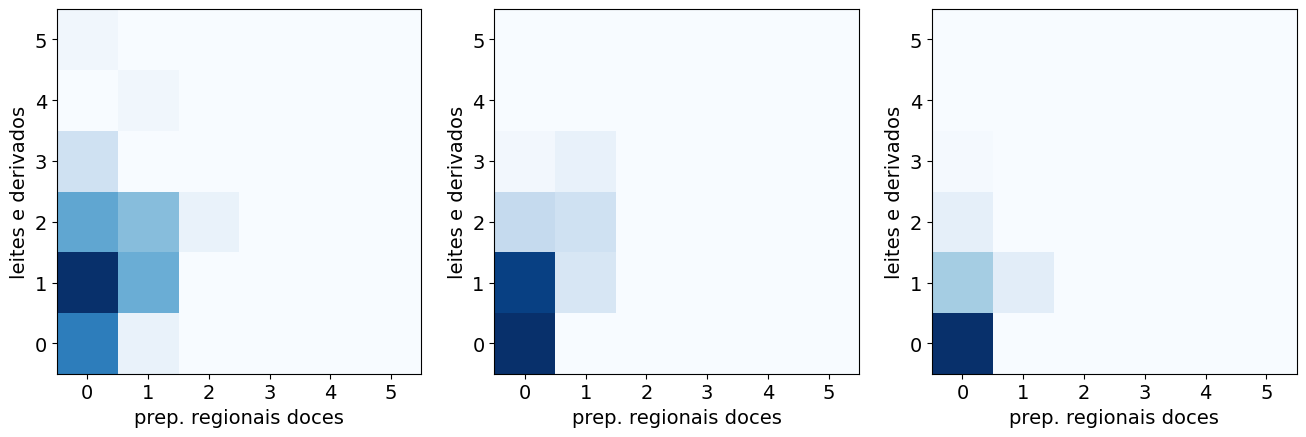

---------------------------------------------------------------------------------------------------------------------


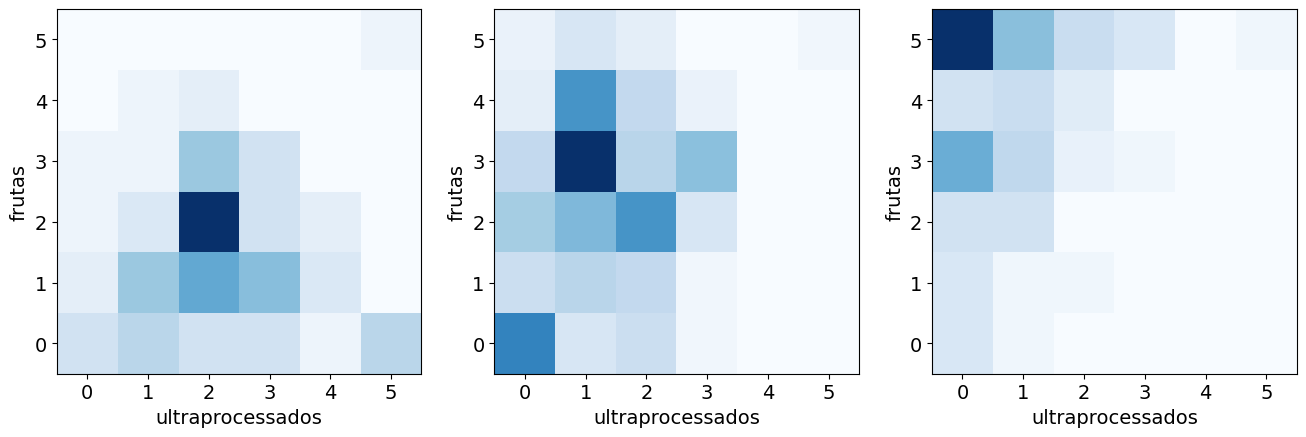

---------------------------------------------------------------------------------------------------------------------


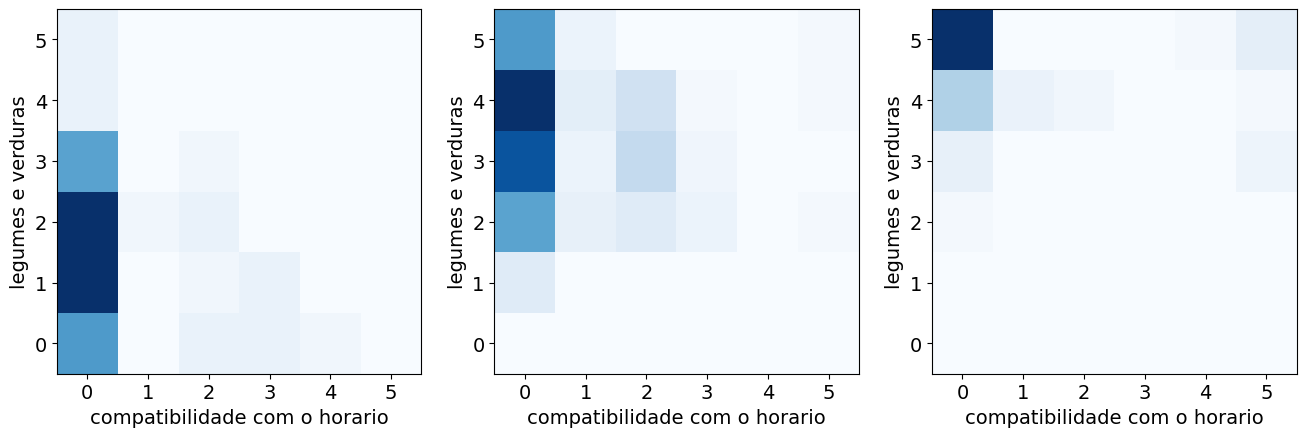

---------------------------------------------------------------------------------------------------------------------


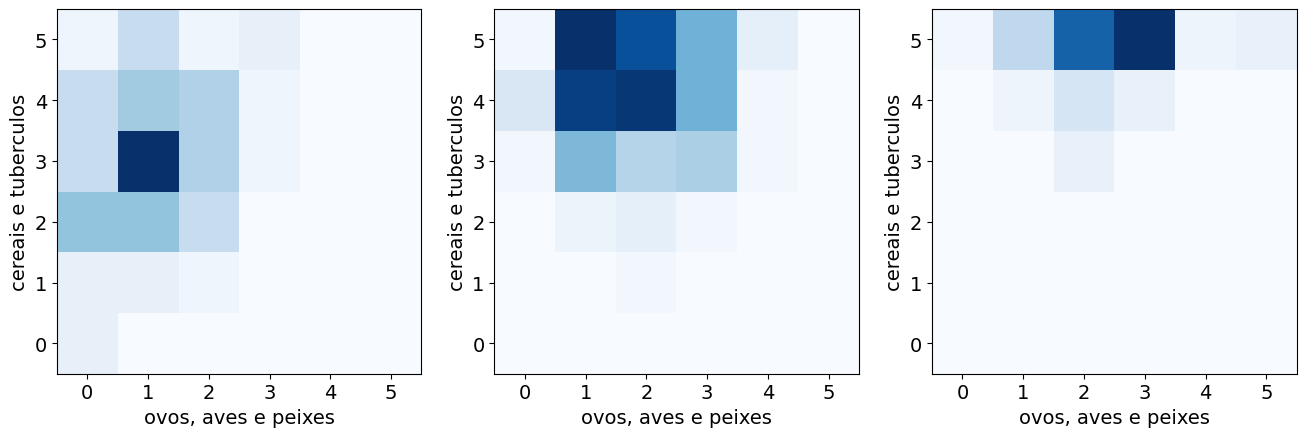

---------------------------------------------------------------------------------------------------------------------


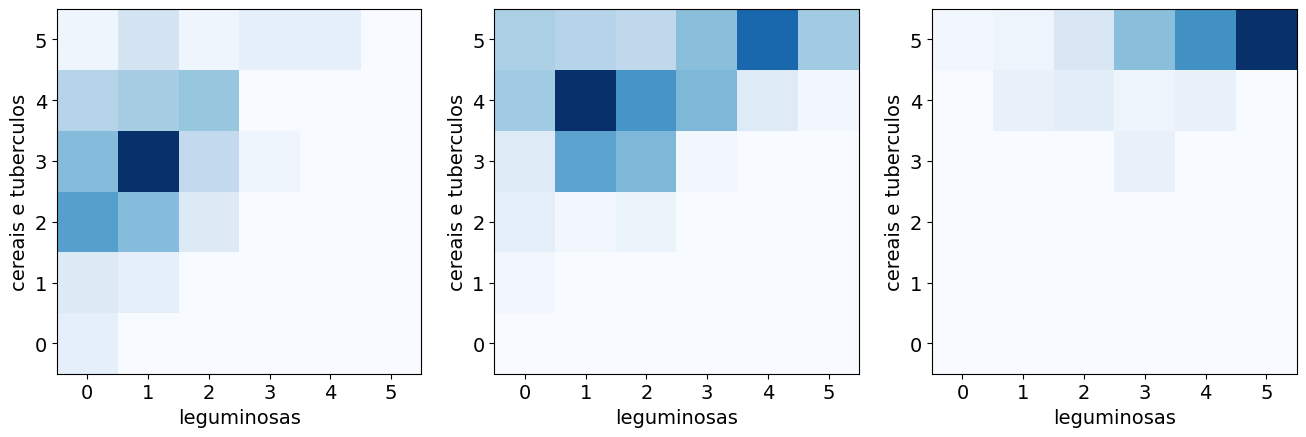

---------------------------------------------------------------------------------------------------------------------


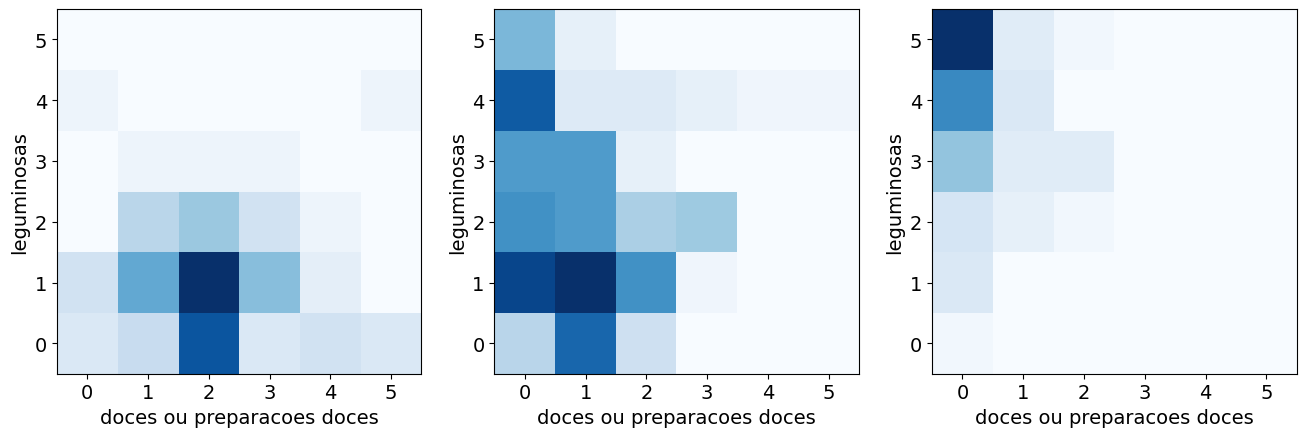

---------------------------------------------------------------------------------------------------------------------


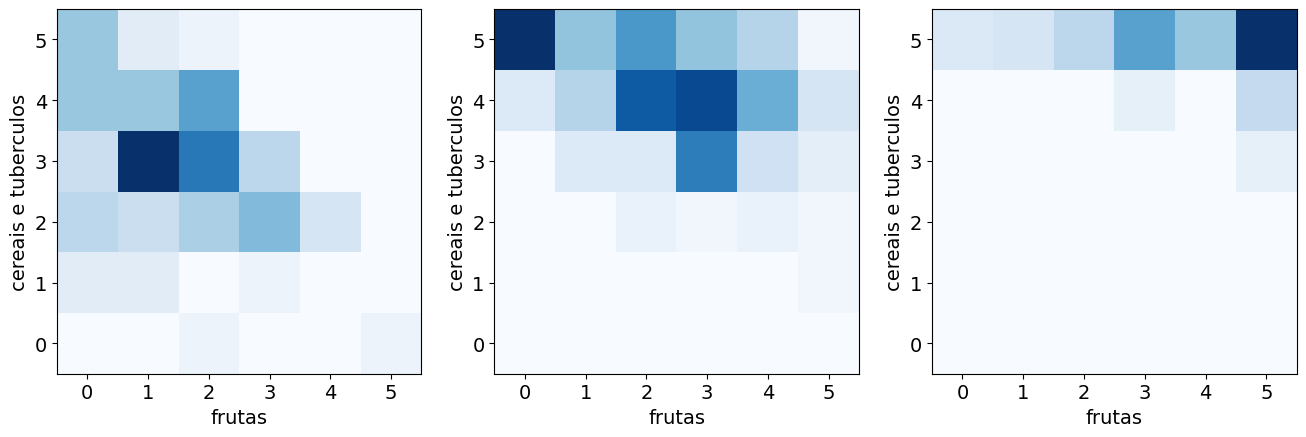

---------------------------------------------------------------------------------------------------------------------


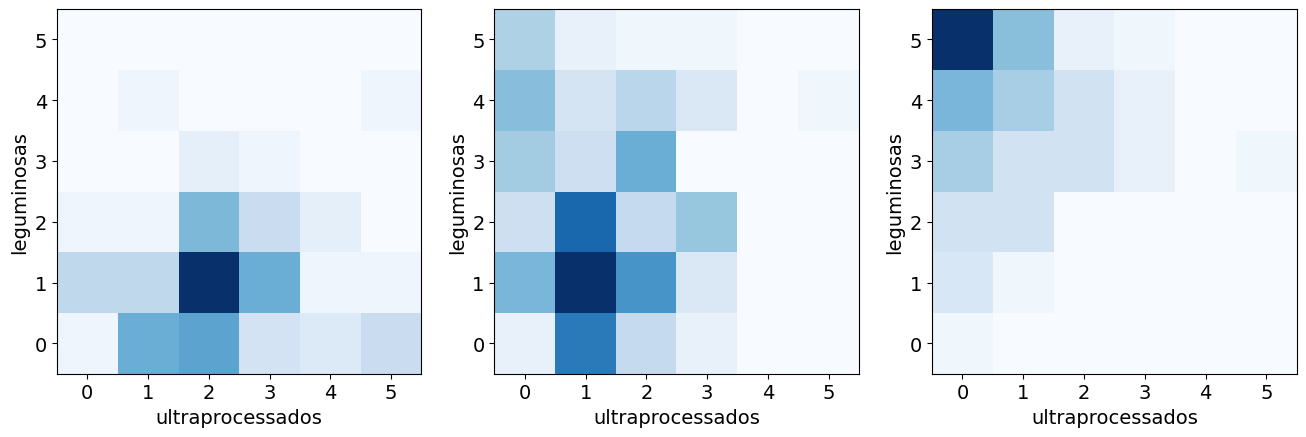

---------------------------------------------------------------------------------------------------------------------


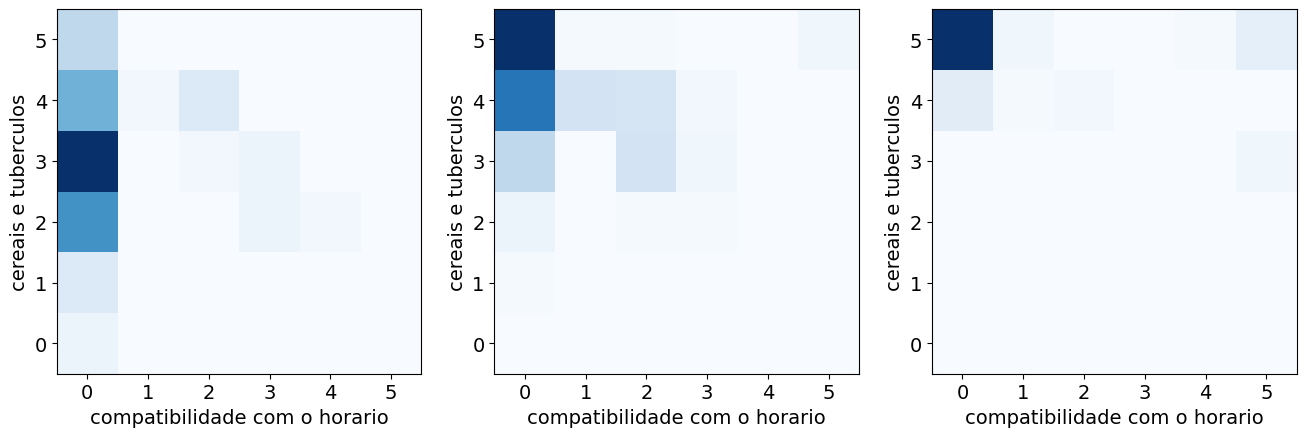

---------------------------------------------------------------------------------------------------------------------


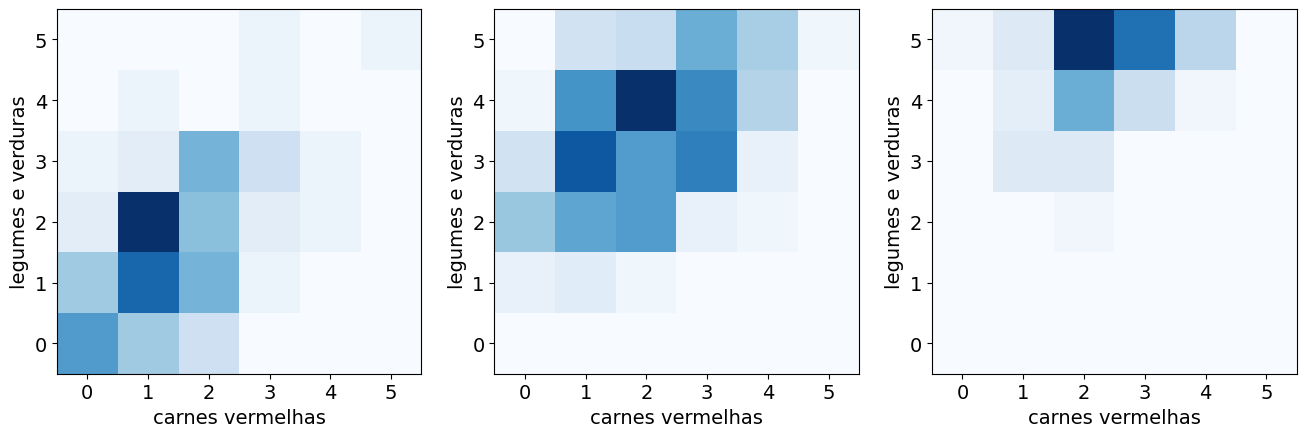

---------------------------------------------------------------------------------------------------------------------


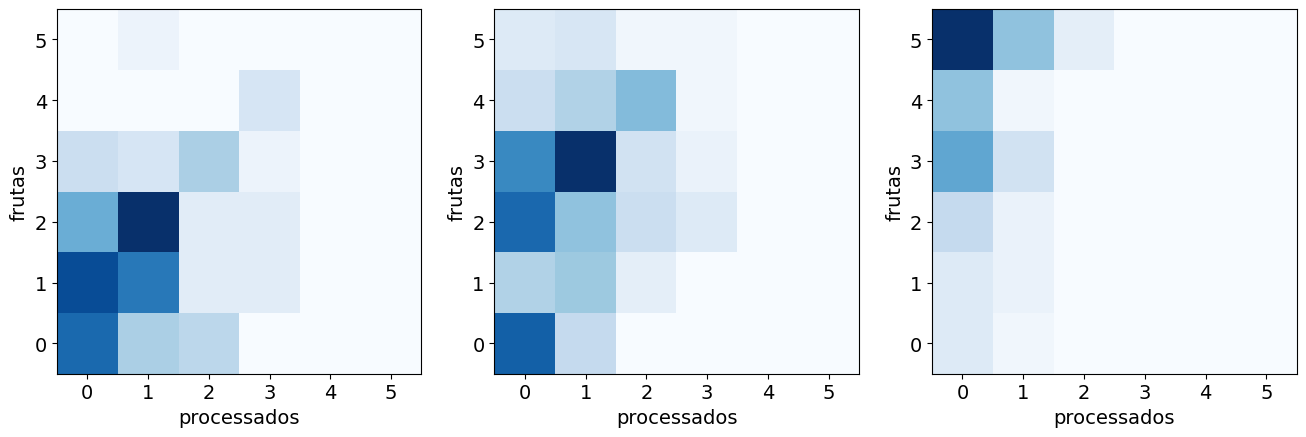

---------------------------------------------------------------------------------------------------------------------


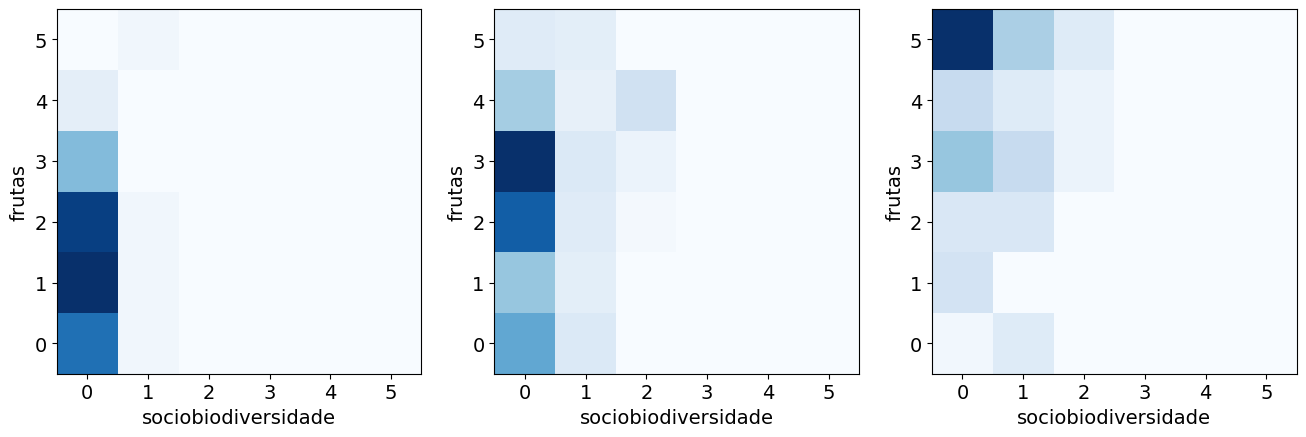

---------------------------------------------------------------------------------------------------------------------


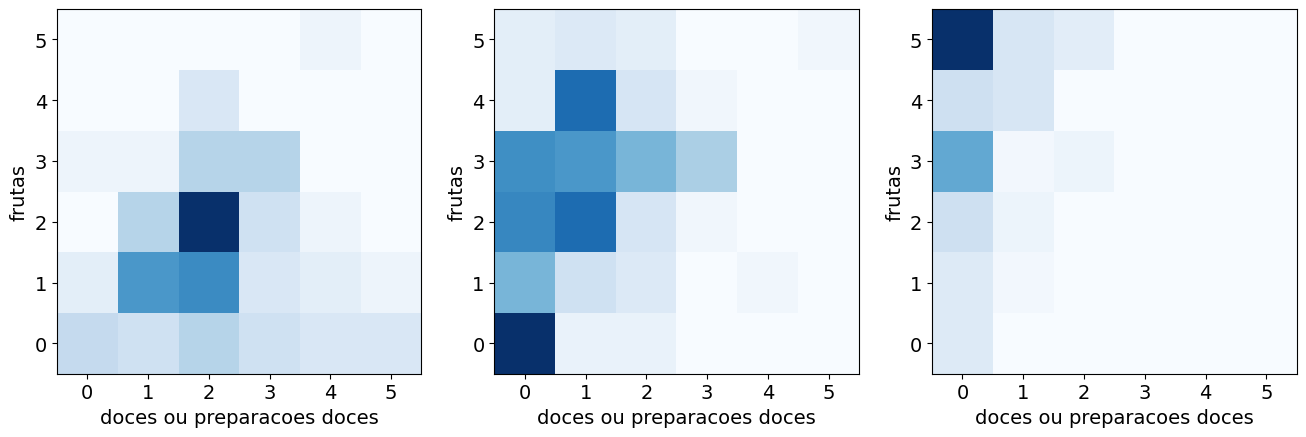

---------------------------------------------------------------------------------------------------------------------


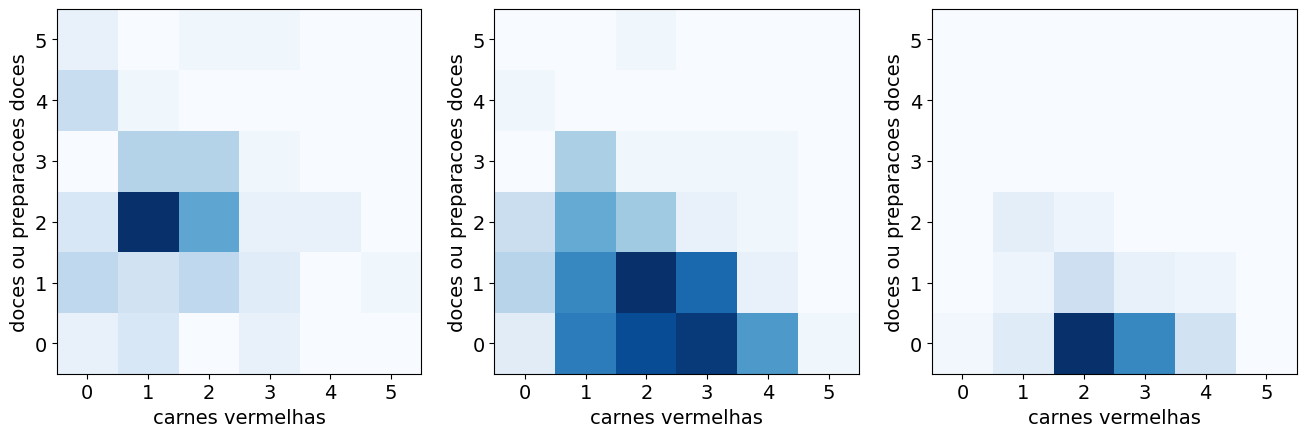

---------------------------------------------------------------------------------------------------------------------


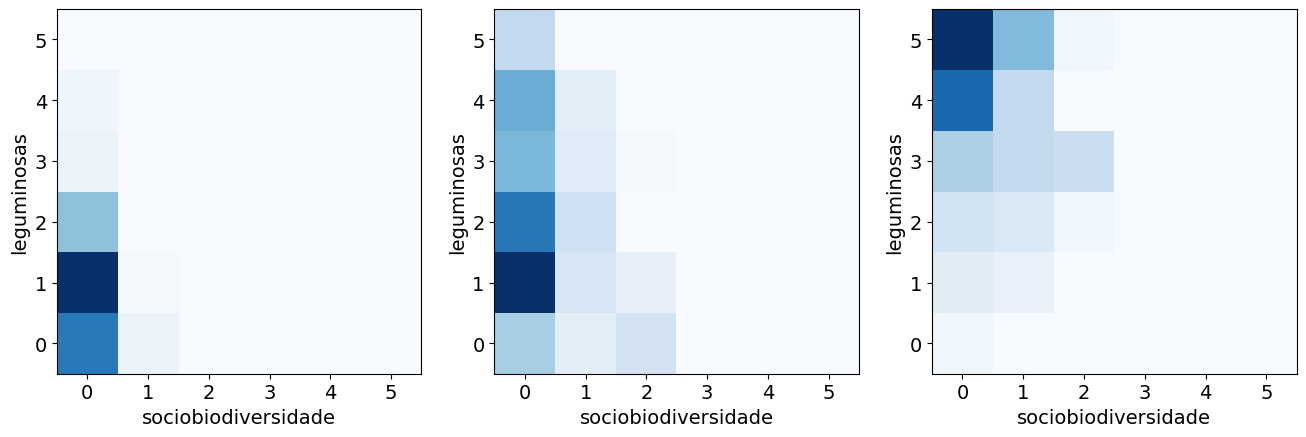

---------------------------------------------------------------------------------------------------------------------


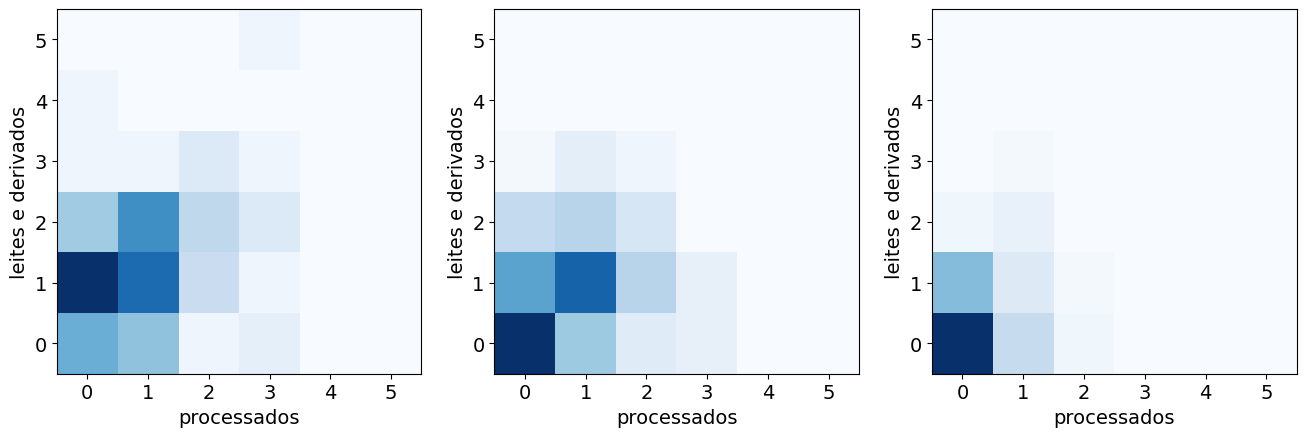

---------------------------------------------------------------------------------------------------------------------


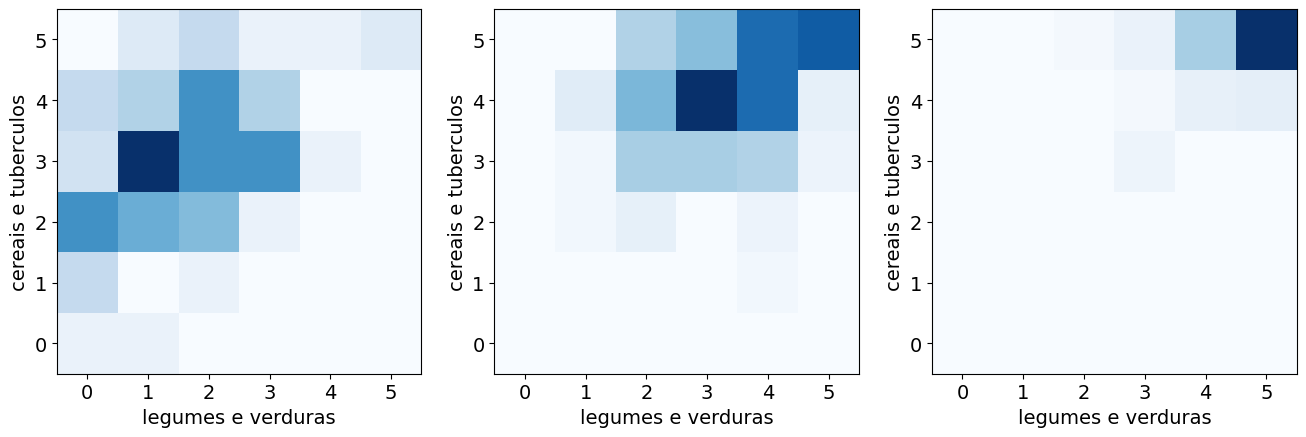

---------------------------------------------------------------------------------------------------------------------


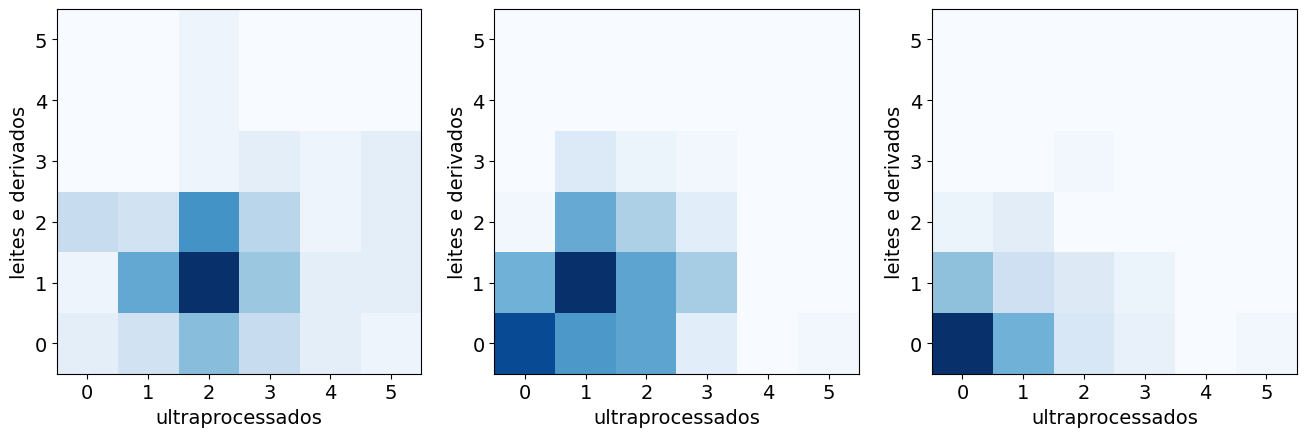

---------------------------------------------------------------------------------------------------------------------


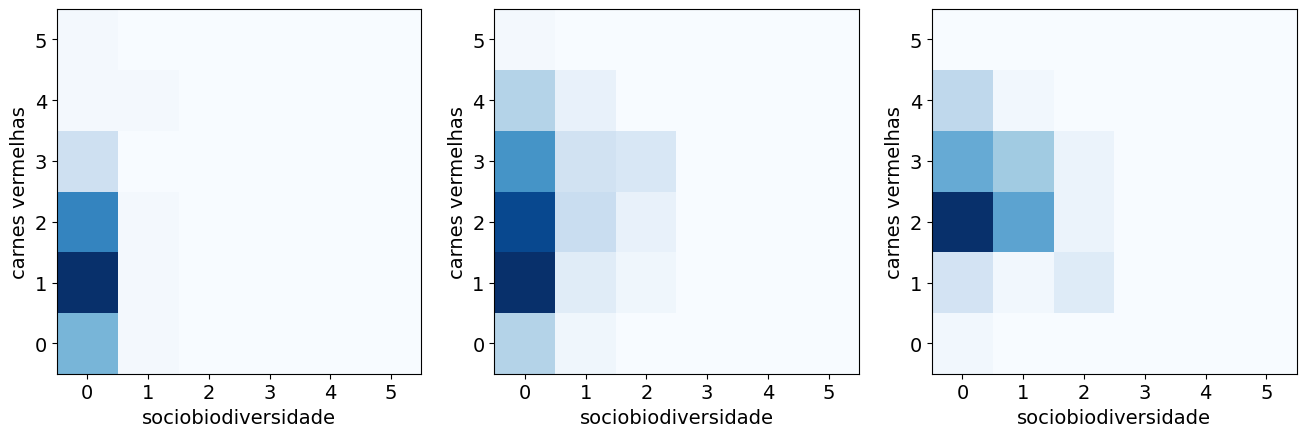

---------------------------------------------------------------------------------------------------------------------


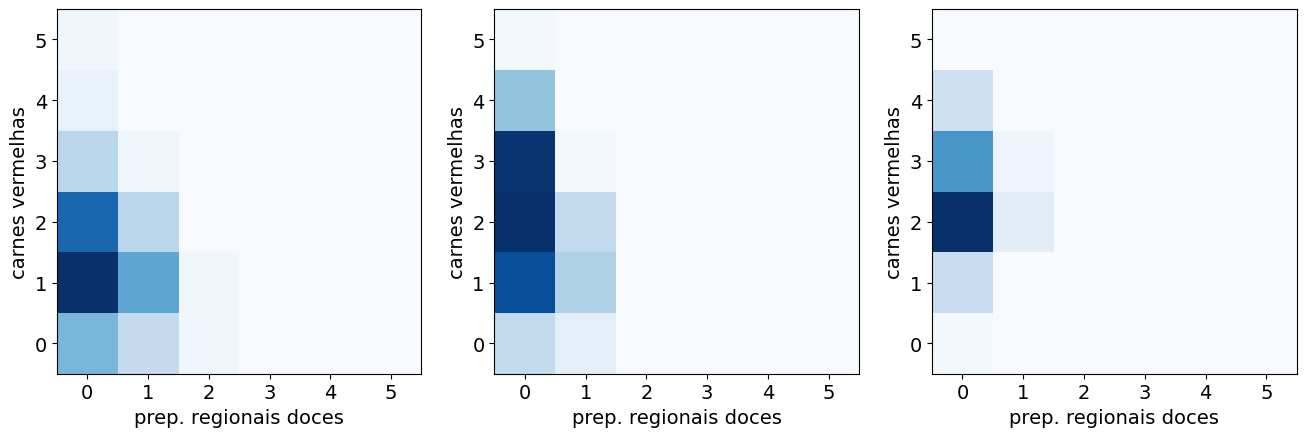

---------------------------------------------------------------------------------------------------------------------


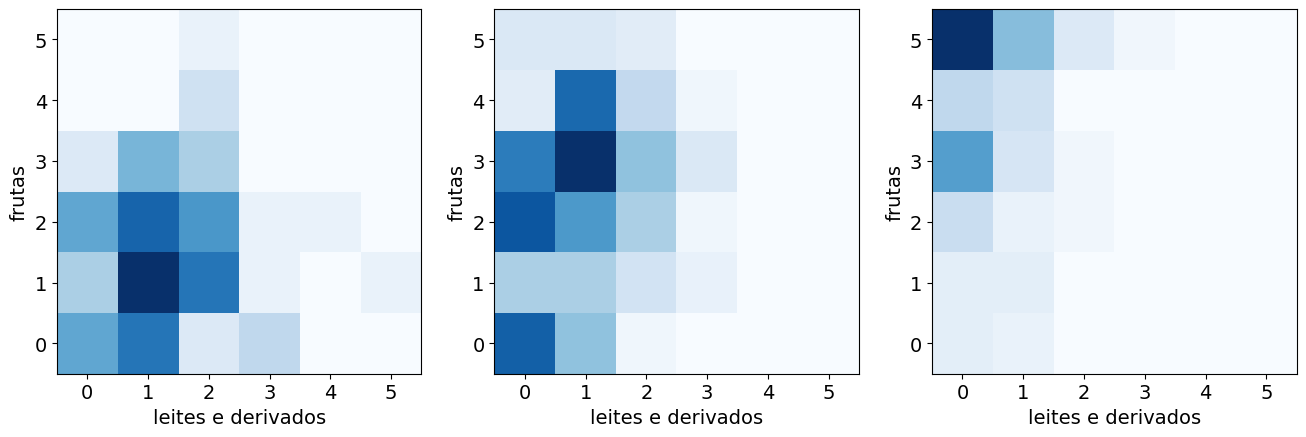

---------------------------------------------------------------------------------------------------------------------


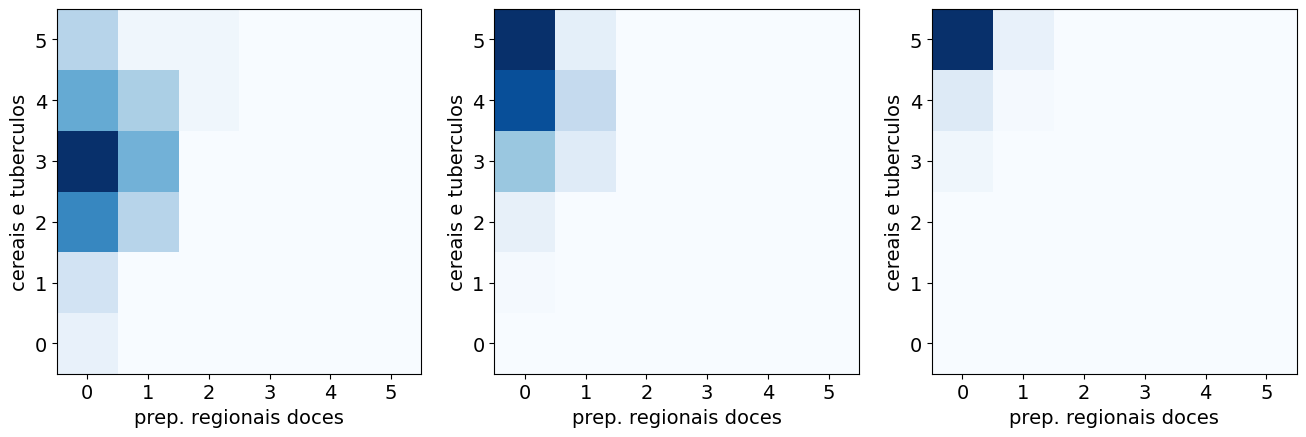

---------------------------------------------------------------------------------------------------------------------


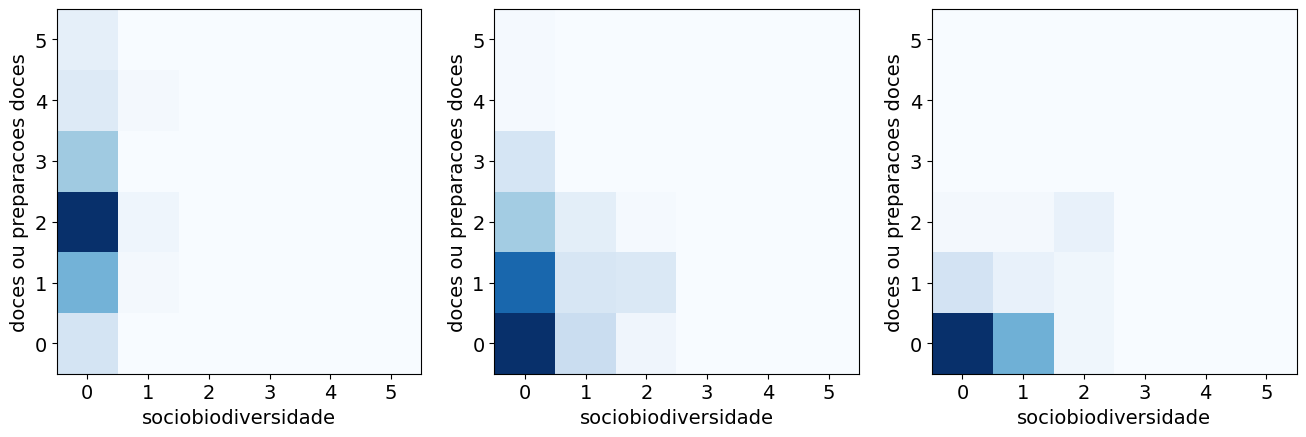

---------------------------------------------------------------------------------------------------------------------


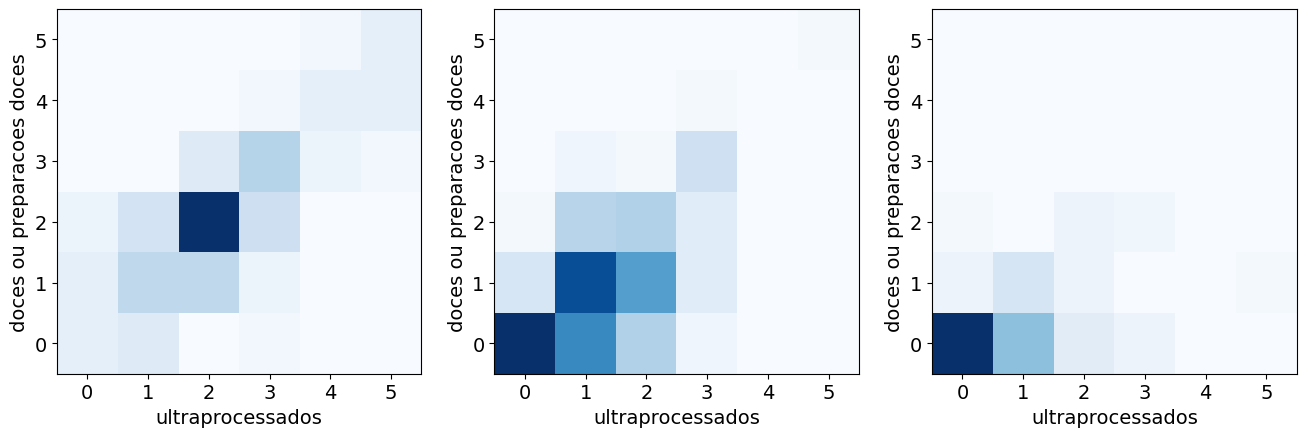

---------------------------------------------------------------------------------------------------------------------


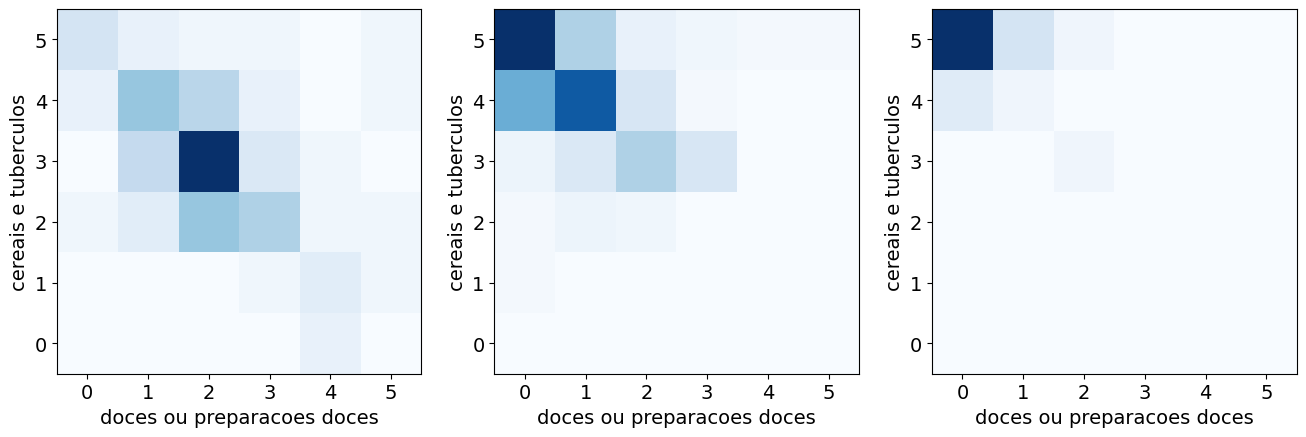

---------------------------------------------------------------------------------------------------------------------


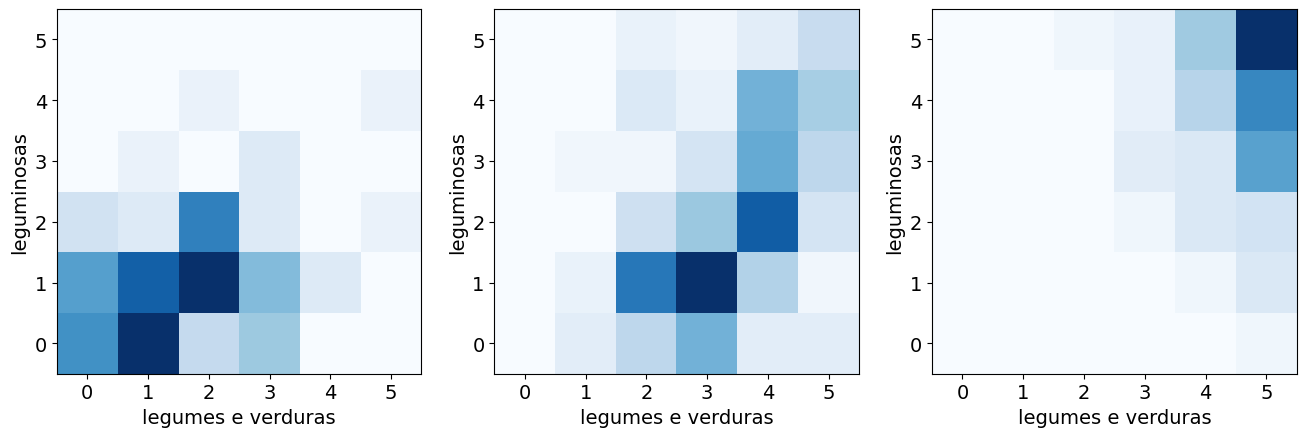

---------------------------------------------------------------------------------------------------------------------


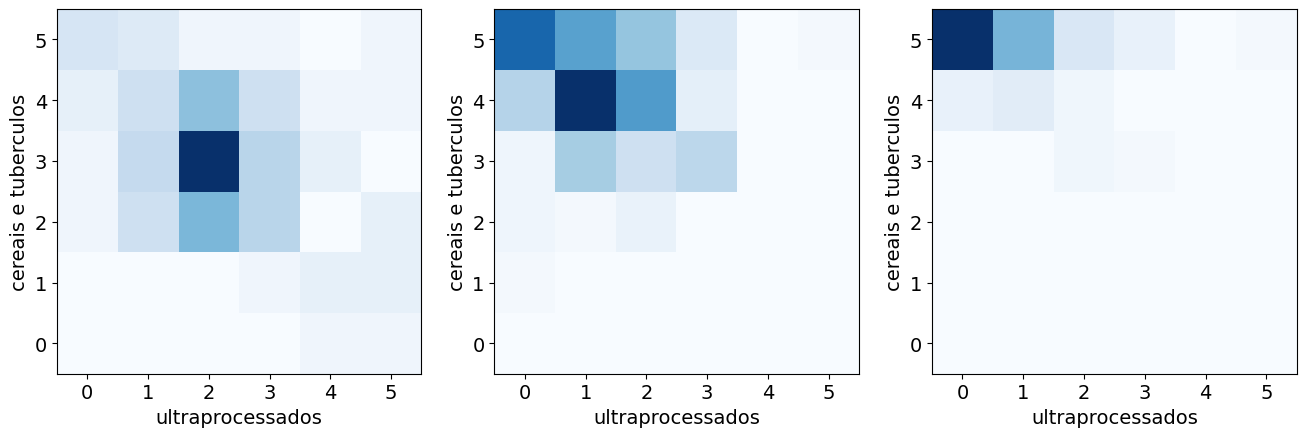

---------------------------------------------------------------------------------------------------------------------


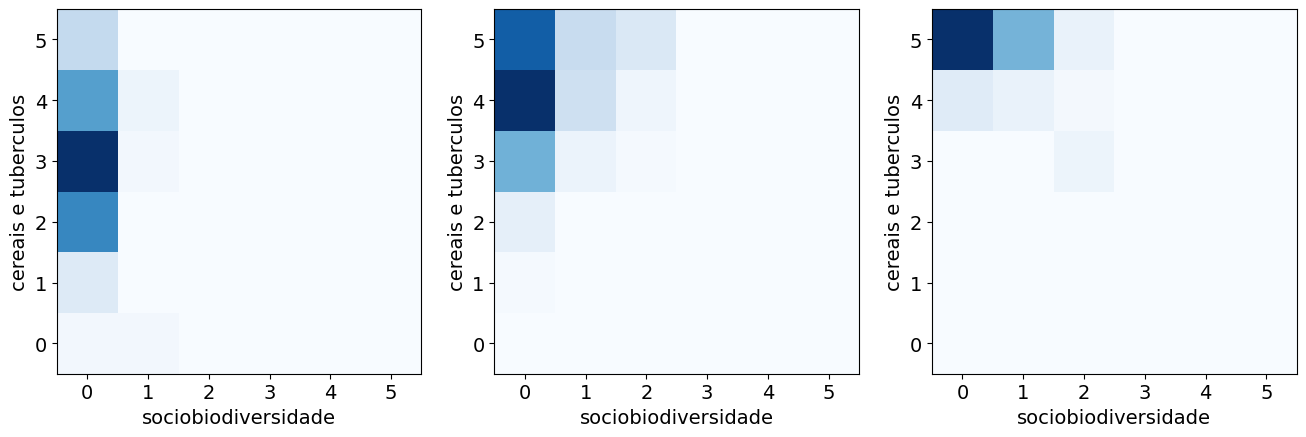

---------------------------------------------------------------------------------------------------------------------


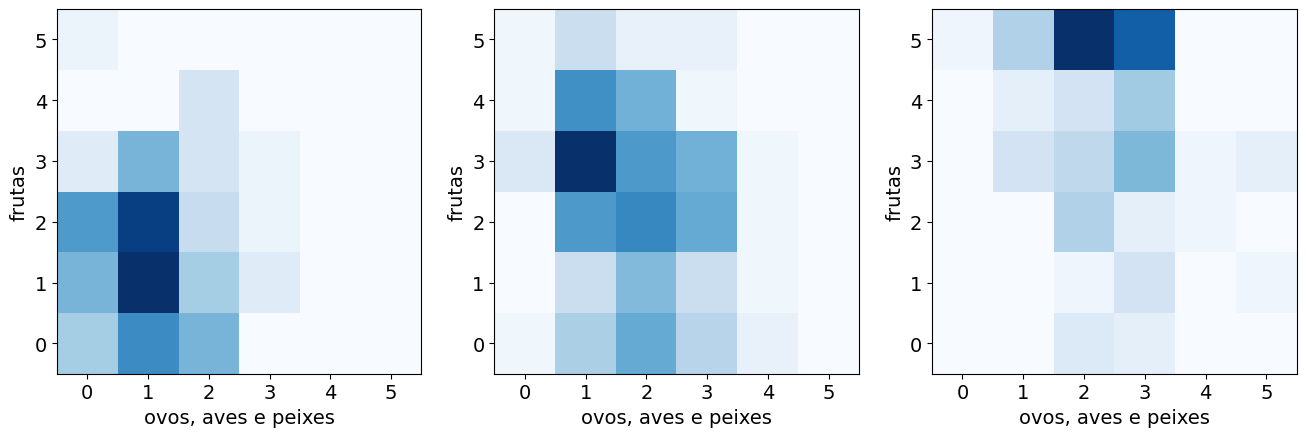

---------------------------------------------------------------------------------------------------------------------


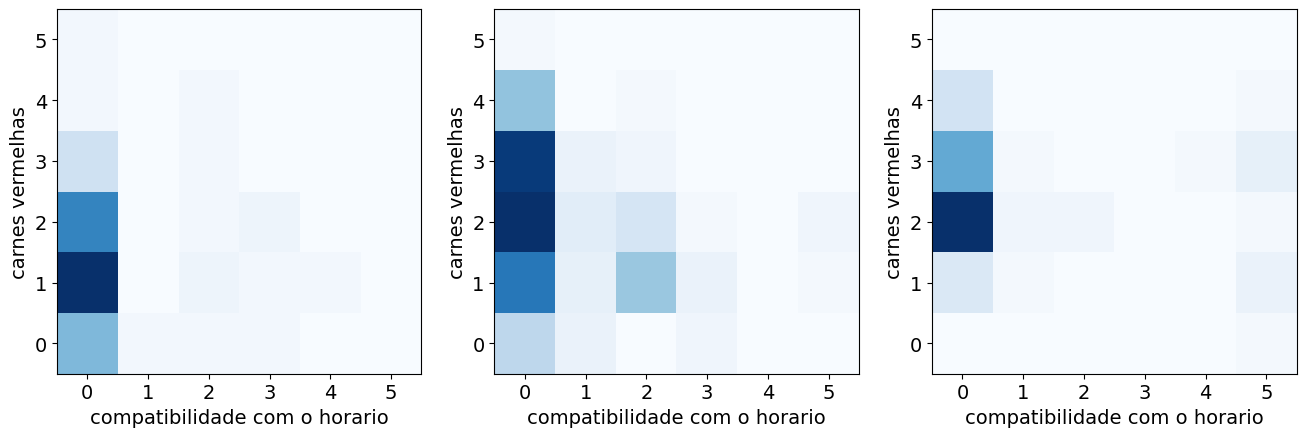

---------------------------------------------------------------------------------------------------------------------


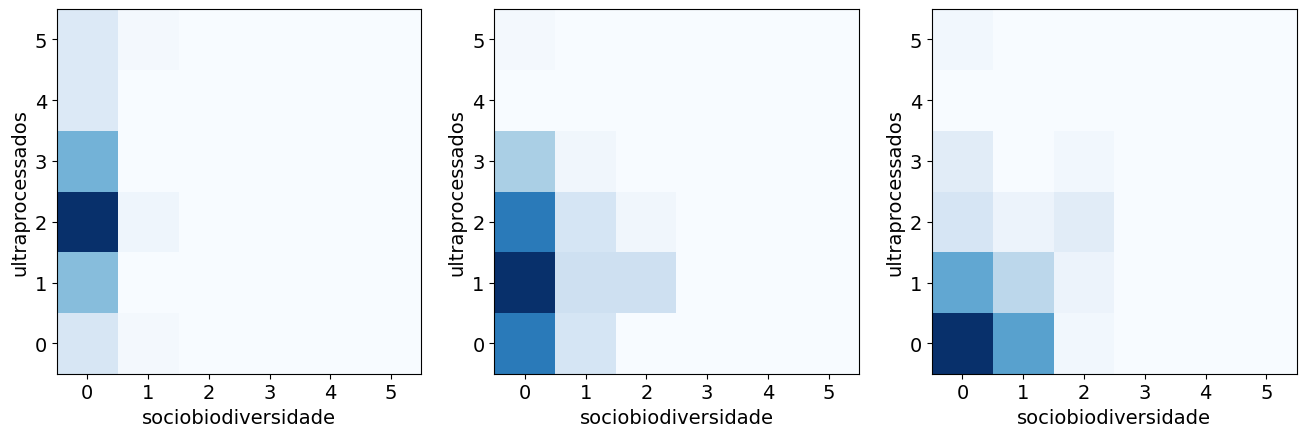

---------------------------------------------------------------------------------------------------------------------


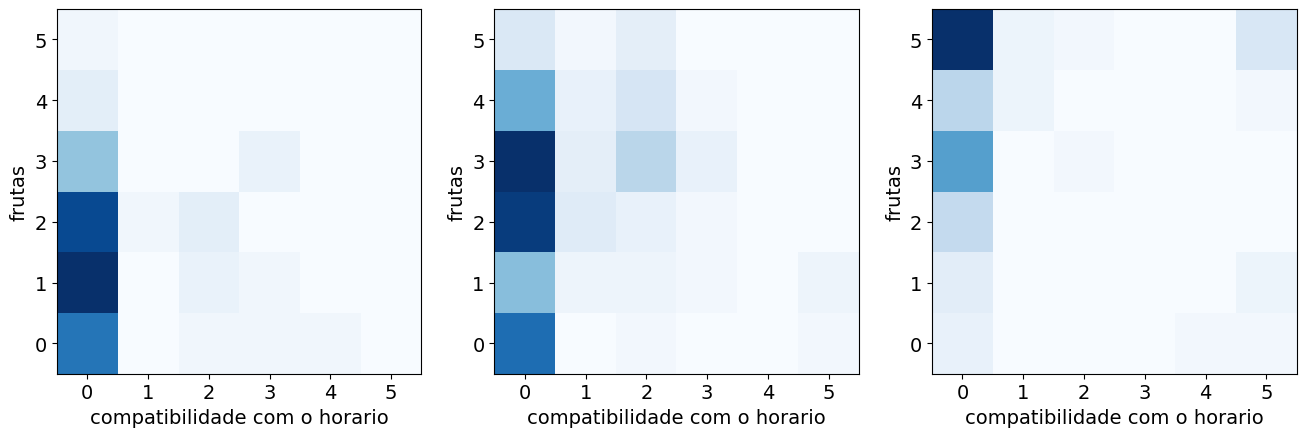

---------------------------------------------------------------------------------------------------------------------


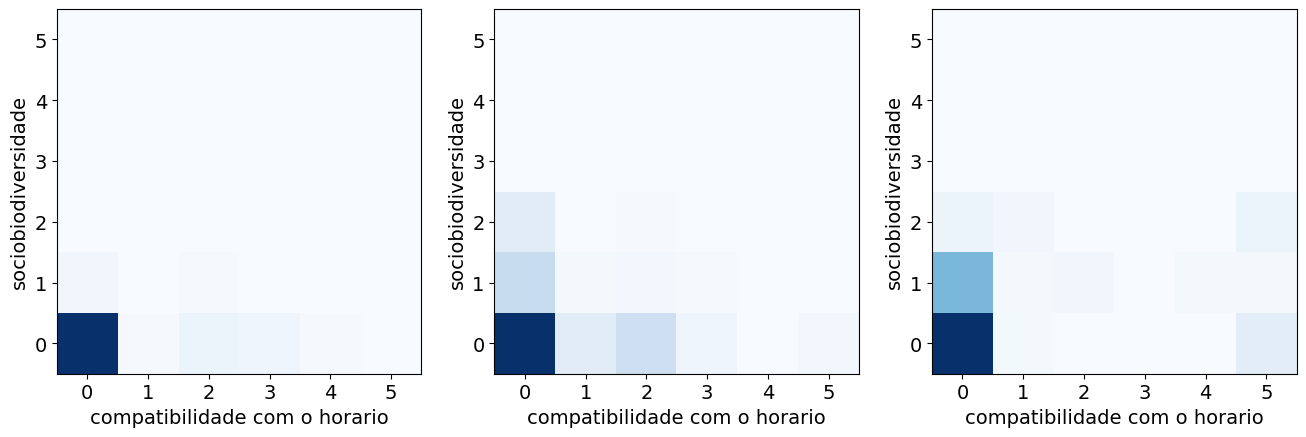

---------------------------------------------------------------------------------------------------------------------


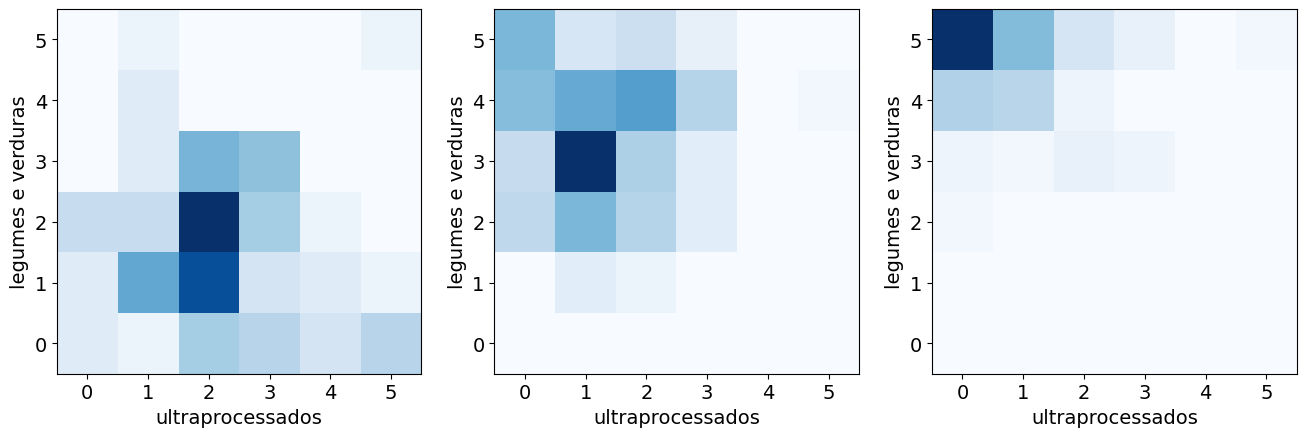

---------------------------------------------------------------------------------------------------------------------


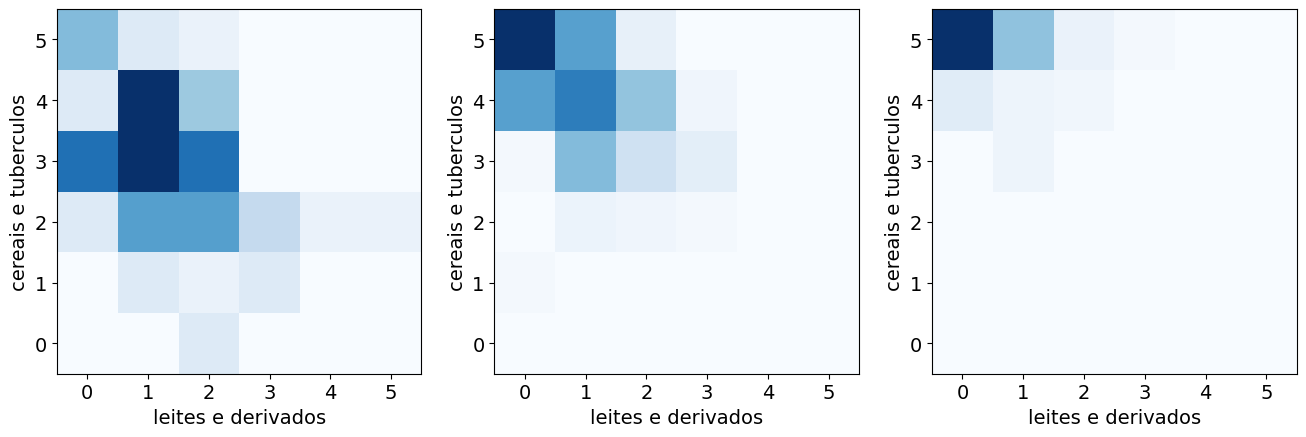

---------------------------------------------------------------------------------------------------------------------


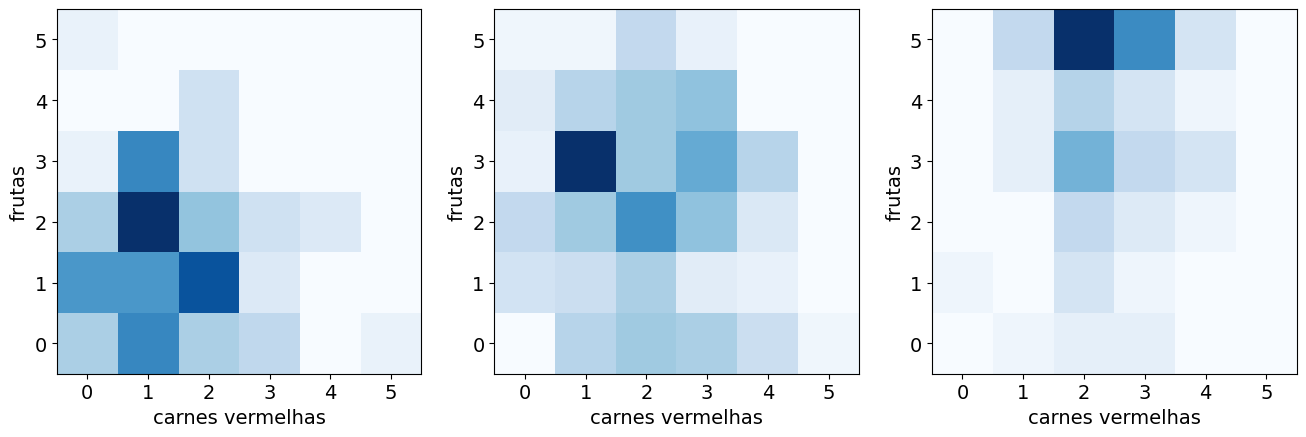

---------------------------------------------------------------------------------------------------------------------


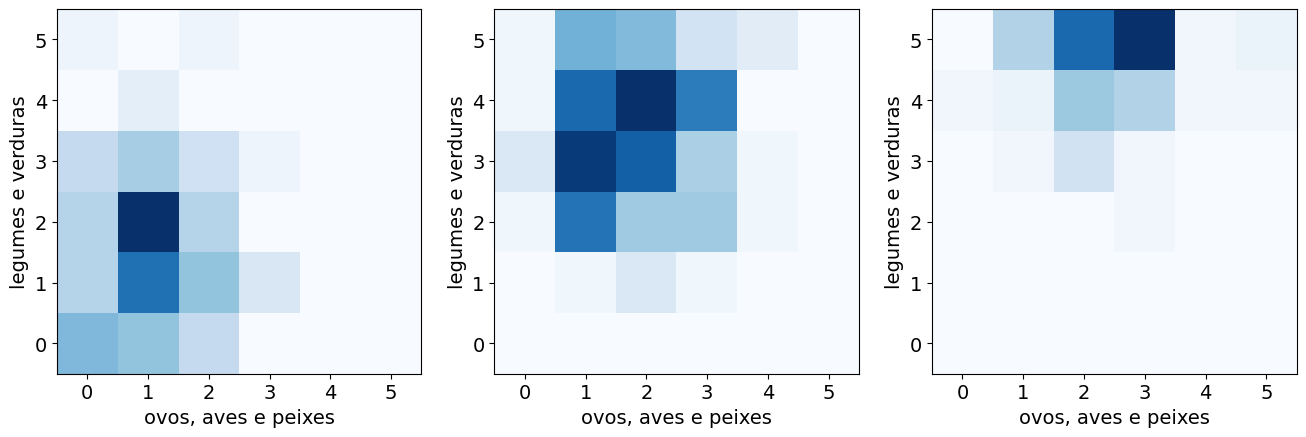

---------------------------------------------------------------------------------------------------------------------


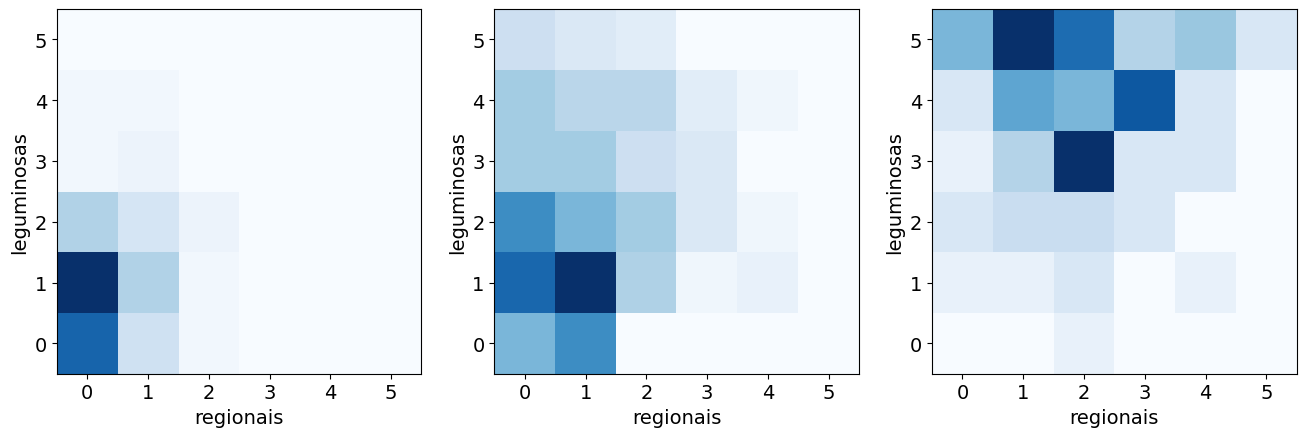

---------------------------------------------------------------------------------------------------------------------


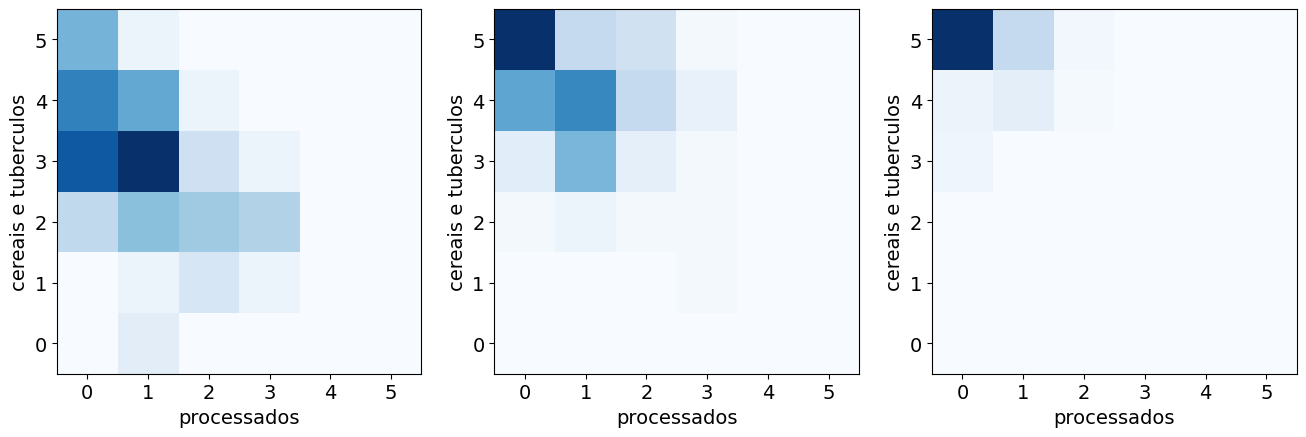

---------------------------------------------------------------------------------------------------------------------


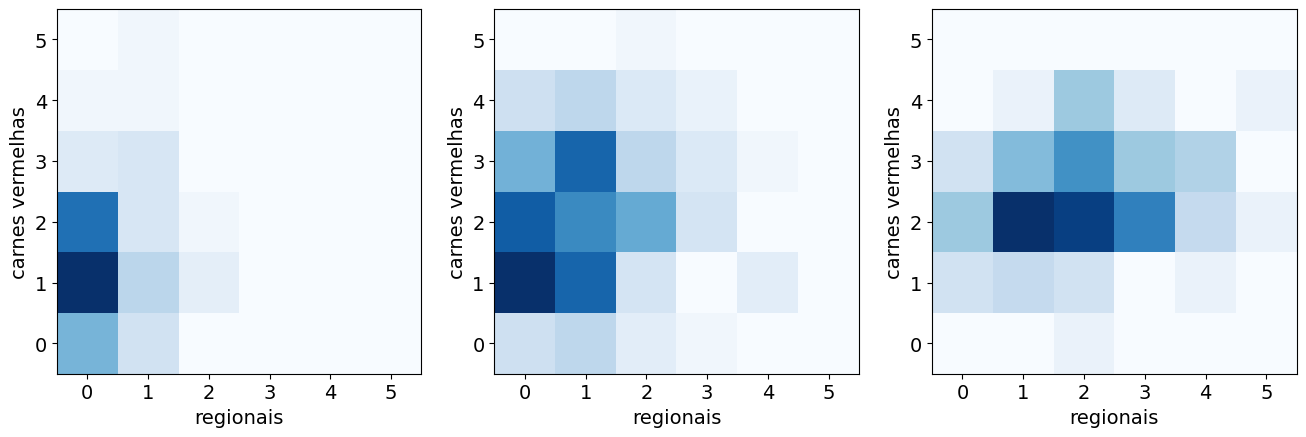

---------------------------------------------------------------------------------------------------------------------


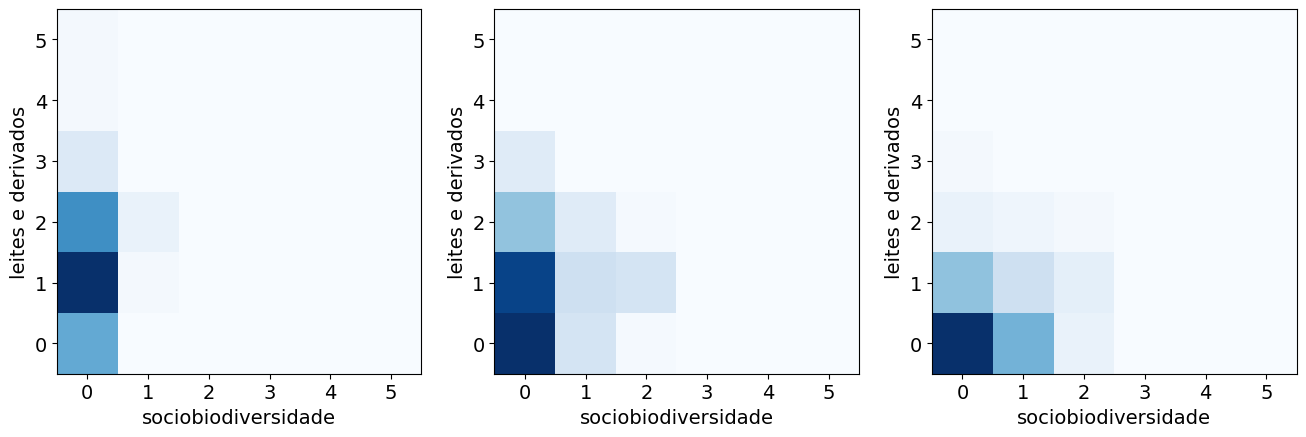

---------------------------------------------------------------------------------------------------------------------


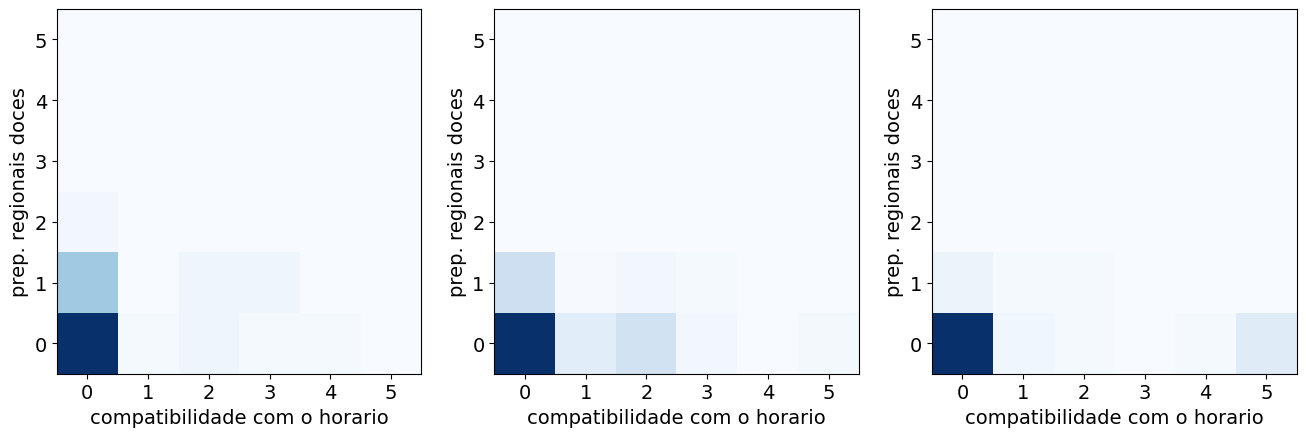

---------------------------------------------------------------------------------------------------------------------


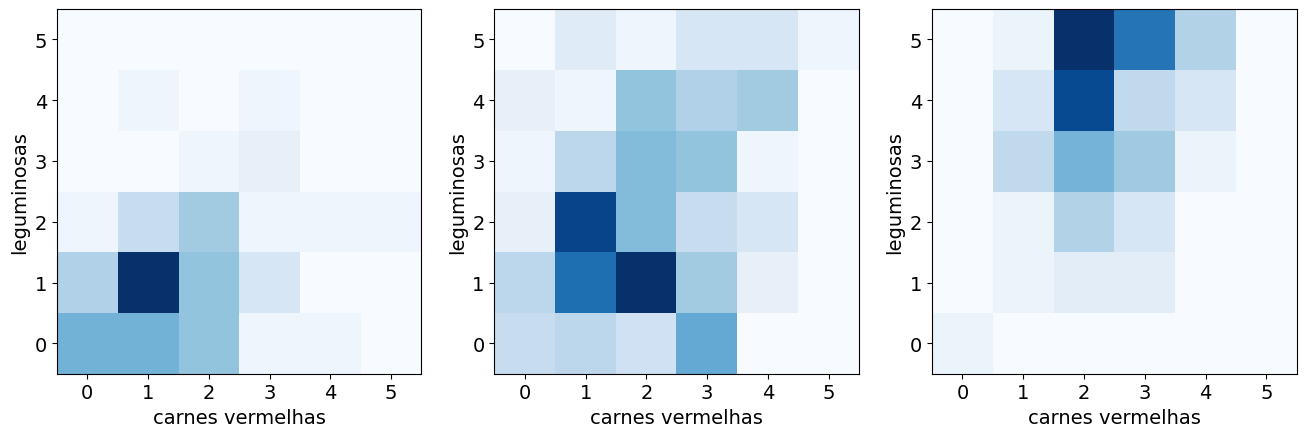

---------------------------------------------------------------------------------------------------------------------


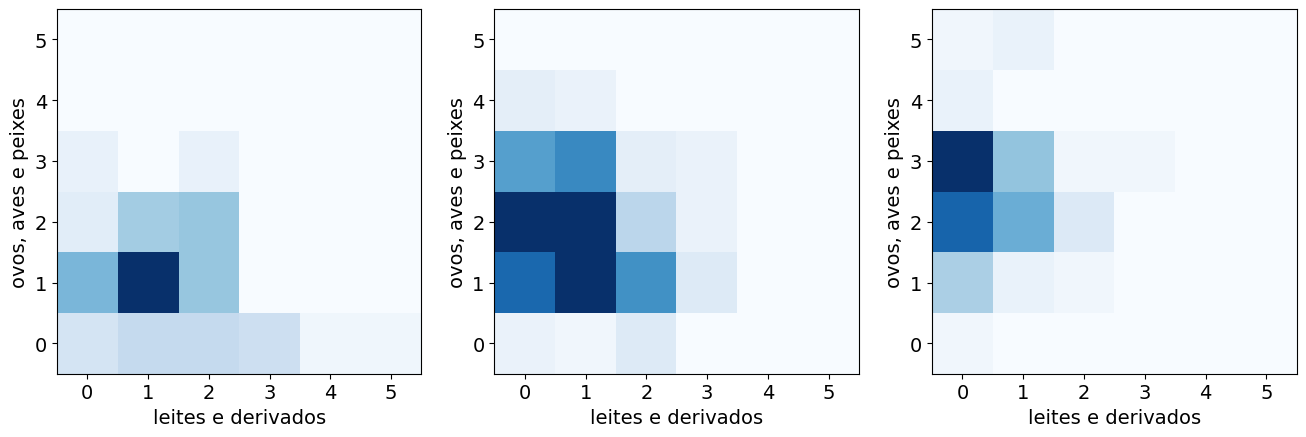

---------------------------------------------------------------------------------------------------------------------


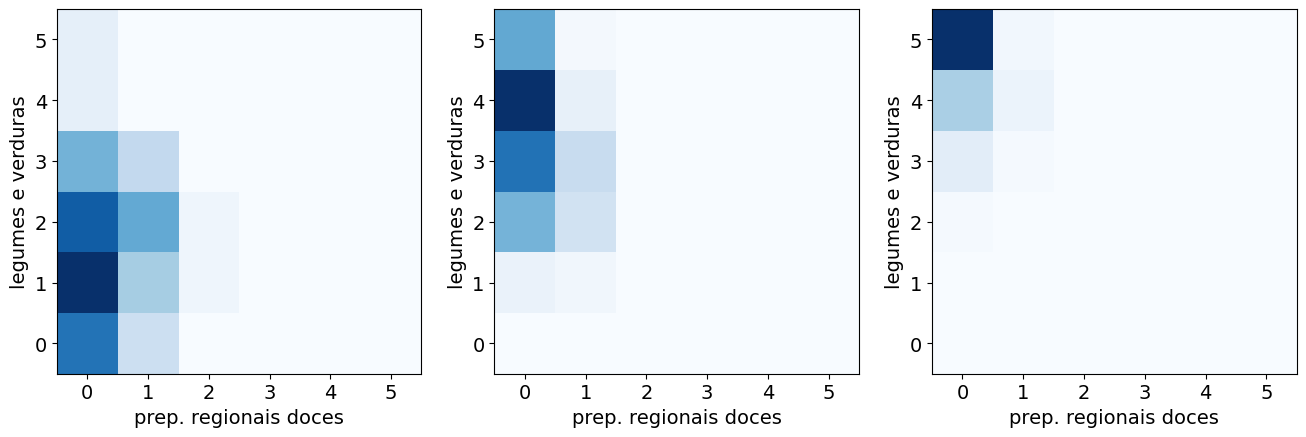

---------------------------------------------------------------------------------------------------------------------


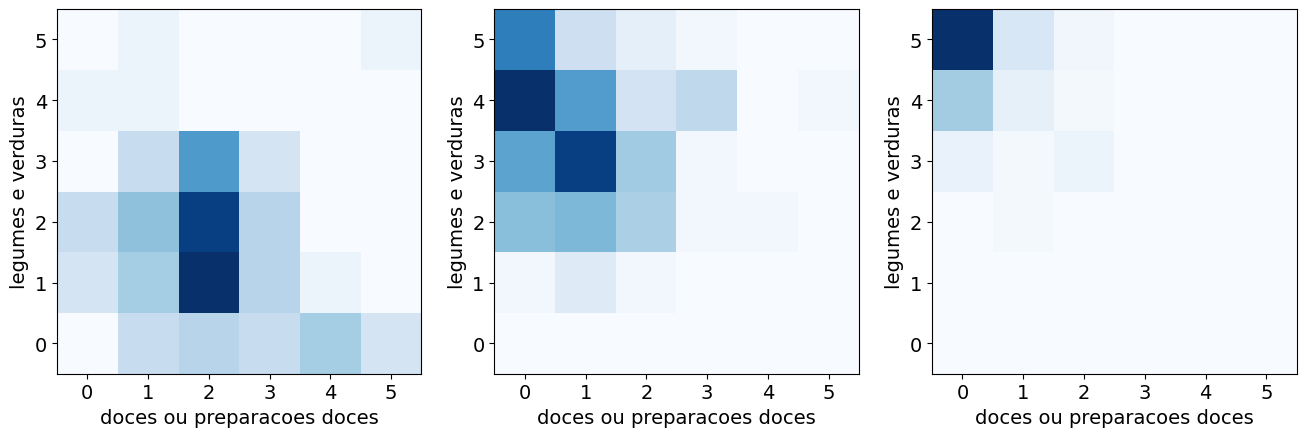

---------------------------------------------------------------------------------------------------------------------


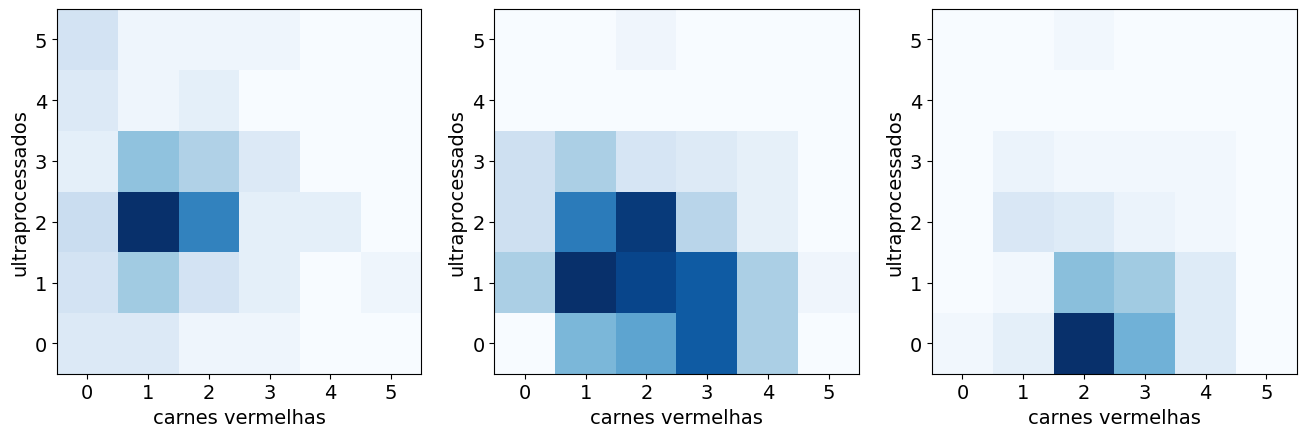

---------------------------------------------------------------------------------------------------------------------


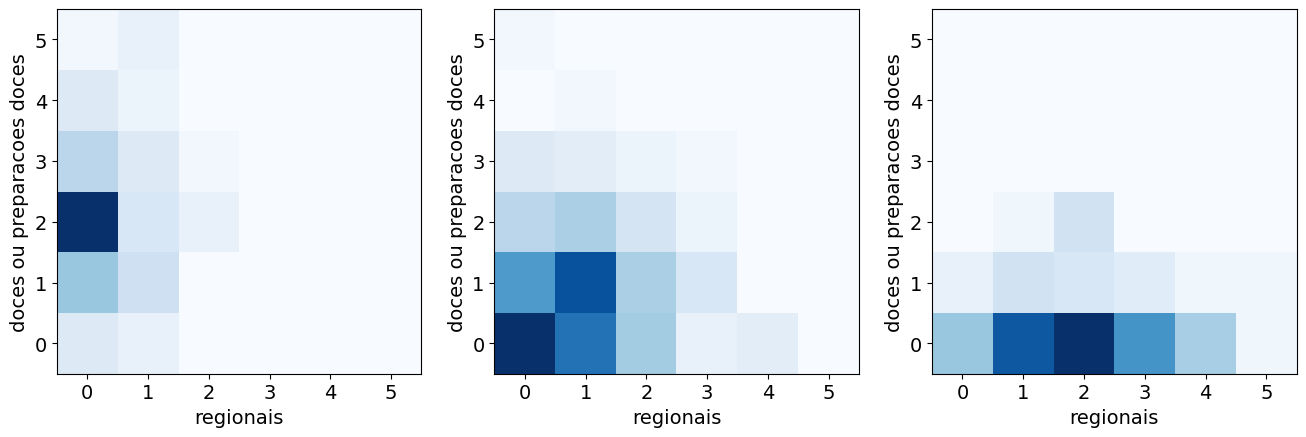

---------------------------------------------------------------------------------------------------------------------


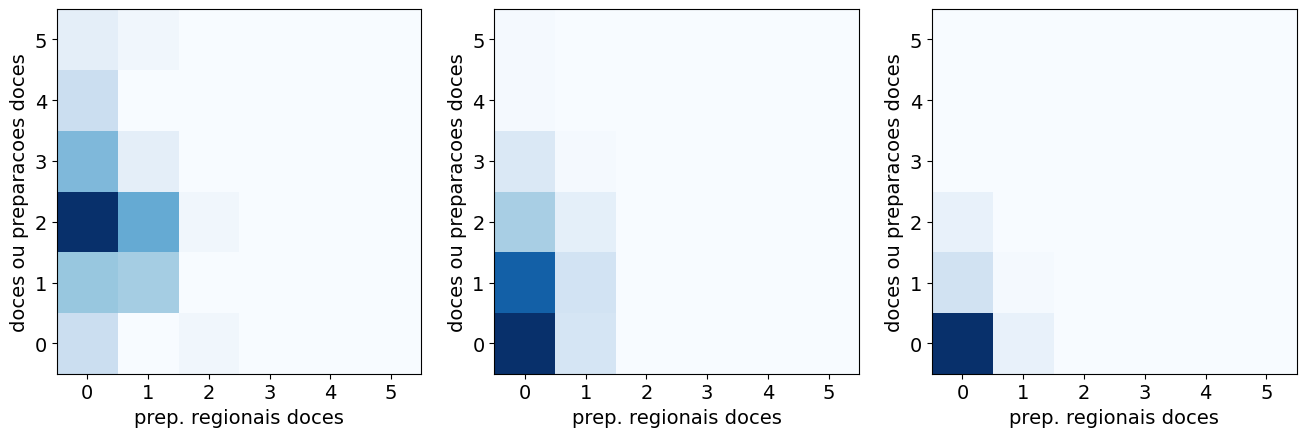

---------------------------------------------------------------------------------------------------------------------


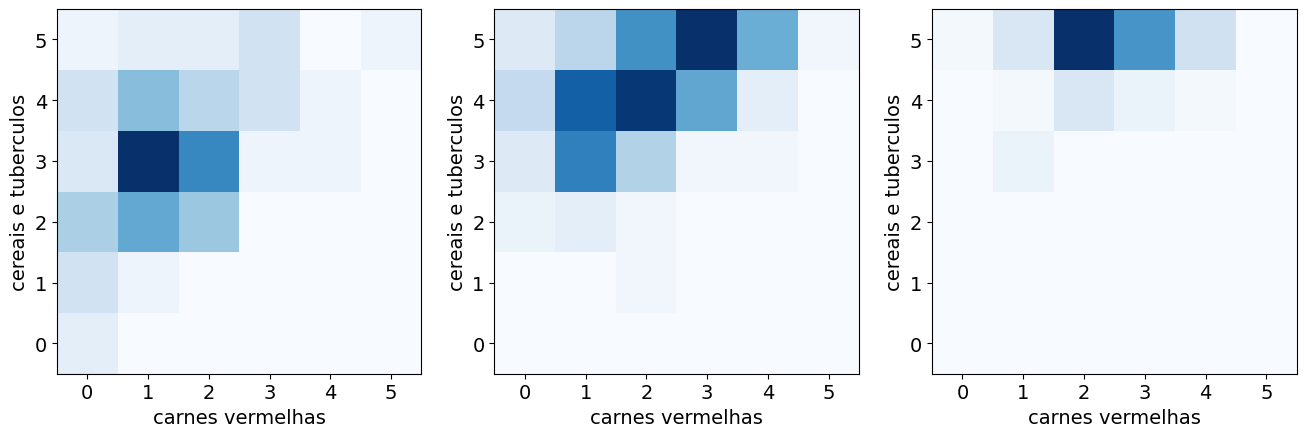

---------------------------------------------------------------------------------------------------------------------


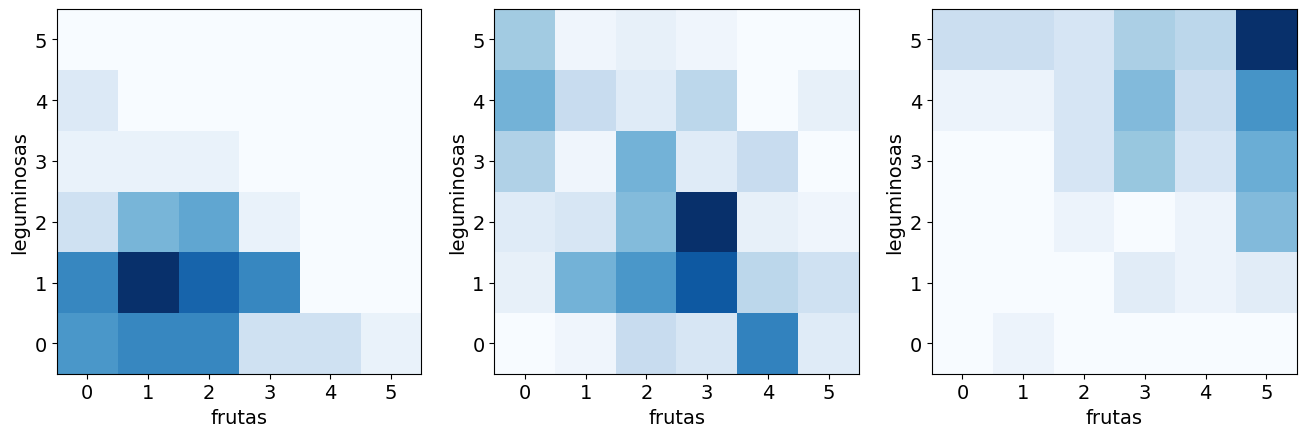

---------------------------------------------------------------------------------------------------------------------


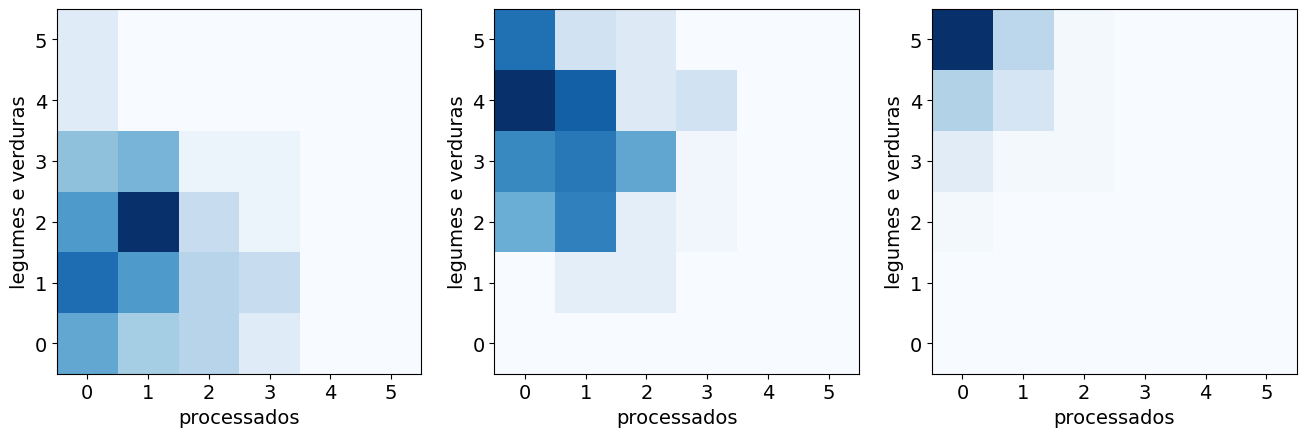

---------------------------------------------------------------------------------------------------------------------


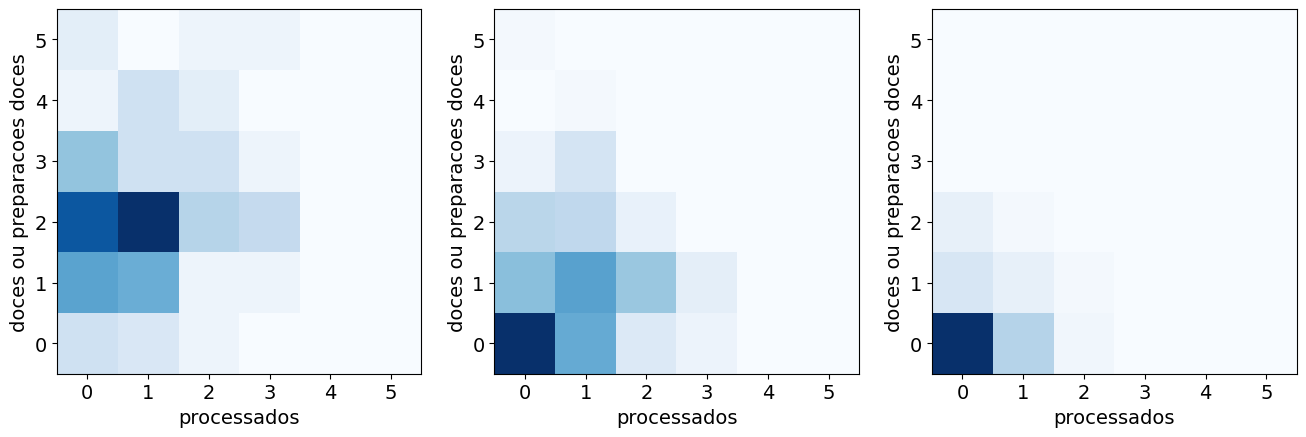

---------------------------------------------------------------------------------------------------------------------


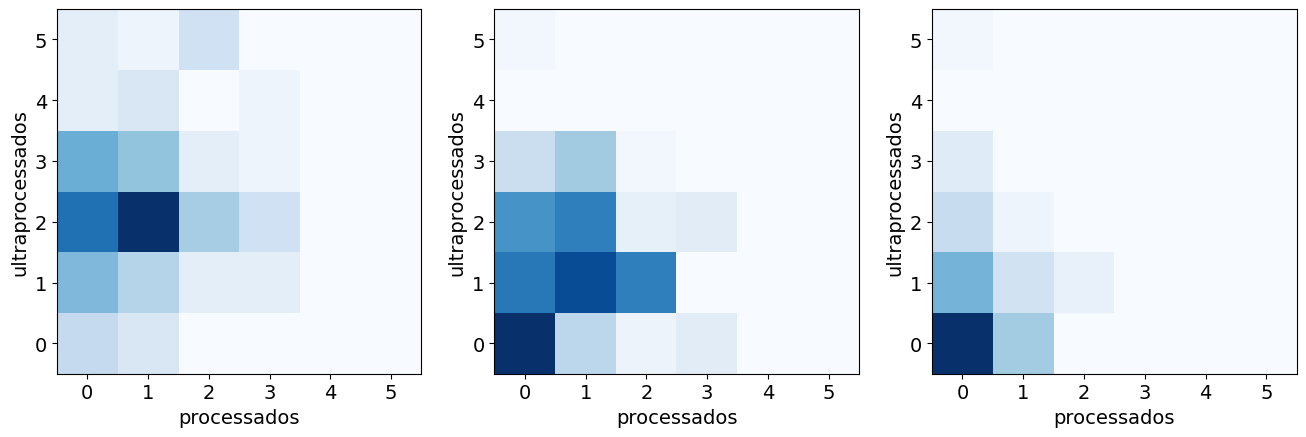

---------------------------------------------------------------------------------------------------------------------


In [ ]:
probability = {}
probability_med = {}
max_probability = {}
values = {}
values_med = {}
values_escore = {}
values_front  = {}
probability_front = {}
probability_down = {}
values_down = {}
alimentos_por_pares  ={}
front = {}
for item in lista:
   idx1 = item[0]
   idx2 = item[1]
   alimentos = [[[[],[]],[[],[]],[[],[]],[[],[]],[[],[]],[[],[]]],    [[[],[]],[[],[]],[[],[]],[[],[]],[[],[]],[[],[]]],   [[[],[]],[[],[]],[[],[]],[[],[]],[[],[]],[[],[]]],   [[[],[]],[[],[]],[[],[]],[[],[]],[[],[]],[[],[]]],   [[[],[]],[[],[]],[[],[]],[[],[]],[[],[]],[[],[]]], [[[],[]],[[],[]],[[],[]],[[],[]],[[],[]],[[],[]]]]
   probability[idx1, idx2] = []
   probability_med[idx1, idx2] = []
   values[idx1, idx2] = []
   values_escore[idx1,idx2] = []
   values_front[idx1, idx2] = []
   probability_front[idx1, idx2] = []
   probability_down[idx1, idx2] = []
   values_down[idx1, idx2] = []
   pc = np.zeros((6,6))
   pc_up = np.zeros((6,6))
   pc_down = np.zeros((6,6))
   pc_med = np.zeros((6,6))
   escore_medio = np.zeros((6,6))
   pareto = np.zeros((6,6))

   if idx1 < 14:
    for i in range(up1.shape[0]):
      alimentos[up1[i,idx1]][ up1[i,idx2]][0].append(alimentos_por_componente[i][idx1])

   if idx2 < 14:
     for i in range(up1.shape[0]):
      alimentos[up1[i,idx1]][ up1[i,idx2]][1].append(alimentos_por_componente[i][idx2])
   for i in range(y_train_sorted.shape[0]):
      pc[y_train_sorted[i,idx1], y_train_sorted[i,idx2]]+=1

   for i in range(up1.shape[0]):
      pc_up[up1[i,idx1], up1[i,idx2]]+=1
      escore_medio[up1[i,idx1], up1[i,idx2]]+=up_escore[i]
   alimentos_por_pares[idx1, idx2]  = alimentos
   for i in range(down2.shape[0]):
      pc_down[down2[i,idx1], down2[i,idx2]]+=1
   for i in range(med.shape[0]):
      pc_med[med[i,idx1], med[i,idx2]]+=1
   pc_down_up = pc_down - pc_up
   pc_up_down = pc_up - pc_down
   pc_up_down[pc_up_down<0] = 0
   pc_down_up[pc_down_up < 0] = 0
   escore_medio[pc_up_down==0] = 0
   pc_up_down = pc_up_down/np.sum(pc_up_down)
   pc_down_up = pc_down_up/np.sum(pc_down_up)
   pc_up = pc_up/up1.shape[0]
   pc_med = pc_med/med.shape[0]
   pp = pc_up.copy()
   pp[pp==0] = 1
   escore_medio = escore_medio/pp
   items = {}
   items[0,0] = [pc_up_down[0,0], escore_medio[0,0]]
   for k in range(6):
      for m in range(6):
         if (k,m) not in items.keys() and pc_up_down[k,m] > 0:
           flag = 0
           for n in items.keys():
               if items[n][0] < pc_up_down[k,m] and items[n][1] < escore_medio[k,m] and flag==0:

                  flag = -1
               if items[n][0] > pc_up_down[k,m] and items[n][1] > escore_medio[k,m]:
                  flag = -2
           if flag==0:
                items[k,m] = [pc_up_down[k,m], escore_medio[k,m]]
           if flag ==-1:
             del items[n]
             items[k,m] = [pc_up_down[k,m], escore_medio[k,m]]
   for d in items.keys():
      pareto[d[0], d[1]] = items[d ][0]
   pc_down = pc_down/down2.shape[0]
   pc = pc/y_train_sorted.shape[0]
   max_probability[idx1, idx2] = [0,1,pc_up_down[0,1]]

   for i in range(pc_up.shape[0]):
     for j in range(pc_up.shape[1]):
        if pc_up_down[i,j] >0:
          if pc_up_down[i,j] > max_probability[idx1,idx2][2]:
              max_probability[idx1, idx2] = [i,j,pc_up_down[i,j]]
          probability[idx1,idx2].append([i,j])
          values[idx1, idx2].append(pc_up[i,j])
          values_escore[idx1, idx2].append(escore_medio[i,j])
        if pc_down_up[i,j] > 0:
          probability_down[idx1, idx2].append([i,j])
          values_down[idx1, idx2].append(pc_up[i,j])
   for i in range(pareto.shape[0]):
     for j in range(pareto.shape[1]):
        if pc_up_down[i,j] >0:
          probability_front[idx1,idx2].append([i,j])
          values_front[idx1, idx2].append(pareto[i,j])

   fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16, 16))
   ax1.imshow(pc_down, cmap='Blues')
   ax2.imshow(pc_med, cmap='Blues')
   ax3.imshow(pc_up, cmap='Blues')

   max1 = np.max(pc_down)
   max2 = np.max(pc_med)
   max3 = np.max(pc_up)

   ax1.invert_yaxis()
   ax1.set_xticks([0,1,2,3,4,5])
   ax2.invert_yaxis()
   ax2.set_xticks([0,1,2,3,4,5])
   ax3.invert_yaxis()
   ax3.set_xticks([0,1,2,3,4,5])

   ax1.set_yticks([0,1,2,3,4,5])
   ax2.set_yticks([0,1,2,3,4,5])
   ax3.set_yticks([0,1,2,3,4,5])

   plt.rcParams.update({'font.size': 14})

   ax1.set_ylabel(componentes[idx1])
   ax1.set_xlabel(componentes[idx2])
   ax2.set_xlabel(componentes[idx2])
   ax2.set_ylabel(componentes[idx1])
   ax3.set_xlabel(componentes[idx2])
   ax3.set_ylabel(componentes[idx1])
   #ax1.set_title('low score')
   #ax2.set_title('medium score')
   #ax3.set_title('high score')
   fig.canvas.draw()
   extent = ax3.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())
   #extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
   plt.savefig(f'/content/figuras_por/high_{componentes[idx1]}_{componentes[idx2]}.png'.replace(' ', '_'),format='png', dpi=300, bbox_inches=extent)
   plt.show()
   print('---------------------------------------------------------------------------------------------------------------------')
   #print("score")



In [ ]:
!mkdir saida
!zip -r /content/saida/figuras_por.zip /content/figuras_por

  adding: content/figuras_por/ (stored 0%)
  adding: content/figuras_por/low_legumes_e_verduras_carnes_vermelhas.png (deflated 22%)
  adding: content/figuras_por/high_leites_e_derivados_ultraprocessados.png (deflated 24%)
  adding: content/figuras_por/high_frutas_compatibilidade_com_o_horario.png (deflated 23%)
  adding: content/figuras_por/med_cereais_e_tuberculos_prep._regionais_doces.png (deflated 21%)
  adding: content/figuras_por/low_prep._regionais_doces_compatibilidade_com_o_horario.png (deflated 21%)
  adding: content/figuras_por/high_leguminosas_frutas.png (deflated 25%)
  adding: content/figuras_por/high_cereais_e_tuberculos_sociobiodiversidade.png (deflated 21%)
  adding: content/figuras_por/high_frutas_carnes_vermelhas.png (deflated 25%)
  adding: content/figuras_por/low_frutas_leites_e_derivados.png (deflated 25%)
  adding: content/figuras_por/high_ultraprocessados_processados.png (deflated 23%)
  adding: content/figuras_por/med_cereais_e_tuberculos_leites_e_derivados.png 

In [ ]:
alimentos_por_pares

{(2, 3): [[[[], []], [[], []], [[], []], [[], []], [[], []], [[], []]],
  [[[], []], [[], []], [[], []], [[], []], [[], []], [[], []]],
  [[[], []],
   [[], []],
   [[], []],
   [[], []],
   [[['salada duo', 'agrião refogado']],
    [['maçã', 'melancia', 'banana', 'laranja.']]],
   [[], []]],
  [[[], []],
   [[], []],
   [[], []],
   [[], []],
   [[], []],
   [[['salada de alface',
      'file de tilápia ao molho tomate',
      'pimentão',
      'abóbora refogada',
      'salada'],
     ['salada de tomate', 'salada de alface', 'chuchu refogado'],
     ['tomate', 'legumes', 'cenoura'],
     ['peixe ensopado',
      'farofa de couve',
      'rúcula',
      'beterraba',
      'abóbora',
      'alface americana',
      'tomate',
      'pepino',
      'molho de tomate',
      'brócolis',
      'abobrinha'],
     ['abóbora', 'abóbora', 'abóbora'],
     ['abóbora', 'abóbora', 'abóbora'],
     ['abóbora', 'abóbora', 'abóbora'],
     ['repolho', 'tomate', 'couve', 'repolho refogado', 'pimentão'

Gerando uma tabela com o escore, o alimento e a sua frequencia com o escore.

# Treinar modelo para verificar similaridade com a base de dados real
Saída: mlp_model, ae_model

In [ ]:
from keras.layers import Dense, Dropout, Conv1D,  Activation, BatchNormalization, Add
from keras.layers import Input, Flatten, Concatenate
from keras.models import Model, load_model
from keras import layers
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling1D, MaxPooling2D, AveragePooling2D
import keras
from sklearn.base import BaseEstimator, TransformerMixin

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='/content/t.weights.h5',
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)

def mlp(input_size, nclasses, nb_filter=[64]):
     eps = 1.1e-5
     #input_vector = Input(input_size, dtype="int64")
     input_vector = Input(shape=(input_size,))
     x = Dense(nb_filter[0], name='mlp_conv1', use_bias=True)(input_vector)
     x = BatchNormalization(epsilon=eps)(x)
     x = Activation('relu', name='mlp_relu1')(x)

     x2 = Dropout(0.5)(x)
     x2 = Dense(nclasses, name="mlp_fc1")(x2)
     x2 = Activation('sigmoid', name='mlp_prob1')(x2)

     return Model(input_vector, x2, name='mlp_Recepi_conv')

target = [1 for i in range(y_train.shape[0])]
target = np.array(target)
target[106:] = 0
mlp_model = mlp(input_size = y_train.shape[1], nclasses=1,nb_filter = [64])#, lr = 1e-3, epochs = 50, batch_size = 8)
mlp_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["mse"])
mlp_model.summary()
mlp_model.fit(y_train, target,
                   batch_size=8,
                   epochs=100,
                   verbose=0,
                   callbacks = [model_checkpoint_callback ]
                   )
mlp_model.load_weights('/content/t.weights.h5')




Model: "mlp_Recepi_conv"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mlp_conv1 (Dense)               │ (None, 64)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mlp_relu1 (Activation)          │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mlp_fc1 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mlp_prob1 (Activation)          │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,281 (5.00 KB)

 Trainable params: 1,153 (4.50 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
from keras import backend as K
import keras

class autoencoder():

 def __init__(self, input_size=100, nb_filter = 16, lr = 1e-3, epochs = 1, batch_size = 8):
        self.input_size = input_size
        self.nb_filter = nb_filter
        self.lr = lr
        self.epochs = epochs
        self.model = None
        self.batch_size = batch_size
        self.vae = None
        self.latent_dim = 8

 def build(self):

   input = Input(self.input_size, dtype="int64")
   #encoder = Dense(2*self.nb_filter)(input)

   encoder = Dense(self.nb_filter)(input)
   z_mean =  Dense(self.latent_dim)(encoder)
   decoder = Dense(self.nb_filter)(encoder)

   #decoder = Dense(2*self.nb_filter)(decoder)
   decoder = Dense(self.input_size)(decoder)
   z_log_sigma = Dense(self.latent_dim)(encoder)

   output = Activation('sigmoid')(decoder)
   #reconstruction_loss = keras.losses.binary_crossentropy(input, output)
   reconstruction_loss = keras.losses.binary_crossentropy(input, output)
   reconstruction_loss *= self.input_size

   kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
   kl_loss = K.sum(kl_loss, axis=-1)

   kl_loss *= -0.5
   vae_loss = K.mean(reconstruction_loss + kl_loss)

   return Model(input, output), vae_loss

 def compile(self):
    self.model, loss = self.build()

    self.model.add_loss(loss)

    self.model.compile(optimizer='adam')#, loss='binary_crossentropy')

 def fit(self, X):
   self.model.fit(X, X, batch_size=self.batch_size, epochs = self.epochs, verbose=0)

 def summary(self):
   self.model.summary()

 def predict(self, X):
   out = self.model.predict(X, verbose=0)
   return out

Implementação Autoencoder

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

latent_dim = 8

encoder_inputs = keras.Input(shape=(14,))
x = layers.Dense(10)(encoder_inputs)
#x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
#x = layers.Flatten()(x)
#x = layers.Dense(8)(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 10)        │        150 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 8)         │         88 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 8)         │         88 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_3          │ (None, 8)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 326 (1.27 KB)

 Trainable params: 326 (1.27 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(10)(latent_inputs)
#x = layers.Reshape((7, 7, 64))(x)
#x = layers.Dense(8)(x)
#x = layers.Dense(10)(x)
decoder_outputs = layers.Dense(14, activation="sigmoid")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │            90 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 14)             │           154 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244 (976.00 B)

 Trainable params: 244 (976.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [ ]:

#ae = autoencoder(14, 4, epochs=800, batch_size=16)
ae = VAE(encoder, decoder)
ae.compile(optimizer=keras.optimizers.Adam())
y_train1 = (5 - up1.copy())/5
ae.fit(y_train1, epochs=800, batch_size=16)
#res = ae.predict((5-y_train)/5)
z_mean_, z_log_var_, z = encoder.predict((5-y_train)/5)
res = decoder.predict(z)
print(res)
mse1 = np.mean(np.power((5-y_train) - res*5, 2), axis=1)
denominador = np.max(mse1)
mse1 = mse1/denominador


res2_mlp = mlp_model.predict(y_train, verbose=0)
mlp_res = [i[0] for i in res2_mlp]
df_sorted['IIA_regression'] = mlp_res
df_sorted['IIA_reconstruction'] = mse1

df_objective = df_sorted[['IC', 'IEP', 'IE', 'IIA_regression', 'IIA_reconstruction', 'IDM']]
df_objective



Epoch 1/800
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - kl_loss: 3.5747 - loss: 17.3121 - reconstruction_loss: 13.7374
Epoch 2/800
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - kl_loss: 2.5535 - loss: 15.9563 - reconstruction_loss: 13.4027 
Epoch 3/800
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - kl_loss: 1.8490 - loss: 14.3391 - reconstruction_loss: 12.4901  
Epoch 4/800
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - kl_loss: 1.4104 - loss: 13.9287 - reconstruction_loss: 12.5183 
Epoch 5/800
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - kl_loss: 1.0826 - loss: 12.8647 - reconstruction_loss: 11.7821  
Epoch 6/800
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - kl_loss: 0.8658 - loss: 12.4924 - reconstruction_loss: 11.6266 
Epoch 7/800
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - kl_loss: 0.7291 - loss: 12.1871 - reconstruction_loss: 11.4580 
Epoch 8/800
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - kl_loss: 0.6264 - loss: 11.9180 - reconstruction_loss: 11.2916  
Epoch 9/800
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - kl_loss: 0.5620 - loss: 11.

IC   IEP   IE  IIA_regression  IIA_reconstruction        IDM
266  0.969231   6.0  9.0    9.978445e-01            0.073170  18.254717
361  0.830769  28.0  8.0    9.932656e-01            0.188012  16.254717
319  0.907692   8.0  7.0    9.959208e-01            0.119875  15.254717
229  1.000000   4.0  7.0    9.931108e-01            0.084859  14.254717
211  0.861538  23.0  6.0    9.889504e-01            0.272996  14.254717
..        ...   ...  ...             ...                 ...        ...
66   0.923077   1.0  6.0    8.312109e-09            0.727263  61.745283
99   0.815385   0.0  7.0    1.225568e-09            0.698933  61.745283
391  0.907692   7.0  5.0    3.467815e-11            0.935940  65.745283
209  0.953846  11.0  1.0    7.014883e-12            1.000000  67.745283
240  0.800000   8.0  3.0    5.737769e-11            0.862407  67.745283

[425 rows x 6 columns]

In [ ]:
df_up = df_objective[:106]
df_med = df_objective[106:318]
df_down = df_objective[318:]

Salvar o resultado dos dados originais

In [ ]:
original_data = []
for i in range(y_train.shape[0]):
#for i in range(106):
   hist = [0 for j in range(6)]
   for j in range(y_train.shape[1]):
      hist[y_train[i,j]] +=1
   new_fv, conf, inr = recepi_revision(lista_alimentos_original[i], componentes_de_avaliacao, reg[i], estado[i])
   new_fv3 = new_fv.copy()
   new_fv3 = new_fv3 - 5
   new_fv3[new_fv3<0] = 0
   excesso = np.sum(new_fv3)
   val = y_train[i] - new_fv
   val[val < 0] = 0
   print(i, y_train[i], new_fv, alimentos_nao_reconhecidos[i], np.sum(y_train_distribution[i]))
   alternativos, conflitos, erro = check_recepi(lista_alimentos_original[i], componentes_de_avaliacao, y_train[i], new_fv, deactive, reg[i], estado[i])
   print(len(alternativos), indiceILACC[i], len(conflitos), excesso)
   #extra_original.append(excesso)
   #data.append([indiceILAC0[i], indiceILACC[i], excesso, lista_alimentos_original[i], 1])
   res = compute_region(lista_alimentos_original[i])
   reg_norte.append(res[' Norte'])
   reg_nordeste.append(res[' Nordeste'])
   reg_centroeste.append(res[' Centroeste'])
   reg_sudeste.append(res[' Sudeste'])
   reg_sul.append(res[' RegSul'])
   original_data.append([cidade[i], est[i], erro,len(alternativos), excesso, np.sum(y_train_distribution[i]), fabs(target[i] - high_score_mean), hist[0], hist[5], lista_alimentos_original[i], y_train[i], 1, evaluation[i], reg_norte[-1], reg_nordeste[-1],reg_sudeste[-1],reg_sul[-1], reg_centroeste[-1]])
   ilac_1.append(erro)
   excesso_1.append(excesso)

0 [5 5 5 5 3 2 0 0 2 0 1 1 1 0] [7. 5. 9. 5. 3. 2. 0. 1. 2. 0. 2. 1. 1. 0.] [] 9
0 0 1 6.0
1 [5 5 5 5 3 3 0 2 2 0 1 5 0 0] [12.  5. 10. 15.  3.  3.  5.  8.  2.  0.  3.  8.  1.  0.] ['com requeijão'] 7
0 0 2 28.0
2 [5 5 5 3 5 1 0 0 2 0 0 4 1 0] [8. 6. 9. 4. 5. 1. 1. 2. 2. 0. 0. 5. 2. 0.] ['azeite', 'cheiro verde', 'azeite', 'cheiro verde', 'sobremesa'] 9
0 0 6 8.0
3 [5 5 5 5 3 0 0 0 2 0 0 4 0 0] [7. 5. 7. 5. 3. 0. 0. 0. 2. 0. 0. 4. 0. 0.] ['cheiro verde', 'cheiro verde', 'cheiro verde', 'cheiro verde'] 7
0 0 0 4.0
4 [5 5 5 5 3 0 0 1 3 0 2 4 0 5] [10.  9. 16.  6.  5.  0.  2.  3.  3.  0.  3.  7.  1.  0.] ['isca', 'cebola', 'azeite'] 5
0 0 10 23.0
5 [5 5 5 5 3 0 0 0 3 0 1 3 1 0] [ 9.  7. 11.  5.  4.  1.  2.  2.  4.  0.  1.  3.  1.  0.] [] 6
0 0 8 12.0
6 [5 4 5 5 3 0 0 0 2 0 0 3 0 0] [ 8.  4. 18.  5.  4.  1.  1.  0.  2.  0.  0.  4.  0.  0.] [] 7
0 0 3 16.0
7 [5 4 5 4 3 0 0 0 2 0 0 3 1 0] [8. 5. 5. 4. 3. 0. 1. 1. 2. 0. 0. 3. 1. 0.] ['peito'] 8
0 0 5 3.0
8 [5 4 5 5 3 1 0 0 2 0 0 1 0 0] [ 8.  

# Define a Função para extração de métricas de avaliação


In [ ]:
def metric_extraction(mlp_model, ae_model, regression_model, new_sample, lista_de_alimentos):
   #new_fv, conf, inr = recepi_revision(lista_de_alimentos, componentes_de_avaliacao, None, None)
   hist = [0 for j in range(6)]
   new_fv, conf, inr = recepi_revision(lista_de_alimentos, componentes_de_avaliacao, None, None)
   new_fv2 = new_fv.copy()
   new_fv3 = new_fv.copy()
   new_fv3 = new_fv3 - 5
   new_fv3[new_fv3<0] = 0
   excesso = np.sum(new_fv3)
   new_fv[new_fv>5] = 5

   alternativos, conflitos, erro = check_recepi(lista_de_alimentos, componentes_de_avaliacao, new_sample,new_fv, deactive, None, None)
   adjusted_sample = np.maximum(new_sample, new_fv)
   #x_test.append(adjusted_sample)
   for j in range(adjusted_sample.shape[0]):
      hist[int(adjusted_sample[j])] +=1
   res = regressor.predict([adjusted_sample])
   total_s = res[0]*(maximum-minimum) + minimum
   res[0] = fabs(res[0]*(maximum-minimum) + minimum - high_score_mean)
   #y_pred = mlp_model.predict(adjusted_sample.reshape(1,adjusted_sample.shape[0]))
   equilibrio = adjusted_sample.copy()
   penalizacao = penalty_values - equilibrio
   equilibrio[equilibrio>0] = 1
   equilibrio[penalizacao<0] = -1
   #print(new_sample)
   res2_mlp = mlp_model.predict(np.array([new_sample]), verbose=0)
   #print('ok1')
   z_mean, z_log_var, z = encoder.predict((5-np.array([new_sample]))/5, verbose=0)
   res_ae = decoder.predict(z, verbose=0)
   #res_ae = ae.predict((5-np.array([new_sample]))/5)
   #print('ok2')
   mse2 = np.mean(np.power((5-np.array(new_sample)) - res_ae*5, 2), axis=1)
   mse2 = mse2/denominador
   region = compute_region(lista_de_alimentos)
   return total_s, [erro, excesso, np.sum(equilibrio), res2_mlp[0][0], mse2[0], res[0]], region

# Gerando 100 componentes de avaliação sem restrição
output: lista de 1000 amostras contendo os valores dos componentes de avaliação (new_samples3), lista de 1000 amostras contendo as combinações feitas (combina)

In [ ]:
def create_recepi(ss, combina, keys, lista2, rem_list, cont): #### funcao para criar listas de alimentos do inicio ou de uma lista parcialmente preenchida
  #rem_list = [i for i in range(len(keys))]
  #cont = 0
  cont2 = 0
  prob = 0.9
  tentativas = 0
  while np.min(ss) < 0 and tentativas < 5000:

     idx = random.choice(rem_list)

     rem_list.remove(idx)
     c = choices(probability[keys[idx][0],keys[idx][1]], values[keys[idx][0],keys[idx][1]])[0]
     if ss[keys[idx][0]] < 0 and ss[keys[idx][1]] <0:
       ss[keys[idx][0]] = c[0]
       ss[keys[idx][1]] = c[1]
       flag=1

       combina[keys[idx][0]] = keys[idx]
       combina[keys[idx][1]] = keys[idx]
       lista2[keys[idx][0]] = alimentos_por_pares[keys[idx][0],keys[idx][1]][c[0]][c[1]][0]
       lista2[keys[idx][1]] = alimentos_por_pares[keys[idx][0],keys[idx][1]][c[0]][c[1]][1]
     else:
       if cont <=400:
          ind = random.randrange(0,100)/100
          if ind < 0.5:

             flag = 0
             if ss[keys[idx][0]] < 0:
              id = combina[keys[idx][1]]
              flag = 1
             if ss[keys[idx][1]] < 0:
              id = combina[keys[idx][0]]
              flag = 1
             if flag==1:
               cont+=1
               ss[id[0]] = -1
               ss[id[1]] = - 1
               if keys[idx][0] in combina.keys():
                 del combina[keys[idx][0]]
               if keys[idx][1] in combina.keys():
                 del combina[keys[idx][1]]
             else:
               cont+=1
               id = combina[keys[idx][1]]
               ss[id[0]] = -1
               ss[id[1]] = - 1
               id = combina[keys[idx][0]]
               ss[id[0]] = -1
               ss[id[1]] = - 1
               del combina[keys[idx][0]]
               del combina[keys[idx][1]]
             ss[keys[idx][0]] = c[0]
             ss[keys[idx][1]] = c[1]
             combina[keys[idx][0]] = keys[idx]
             combina[keys[idx][1]] = keys[idx]
             lista2[keys[idx][0]] = alimentos_por_pares[keys[idx][0],keys[idx][1]][c[0]][c[1]][0]
             lista2[keys[idx][1]] = alimentos_por_pares[keys[idx][0],keys[idx][1]][c[0]][c[1]][1]
       else:
         if cont2 < 400:
           cont2+=1
         else:
            #print('erro')
            if ss[keys[idx][0]] < 0:
              ss[keys[idx][0]] = c[0]
              combina[keys[idx][0]] = keys[idx]
              lista2[keys[idx][0]] = alimentos_por_pares[keys[idx][0],keys[idx][1]][c[0]][c[1]][0]
            if ss[keys[idx][1]] < 0:
              ss[keys[idx][1]] = c[1]
              combina[keys[idx][1]] = keys[idx]
              lista2[keys[idx][1]] = alimentos_por_pares[keys[idx][0],keys[idx][1]][c[0]][c[1]][1]
     if len(rem_list) < 1:
         rem_list = [i for i in range(len(keys))]

     prob-=0.01
     tentativas+=1
  if (np.min(ss) < 0):
    return 0
  ff = [[] for i in range(14)]
  bitset = np.zeros(14)
  bitset = bitset-1

  for i in range(13):
   if bitset[i]==-1:
    k = int(ss[i])
    flag = 0
    for j in range(i+1, 14,1):


      if combina[i] == combina[j]:
         flag = 1
         n = j
         bitset[n] = 1

    if k >0 and len(lista2[i])==0:

      print('erro, sem alimentos', i, lista2[i])
    else:
      if len(lista2[i])>0:
       idx  = random.randint(0,len(lista2[i])-1)
       idx  = random.randint(0,len(lista2[i])-1)

       if flag ==1:
         #print(combina[i],combina[n], len(lista2[i]), len(lista2[n]))
         ff[i] = lista2[i][idx]
         ff[n] = lista2[n][idx]
       else:
         ff[i] = lista2[i][idx]
      ### pos processamento : remover alimentos duplicados de componentes diferentes
  for i in range(12):
       for j in range(i+1, 13, 1):
           for k in ff[i]:
              if k in ff[j]:
                 ff[j].remove(k)

  return ss, combina, ff

In [ ]:

import statistics
from statistics import mode

new_samples3 = np.zeros((100, 14))
metrics = []
escore = []
combinations = []
#new_samples3 = new_samples3 + 100
from random import choices
import random
keys = probability.keys()
keys = list(keys)
lista_de_alimentos = []
storage_keys = []
#print(keys)
reg_sul= []
reg_norte = []
reg_nordeste = []
reg_centroeste = []
reg_sudeste = []
for i in range(100):
  print(f'cardapio {i}')
  ss = np.zeros(14)
  ss[ss>=0] = -1
  comp = {}
  #c_values = {}
  prob = 0.9
  lista2 = {}
  combina = {}
  rem_list = [i for i in range(len(keys))]
  cont = 0
  res = 0
  while res == 0:
     res = create_recepi(ss, combina, keys, lista2, rem_list, cont)
  #ss, combina, ff = create_recepi(ss, combina, keys, lista2, rem_list, cont)
  ss, combina, ff = res
  new_samples3[i] = ss.copy()
  combinations.append(combina)
  lista_de_alimentos.append(ff)
  total_s, ext, regions = metric_extraction(mlp_model, ae, regressor, ss, ff)
  metrics.append(ext)
  reg_sul.append(regions[' RegSul'])
  reg_norte.append(regions[' Norte'])
  reg_nordeste.append(regions[' Nordeste'])
  reg_sudeste.append(regions[' Sudeste'])
  reg_centroeste.append(regions[' Centroeste'])
  escore.append(total_s)

cardapio 0
cardapio 1
cardapio 2
cardapio 3
cardapio 4
cardapio 5
cardapio 6
cardapio 7
cardapio 8
cardapio 9
cardapio 10
cardapio 11
cardapio 12
cardapio 13
cardapio 14
cardapio 15
cardapio 16
cardapio 17
cardapio 18
cardapio 19
cardapio 20
cardapio 21
cardapio 22
cardapio 23
cardapio 24
cardapio 25
cardapio 26
cardapio 27
cardapio 28
cardapio 29
cardapio 30
cardapio 31
cardapio 32
cardapio 33
cardapio 34
cardapio 35
cardapio 36
cardapio 37
cardapio 38
cardapio 39
cardapio 40
cardapio 41
cardapio 42
cardapio 43
cardapio 44
cardapio 45
cardapio 46
cardapio 47
cardapio 48
cardapio 49
cardapio 50
cardapio 51
cardapio 52
cardapio 53
cardapio 54
cardapio 55
cardapio 56
cardapio 57
cardapio 58
cardapio 59
cardapio 60
cardapio 61
cardapio 62
cardapio 63
cardapio 64
cardapio 65
cardapio 66
cardapio 67
cardapio 68
cardapio 69
cardapio 70
cardapio 71
cardapio 72
cardapio 73
cardapio 74
cardapio 75
cardapio 76
cardapio 77
cardapio 78
cardapio 79
cardapio 80
cardapio 81
cardapio 82
cardapio 83
ca

 - new_samples3 (vetor com amostras contendo os valores dos componentes de avaliação)
 - Combinations (vetor com as combinações feitas para obter os valores dos componentes de avaliação)
 - probability (Para cada combinação, existe uma lista de pares com os possiveis valores)

In [ ]:

print(combinations)


[{11: (11, 13), 9: (5, 9), 13: (11, 13), 1: (1, 6), 12: (4, 12), 4: (4, 12), 5: (5, 9), 0: (0, 8), 8: (0, 8), 6: (1, 6), 3: (3, 10), 10: (3, 10), 2: (2, 7), 7: (2, 7)}, {11: (1, 11), 13: (10, 13), 7: (7, 9), 1: (1, 11), 0: (0, 6), 6: (0, 6), 9: (7, 9), 8: (5, 8), 10: (10, 13), 2: (2, 12), 12: (2, 12), 5: (5, 8), 3: (3, 4), 4: (3, 4)}, {10: (3, 10), 5: (4, 5), 3: (3, 10), 2: (1, 2), 0: (0, 11), 11: (0, 11), 1: (1, 2), 4: (4, 5), 7: (7, 8), 8: (7, 8), 12: (12, 13), 13: (12, 13), 6: (6, 9), 9: (6, 9)}, {5: (5, 9), 4: (4, 13), 9: (5, 9), 1: (1, 6), 13: (4, 13), 2: (2, 8), 8: (2, 8), 6: (1, 6), 12: (3, 12), 3: (3, 12), 0: (0, 11), 11: (0, 11), 7: (7, 10), 10: (7, 10)}, {2: (2, 3), 13: (12, 13), 3: (2, 3), 12: (12, 13), 11: (4, 11), 4: (4, 11), 5: (5, 10), 10: (5, 10), 9: (7, 9), 7: (7, 9), 1: (1, 6), 6: (1, 6), 0: (0, 8), 8: (0, 8)}, {5: (4, 5), 8: (7, 8), 4: (4, 5), 7: (7, 8), 1: (1, 2), 2: (1, 2), 10: (10, 13), 13: (10, 13), 0: (0, 3), 3: (0, 3), 11: (11, 12), 12: (11, 12), 6: (6, 9), 9: 

Inicio Otimizacao multiobjetivo

In [ ]:
def repair_offspring_and_savedf(offspring, gen):

    prob_troca = 0.5
    new_samples = np.zeros((len(offspring), 14))
    metrics = []
    escore = []
    regions = {}
    regions['reg_sul'] = []
    regions['reg_norte'] = []
    regions['reg_nordeste'] = []
    regions['reg_centroeste'] = []
    regions['reg_sudeste'] = []
    combinations = []
    lista_de_alimentos_1 = []
    for ind in range(len(offspring)):   ## cria lista de pares que não existem informação mútua

        #print( f'repairing recepi n {ind}')
        ## verifica se ocorreu mutacao
        flag = 0
        ss = [-1 for i in range(14)]  ## montar os componentes de avaliação
        combina = {}
        rem_list = [i for i in range(len(keys))]
        data = np.array([-1 for i in range(14)])
        lista2 = {}
        mutation = 0
        for i in offspring[ind]:
          #print(ind, i)
            if i[0] in keys:
              if data[i[0][0]] <0 and data[i[0][1]] <0:
                 combina[i[0][0]] = i[0]
                 combina[i[0][1]] = i[0]
                 data[i[0][0]] = offspring[ind][i[0][0]][1]
                 data[i[0][1]] = offspring[ind][i[0][1]][1]
              else:
                 prob = random.randrange(0,100)/100
                 if prob < prob_troca or i[2]==1:

                   if i[0][0] in combina.keys() and i[0][1] in combina.keys():
                      value = combina[i[0][0]]
                      value2 = combina[i[0][1]]
                      if value[0] in combina.keys():
                        del combina[value[0]]
                      if value[1] in combina.keys():
                        del combina[value[1]]
                      if value2[0] in combina.keys():
                        del combina[value2[0]]
                      if value2[1] in combina.keys():
                        del combina[value2[1]]
                      data[value[0]] = -1
                      data[value[1]] = -1
                      data[value2[0]] = -1
                      data[value2[1]] = -1
                      combina[i[0][0]] = i[0]
                      combina[i[0][1]] = i[0]
                      if i[2]==1:
                        i[2] = 0
                        mutation = 1
                        c = choices(probability[i[0][0],i[0][1]], values[i[0][0],i[0][1]])[0]
                        data[i[0][0]] = c[0]
                        data[i[0][1]] = c[1]
                      else:

                        data[i[0][0]] = offspring[ind][i[0][0]][1]
                        data[i[0][1]] = offspring[ind][i[0][1]][1]
                   else:
                     if i[0][0] in combina.keys():
                       value = combina[i[0][0]]
                       if value[0] in combina.keys():
                          del combina[value[0]]
                       if value[1] in combina.keys():
                          del combina[value[1]]
                       data[value[0]] = -1
                       data[value[1]] = -1
                       combina[i[0][0]] = i[0]
                       combina[i[0][1]] = i[0]
                       if i[2]==1:
                          i[2] = 0
                          mutation = 1
                          c = choices(probability[i[0][0],i[0][1]], values[i[0][0],i[0][1]])[0]
                          data[i[0][0]] = c[0]
                          data[i[0][1]] = c[1]
                       else:
                          data[i[0][0]] = offspring[ind][i[0][0]][1]
                          data[i[0][1]] = offspring[ind][i[0][1]][1]
                     if i[0][1] in combina.keys():
                       value = combina[i[0][1]]
                       if value[0] in combina.keys():
                        del combina[value[0]]
                       if value[1] in combina.keys():
                        del combina[value[1]]
                       data[value[0]] = -1
                       data[value[1]] = -1
                       combina[i[0][0]] = i[0]
                       combina[i[0][1]] = i[0]
                       data[i[0][0]] = offspring[ind][i[0][0]][1]
                       data[i[0][1]] = offspring[ind][i[0][1]][1]
        #print(ind, data, combina)

        for i in combina.keys():
           lista2[combina[i][0]] = alimentos_por_pares[combina[i][0],combina[i][1]][data[combina[i][0]]][data[combina[i][1]]][0]
           lista2[combina[i][1]] = alimentos_por_pares[combina[i][0],combina[i][1]][data[combina[i][0]]][data[combina[i][1]]][1]
        for i in combina.keys():
          if combina[i] in rem_list:
            rem_list.remove(combina[i])
       # print(len(data), len(combina), len(rem_list), len(lista2), len(keys))
        #if mutation == 1:
        #  cont = 200
        #else:
        #  cont = 0
        cont = 0
        res = 0
        co = 0
        while res == 0 and co < 20:
           res = create_recepi(ss, combina, keys, lista2, rem_list, cont)
           co+=1
  #ss, combina, ff = create_recepi(ss, combina, keys, lista2, rem_list, cont)
        if co > 2:
          print('erro ', co)
          print(combina, ss, lista2)

        #res = create_recepi(data, combina, keys, lista2, rem_list, cont)
        new_data, combina, ff = res
        new_data = np.array(new_data)
        new_samples[ind] = new_data.copy()
        combinations.append(combina)
        lista_de_alimentos_1.append(ff)
        total_s, ext, sample_region = metric_extraction(mlp_model, ae, regressor, new_data, ff)
        metrics.append(ext)
        escore.append(total_s)
        regions['reg_sul'].append(sample_region[' RegSul'])
        regions['reg_norte'].append(sample_region[' Norte'])
        regions['reg_nordeste'].append(sample_region[' Nordeste'])
        regions['reg_centroeste'].append(sample_region[' Centroeste'])
        regions['reg_sudeste'].append(sample_region[' Sudeste'])



    list_data = {i:[] for i in range(14)}
    for i in range(len(combinations)):
      for j in combinations[i].keys():
        list_data[j].append([combinations[i][j], new_samples[i][j], 0])
    df = pd.DataFrame(list_data)
    df_obj = pd.DataFrame(metrics, columns = ['f1', 'f2','f3','f4','f5','f6'])
    return df, df_obj, lista_de_alimentos_1, new_samples, escore, regions




In [ ]:
#criando dataframe com as variaveis
data = {i:[] for i in range(14)}
for i in range(len(combinations)):
  for j in combinations[i].keys():
    data[j].append([combinations[i][j], new_samples3[i][j], 0])
df = pd.DataFrame(data)
df_obj = pd.DataFrame(metrics, columns = ['f1', 'f2','f3','f4','f5','f6'])
df_final2 = df_obj.copy()
df_final2.columns = ['IC', 'IEP', 'IE', 'IIA_regression', 'IIA_reconstruction', 'IDM']
df_final2['fv'] = [i for i in new_samples3]
df_final2['lista_de_alimentos'] = lista_de_alimentos
#df_final.to_excel('MOO_gen0.xlsx')
df_final2['TOTAL_S'] = escore
df_final2['Reg_sul'] = reg_sul
df_final2['Reg_norte'] = reg_norte
df_final2['Reg_nordeste'] = reg_nordeste
df_final2['Reg_sudeste'] = reg_sudeste
df_final2['Reg_centroeste'] = reg_centroeste
df_final_lambda = df_obj.copy()
df_final_lambda.columns = ['IC', 'IEP', 'IE', 'IIA_regression', 'IIA_reconstruction', 'IDM']
df_final_lambda['fv'] = [i for i in new_samples3]
df_final_lambda['lista_de_alimentos'] = lista_de_alimentos


In [ ]:
df_final2

IC   IEP   IE  IIA_regression  IIA_reconstruction        IDM  \
0   0.830769  14.0  8.0        0.980422            0.071527  17.622642   
1   0.800000   8.0  6.0        0.945112            0.080265   7.750311   
2   0.907692  15.0  7.0        0.989844            0.035834   0.579679   
3   0.815385  20.0  4.0        0.951539            0.031924   3.770515   
4   0.861538  15.0  7.0        0.988995            0.137201   9.265497   
..       ...   ...  ...             ...                 ...        ...   
95  0.923077  10.0  5.0        0.990446            0.044913  12.510384   
96  0.876923  17.0  5.0        0.985550            0.073233   8.645436   
97  0.892308  11.0  5.0        0.847789            0.053225   5.330317   
98  0.846154  10.0  4.0        0.954594            0.021341   7.996439   
99  0.892308   7.0  8.0        0.594461            0.077448   9.025531   

                                                   fv  \
0   [5.0, 5.0, 5.0, 5.0, 2.0, 0.0, 0.0, 1.0, 2.0, ...   
1   [5.0, 5.0, 3.0, 4.0, 3.0, 0.0, 1.0, 1.0, 2.0, ...   
2   [5.0, 4.0, 5.0, 5.0, 2.0, 0.0, 0.0, 0.0, 2.0, ...   
3   [5.0, 4.0, 4.0, 4.0, 2.0, 0.0, 0.0, 0.0, 1.0, ...   
4   [5.0, 4.0, 5.0, 3.0, 4.0, 0.0, 1.0, 0.0, 2.0, ...   
..                                                ...   
95  [5.0, 5.0, 5.0, 5.0, 2.0, 1.0, 0.0, 0.0, 2.0, ...   
96  [5.0, 3.0, 5.0, 5.0, 3.0, 0.0, 0.0, 0.0, 4.0, ...   
97  [5.0, 5.0, 5.0, 2.0, 3.0, 1.0, 0.0, 0.0, 3.0, ...   
98  [5.0, 4.0, 5.0, 4.0, 2.0, 0.0, 1.0, 0.0, 3.0, ...   
99  [5.0, 4.0, 5.0, 1.0, 3.0, 0.0, 0.0, 0.0, 2.0, ...   

                                   lista_de_alimentos    TOTAL_S   Reg_sul  \
0   [[arroz, risoto de carne moída, purê de abóbor...  77.367925  0.894737   
1   [[arroz, risoto de alho poró, macarrão, arroz,...  67.495594  0.727273   
2   [[arroz, arroz, sopa de feijão, macarrão, arro...  59.165604  0.857143   
3   [[arroz, batata, arroz, frango ensopado, macar...  63.515798  0.647059   
4   [[arroz, sopa de lentilha, batata, mandioca, a...  69.010780  0.777778   
..                                                ...        ...       ...   
95  [[tutu de feijão, macarrão ao molho, arroz bra...  72.255667  0.727273   
96  [[arroz colorido, milho, feijão tropeiro, fari...  68.390719  0.717949   
97  [[arroz, angu, arroz à grega, baião de tres, c...  65.075600  0.735294   
98  [[arroz, batata, arroz, arroz, arroz, batata d...  51.748844  0.885714   
99  [[arroz branco, arroz, farofa de repolho, arro...  50.719752  0.851852   

    Reg_norte  Reg_nordeste  Reg_sudeste  Reg_centroeste  
0    0.710526      0.684211     0.842105        0.631579  
1    0.848485      0.666667     0.848485        0.666667  
2    0.571429      0.514286     0.885714        0.514286  
3    0.617647      0.705882     0.882353        0.558824  
4    0.611111      0.666667     0.944444        0.638889  
..        ...           ...          ...             ...  
95   0.545455      0.696970     1.000000        0.606061  
96   0.769231      0.641026     1.000000        0.692308  
97   0.588235      0.647059     0.970588        0.617647  
98   0.800000      0.771429     1.000000        0.771429  
99   0.518519      0.555556     0.925926        0.555556  

[100 rows x 14 columns]

In [ ]:
alimentos_por_pares.keys()

dict_keys([(2, 3), (0, 3), (4, 8), (5, 9), (0, 1), (2, 13), (3, 6), (4, 5), (8, 9), (0, 9), (1, 3), (1, 12), (3, 7), (6, 11), (0, 2), (6, 12), (0, 7), (1, 7), (8, 12), (4, 10), (5, 6), (0, 4), (1, 11), (3, 10), (0, 6), (10, 13), (4, 11), (0, 13), (3, 12), (5, 13), (0, 11), (3, 5), (2, 9), (0, 8), (5, 8), (6, 7), (7, 10), (5, 10), (2, 12), (6, 9), (1, 2), (11, 12), (12, 13), (3, 4), (8, 13), (4, 12), (1, 8), (0, 12), (4, 13), (0, 10), (0, 5), (1, 6), (1, 4), (11, 13), (2, 7), (7, 8), (7, 9), (5, 7), (2, 8)])

In [ ]:
df

0                  1                  2   \
0    [(0, 8), 5.0, 0]   [(1, 6), 5.0, 0]   [(2, 7), 5.0, 0]   
1    [(0, 6), 5.0, 0]  [(1, 11), 5.0, 0]  [(2, 12), 3.0, 0]   
2   [(0, 11), 5.0, 0]   [(1, 2), 4.0, 0]   [(1, 2), 5.0, 0]   
3   [(0, 11), 5.0, 0]   [(1, 6), 4.0, 0]   [(2, 8), 4.0, 0]   
4    [(0, 8), 5.0, 0]   [(1, 6), 4.0, 0]   [(2, 3), 5.0, 0]   
..                ...                ...                ...   
95  [(0, 13), 5.0, 0]  [(1, 11), 5.0, 0]  [(2, 12), 5.0, 0]   
96  [(0, 12), 5.0, 0]  [(1, 11), 3.0, 0]  [(2, 13), 5.0, 0]   
97   [(0, 9), 5.0, 0]   [(1, 7), 5.0, 0]   [(2, 3), 5.0, 0]   
98   [(0, 5), 5.0, 0]   [(1, 2), 4.0, 0]   [(1, 2), 5.0, 0]   
99   [(0, 6), 5.0, 0]  [(1, 12), 4.0, 0]   [(2, 3), 5.0, 0]   

                   3                  4                  5   \
0   [(3, 10), 5.0, 0]  [(4, 12), 2.0, 0]   [(5, 9), 0.0, 0]   
1    [(3, 4), 4.0, 0]   [(3, 4), 3.0, 0]   [(5, 8), 0.0, 0]   
2   [(3, 10), 5.0, 0]   [(4, 5), 2.0, 0]   [(4, 5), 0.0, 0]   
3   [(3, 12), 4.0, 0]  [(4, 13), 2.0, 0]   [(5, 9), 0.0, 0]   
4    [(2, 3), 3.0, 0]  [(4, 11), 4.0, 0]  [(5, 10), 0.0, 0]   
..                ...                ...                ...   
95   [(3, 4), 5.0, 0]   [(3, 4), 2.0, 0]   [(5, 6), 1.0, 0]   
96   [(3, 7), 5.0, 0]  [(4, 10), 3.0, 0]   [(5, 6), 0.0, 0]   
97   [(2, 3), 2.0, 0]  [(4, 11), 3.0, 0]  [(5, 10), 1.0, 0]   
98   [(3, 7), 4.0, 0]  [(4, 10), 2.0, 0]   [(0, 5), 0.0, 0]   
99   [(2, 3), 1.0, 0]  [(4, 11), 3.0, 0]   [(5, 9), 0.0, 0]   

                   6                  7                  8                 9   \
0    [(1, 6), 0.0, 0]   [(2, 7), 1.0, 0]   [(0, 8), 2.0, 0]  [(5, 9), 0.0, 0]   
1    [(0, 6), 1.0, 0]   [(7, 9), 1.0, 0]   [(5, 8), 2.0, 0]  [(7, 9), 0.0, 0]   
2    [(6, 9), 0.0, 0]   [(7, 8), 0.0, 0]   [(7, 8), 2.0, 0]  [(6, 9), 0.0, 0]   
3    [(1, 6), 0.0, 0]  [(7, 10), 0.0, 0]   [(2, 8), 1.0, 0]  [(5, 9), 0.0, 0]   
4    [(1, 6), 1.0, 0]   [(7, 9), 0.0, 0]   [(0, 8), 2.0, 0]  [(7, 9), 0.0, 0]   
..                ...                ...                ...               ...   
95   [(5, 6), 0.0, 0]   [(7, 8), 0.0, 0]   [(7, 8), 2.0, 0]  [(7, 9), 0.0, 0]   
96   [(5, 6), 0.0, 0]   [(3, 7), 0.0, 0]   [(8, 9), 4.0, 0]  [(8, 9), 0.0, 0]   
97  [(6, 12), 0.0, 0]   [(1, 7), 0.0, 0]  [(8, 13), 3.0, 0]  [(0, 9), 0.0, 0]   
98   [(6, 9), 1.0, 0]   [(3, 7), 0.0, 0]  [(8, 12), 3.0, 0]  [(6, 9), 0.0, 0]   
99   [(0, 6), 0.0, 0]   [(7, 8), 0.0, 0]   [(7, 8), 2.0, 0]  [(5, 9), 0.0, 0]   

                    10                  11                  12  \
0    [(3, 10), 2.0, 0]  [(11, 13), 3.0, 0]   [(4, 12), 0.0, 0]   
1   [(10, 13), 0.0, 0]   [(1, 11), 3.0, 0]   [(2, 12), 2.0, 0]   
2    [(3, 10), 1.0, 0]   [(0, 11), 1.0, 0]  [(12, 13), 1.0, 0]   
3    [(7, 10), 0.0, 0]   [(0, 11), 2.0, 0]   [(3, 12), 0.0, 0]   
4    [(5, 10), 0.0, 0]   [(4, 11), 5.0, 0]  [(12, 13), 2.0, 0]   
..                 ...                 ...                 ...   
95   [(4, 10), 0.0, 0]   [(1, 11), 2.0, 0]   [(2, 12), 0.0, 0]   
96   [(4, 10), 0.0, 0]   [(1, 11), 2.0, 0]   [(0, 12), 2.0, 0]   
97   [(5, 10), 0.0, 0]   [(4, 11), 1.0, 0]   [(6, 12), 0.0, 0]   
98   [(4, 10), 0.0, 0]  [(11, 13), 2.0, 0]   [(8, 12), 1.0, 0]   
99  [(10, 13), 0.0, 0]   [(4, 11), 1.0, 0]   [(1, 12), 0.0, 0]   

                    13  
0   [(11, 13), 0.0, 0]  
1   [(10, 13), 0.0, 0]  
2   [(12, 13), 0.0, 0]  
3    [(4, 13), 0.0, 0]  
4   [(12, 13), 1.0, 0]  
..                 ...  
95   [(0, 13), 0.0, 0]  
96   [(2, 13), 0.0, 0]  
97   [(8, 13), 0.0, 0]  
98  [(11, 13), 0.0, 0]  
99  [(10, 13), 0.0, 0]  

[100 rows x 14 columns]

In [ ]:
df_obj

f1    f2   f3        f4        f5         f6
0   0.830769  14.0  8.0  0.980422  0.071527  17.622642
1   0.800000   8.0  6.0  0.945112  0.080265   7.750311
2   0.907692  15.0  7.0  0.989844  0.035834   0.579679
3   0.815385  20.0  4.0  0.951539  0.031924   3.770515
4   0.861538  15.0  7.0  0.988995  0.137201   9.265497
..       ...   ...  ...       ...       ...        ...
95  0.923077  10.0  5.0  0.990446  0.044913  12.510384
96  0.876923  17.0  5.0  0.985550  0.073233   8.645436
97  0.892308  11.0  5.0  0.847789  0.053225   5.330317
98  0.846154  10.0  4.0  0.954594  0.021341   7.996439
99  0.892308   7.0  8.0  0.594461  0.077448   9.025531

[100 rows x 6 columns]

# Multi objective section

In [ ]:
import random
import numpy as np
!pip install deap
from deap import base, creator, tools, algorithms
NDIM = 14 # Number of dimension of the individual (=number of gene)
POP_SIZE = len(df)  # Use o tamanho do DataFrame
NGEN = 10
CXPB, MUTPB = 0.7, 0.2  # Probabilidades de cruzamento e mutação
lambda_ = int(len(df))
# Bounds on the genes of index in evaluation components
LOW1, UP1 = 0, 14
# Bounds on the gene of value in the evaluation components
LOW2, UP2 = 0, 5
BOUNDS = []
for i in range(NDIM):
  BOUNDS = BOUNDS+[(LOW1, UP1),(LOW1, UP1), (LOW2, UP2)]

toolbox = base.Toolbox()
# 1. Criando o tipo de problema
creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0, 1.0, 1.0, -1, -1))  # Minimização de ambos os objetivos
creator.create("Individual", list, fitness=creator.FitnessMulti)
toolbox.register("select", tools.selNSGA2)
    # Criando o numpy array para variáveis de decisão


decision_array = df.values
objectives_array = df_obj.values

# Criando a população inicial
pop = [creator.Individual(decision_array[i]) for i in range(POP_SIZE)]

# Atribuindo os valores de fitness precomputados
for ind, fit in zip(pop, objectives_array):
    ind.fitness.values = tuple(fit)




def create_individual_with_intervals():
    index = [i for i in range(14)]
    valores = {}
    while len(index)>0:
      x = index.pop(random.uniform(0, len(index)))
      y = index.pop(random.uniform(0, len(index)))
      value = random.uniform(0,5)
      valores[x] = [sorted((x,y)), value]
      valores[y] = [sorted((x,y)), value]
    valores = dict(sorted(valores.items()))
    print("valores:", valores)
    ind = [i for i in valores]

    return creator.Individual(ind)

def custom_mutation(individual):
    # Escolhe uma sublista aleatória para mutação
    index = random.randint(0, len(individual) - 1)
    sublist = individual[index]

    # Decide aleatoriamente se altera a tupla ou o inteiro
    if random.random() < 0.5:
        # Mutação na tupla (altera um dos dois valores)
        if random.random() < 0.5:
            idx = -1
            while (idx,sublist[0][1]) not in keys:
                idx = random.randint(0, 14)
            sublist[0] = (idx, sublist[0][1])
        else:
            idx = -1
            while (sublist[0][0],idx) not in keys:
                idx = random.randint(0, 14)
            sublist[0] = (sublist[0][0], idx)

    else:
        # Mutação no inteiro

        x,y = sublist[0]
        sublist1 = individual[x]
        sublist2 = individual[y]
        #print(index, sublist1, sublist2)
        if x==index:
           value = random.randint(0, 5)
           flag = 1
           while len(alimentos_por_pares[x,y][value][int(sublist2[1])][0]) < 0:
              value = random.randint(0, 5)
           sublist1[1] = value
           #print("valor1",sublist)
        else:
           value = random.randint(0, 5)
           while len(alimentos_por_pares[x,y][int(sublist1[1])][value][1]) < 0:
              value = random.randint(0, 5)
           sublist2[1] = value
           #print("valor 2:", sublist)

    sublist[2] = 1

    return individual,

# Registrar a criação de indivíduos com intervalos específicos
toolbox.register("individual", create_individual_with_intervals)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", custom_mutation)

#toolbox.register("mutate", tools.mutUniformInt, low=[x[0] for x in BOUNDS],
#                     up=[x[1] for x in BOUNDS], indpb=0.1 / NDIM)

/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Extrai fronteira dos dados gerados

In [ ]:
hof = tools.ParetoFront()

fronts = tools.sortNondominated(pop, len(pop))
result = [-1 for i in range(len(pop))]
rank = [-1 for i in range(len(pop))]
contador = 0
individuals = [-1 for i in range(len(pop))]
fitnessess = [-1 for i in range(len(pop))]
for i, front in enumerate(fronts):
    #print(f"Fronteira {i}:")
    for ind in front:
        idx = pop.index(ind)
        #print(f"{idx}  Indivíduo: {ind}, Objetivos: {ind.fitness.values}")
        result[idx] = i
        rank[idx] = contador
        contador+=1
        individuals[idx] = ind
        fitnessess[idx] = ind.fitness.values

df_final2['front'] = result
df_final2['nsga2_rank'] = rank
df_final2['individual'] = individuals
df_final2['fitness'] = fitnessess
df_final2.sort_values(by=['nsga2_rank'], inplace=True)
#df_final2.to_excel('MOO_gen0_50.xlsx')
#df_final2.to_pickle('MOO_exemplos_1000_geracoes_10__gen0_lambda_50.pkl')

In [ ]:
#df_final.sort_values(by=['nsga2_rank'])

In [ ]:
df_final2

IC   IEP   IE  IIA_regression  IIA_reconstruction        IDM  \
1   0.784615  14.0  6.0        0.991150            0.048576   4.116493   
3   0.907692  13.0  3.0        0.961984            0.046881   4.544890   
8   0.800000  29.0  5.0        0.979930            0.077340   1.224986   
10  0.907692  20.0  7.0        0.977956            0.024046   6.118259   
11  0.861538  22.0  9.0        0.966116            0.095834   5.291058   
..       ...   ...  ...             ...                 ...        ...   
2   0.876923  19.0  5.0        0.062002            0.187309  12.663467   
31  0.769231  19.0  5.0        0.987865            0.048939   7.373278   
70  0.784615  22.0  5.0        0.985164            0.066226   7.821144   
15  0.800000  18.0  5.0        0.805638            0.109531   2.281553   
81  0.723077  35.0  4.0        0.984079            0.051734   7.649473   

                                                   fv  \
1   [5.0, 5.0, 5.0, 5.0, 3.0, 0.0, 0.0, 0.0, 2.0, ...   
3   [5.0, 4.0, 5.0, 3.0, 3.0, 1.0, 0.0, 0.0, 2.0, ...   
8   [5.0, 4.0, 5.0, 5.0, 2.0, 0.0, 2.0, 0.0, 3.0, ...   
10  [5.0, 4.0, 5.0, 5.0, 2.0, 0.0, 0.0, 1.0, 2.0, ...   
11  [4.0, 4.0, 5.0, 5.0, 0.0, 0.0, 0.0, 0.0, 2.0, ...   
..                                                ...   
2   [4.0, 4.0, 5.0, 0.0, 1.0, 0.0, 0.0, 0.0, 4.0, ...   
31  [5.0, 3.0, 5.0, 5.0, 2.0, 0.0, 1.0, 0.0, 2.0, ...   
70  [5.0, 4.0, 5.0, 5.0, 3.0, 1.0, 2.0, 0.0, 2.0, ...   
15  [4.0, 3.0, 5.0, 5.0, 2.0, 0.0, 0.0, 1.0, 4.0, ...   
81  [5.0, 3.0, 5.0, 5.0, 3.0, 0.0, 0.0, 0.0, 3.0, ...   

                                   lista_de_alimentos    TOTAL_S   Reg_sul  \
1   [[macarrão, arroz, purê de batata, arroz, faro...  55.628790  0.611111   
3   [[arroz, mandioca, galinhada, batata, arroz, b...  55.200393  0.818182   
8   [[arroz, macarronada, macarrão espaguete, arro...  58.520297  0.727273   
10  [[macarrão, arroz, purê de batata, arroz, faro...  65.863542  0.886364   
11  [[farofa nutritiva, farinha, aveia, milho, arr...  65.036341  0.902439   
..                                                ...        ...       ...   
2   [[galinhada, arroz, maria izabel, arroz, baião...  47.081816  0.777778   
31  [[risoto de frango, milho, vaca atolada, mandi...  67.118561  0.948718   
70  [[macarronada, arroz, batata inglesa picada em...  51.924139  0.650000   
15  [[espaguete a bolonhesa, arroz branco, arroz b...  57.463730  0.608696   
81  [[arroz colorido, milho, feijão tropeiro, fari...  52.095810  0.840909   

    Reg_norte  Reg_nordeste  Reg_sudeste  Reg_centroeste  front  nsga2_rank  \
1    0.638889      0.611111     0.833333        0.444444      0           0   
3    0.818182      0.787879     1.000000        0.727273      0           1   
8    0.690909      0.636364     0.945455        0.600000      0           2   
10   0.454545      0.477273     0.545455        0.431818      0           3   
11   0.512195      0.439024     0.536585        0.560976      0           4   
..        ...           ...          ...             ...    ...         ...   
2    0.722222      0.666667     0.972222        0.722222      2          95   
31   0.589744      0.538462     0.820513        0.666667      2          96   
70   0.750000      0.525000     0.825000        0.575000      2          97   
15   0.565217      0.565217     0.804348        0.717391      3          98   
81   0.500000      0.522727     0.727273        0.568182      3          99   

                                           individual  \
1   [[(0, 6), 5.0, 0], [(1, 13), 5.0, 0], [(2, 9),...   
3   [[(0, 5), 5.0, 0], [(1, 13), 4.0, 0], [(2, 3),...   
8   [[(0, 9), 5.0, 0], [(1, 13), 4.0, 0], [(2, 3),...   
10  [[(0, 12), 5.0, 0], [(1, 6), 4.0, 0], [(2, 9),...   
11  [[(0, 12), 4.0, 0], [(1, 11), 4.0, 0], [(2, 13...   
..                                                ...   
2   [[(0, 5), 4.0, 0], [(1, 11), 4.0, 0], [(2, 3),...   
31  [[(0, 1), 5.0, 0], [(0, 1), 3.0, 0], [(2, 9), ...   
70  [[(0, 12), 5.0, 0], [(1, 8), 4.0,

Otimizacao multiobjetivo com lambda 100% e selecao $(\lambda, \mu)$

In [ ]:
## iniciando



    # Evolução
for gen in range(NGEN-1):


        fronts = tools.sortNondominated(pop, len(pop))

        new_fronts = []
        new_objectives = []

        for i in fronts:
          for ind in i:
            new_fronts.append(ind)
            new_objectives.append(ind.fitness.values)

        new_fronts = new_fronts[:int(POP_SIZE/2)]
        new_objectives = new_objectives[:int(POP_SIZE)]
        offspring = algorithms.varOr(pop, toolbox, lambda_, CXPB, MUTPB)
        offspring = list(map(toolbox.clone, offspring))


        # Aplicando cruzamento e mutação
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values


        ###  Corrige os problemas gerados
        df, df_obj, lista_de_alimentos_1, fv_components, total_s, reg = repair_offspring_and_savedf(offspring, gen)
        #
        decision_array =  df.values
        objectives_array =   df_obj.values

        # Criando a população inicial
        previous = [creator.Individual(i) for i in new_fronts]
        repaired_offspring = [creator.Individual(decision_array[i]) for i in range(int(POP_SIZE))]


        # Atribuindo os valores de fitness precomputados
        for ind, fit in zip(repaired_offspring, objectives_array):
           ind.fitness.values = tuple(fit)
        # Avaliando novos indivíduos sem valores precomputados
        #invalid_ind = [ind for ind in offspring if not ind.fitness.valid]

        # Substituindo a população
        pop[:] = repaired_offspring
        #hof.update(pop)

        ### gerar o dataframe com os objetivos,o ranking e o |FV
        fronts = tools.sortNondominated(pop, len(pop))
        result = [-1 for i in range(len(pop))]
        rank = [-1 for i in range(len(pop))]
        contador = 0
        individuals = [-1 for i in range(len(pop))]
        fitnessess = [-1 for i in range(len(pop))]
        for ii, front in enumerate(fronts):
           for ind in front:
               idx = pop.index(ind)
               result[idx] = ii
               rank[idx] = contador
               contador+=1
               individuals[idx] = ind
               fitnessess[idx] = ind.fitness.values


        df_final2 = df_obj.copy()
        df_final2.columns = ['IC', 'IEP', 'IE', 'IIA_regression', 'IIA_reconstruction', 'IDM']
        df_final2['fv'] = [i for i in fv_components]
        df_final2['lista_de_alimentos'] = lista_de_alimentos_1
        df_final2['TOTAL_S'] = total_s
        for k in reg.keys():
          df_final2[k] = reg[k]
        df_final2['front'] = result
        df_final2['nsga2_rank'] = rank
        df_final2['individual'] = individuals
        df_final2['fitness'] = fitnessess

        df_final2.sort_values(by=['nsga2_rank'], inplace=True)
        df_final2.to_pickle(f'MOO_exemplos_100_geracoes_1000__gen{gen+1}_lambda_100.pkl')
        print("geracao", gen)

    # Retornando a população final e a fronteira de Pareto
print(len(pop), len(hof))


geracao 0
geracao 1
geracao 2
geracao 3
geracao 4
geracao 5
geracao 6
geracao 7
geracao 8
100 0


In [ ]:
df_final2

IC   IEP   IE  IIA_regression  IIA_reconstruction        IDM  \
0   0.892308   8.0  8.0        0.973025            0.046873   8.602697   
4   0.753846  21.0  9.0        0.987980            0.236917   1.212781   
5   0.876923   4.0  8.0        0.997825            0.075202  15.819644   
6   0.830769  27.0  5.0        0.996383            0.050897   6.711987   
9   0.907692  10.0  7.0        0.997164            0.064178   8.937031   
..       ...   ...  ...             ...                 ...        ...   
29  0.861538   9.0  4.0        0.916008            0.076231   5.278320   
97  0.876923  10.0  4.0        0.706206            0.085253  10.700134   
28  0.830769  14.0  4.0        0.932419            0.065392   4.789894   
18  0.784615  10.0  5.0        0.809270            0.192300   6.466919   
99  0.784615  15.0  6.0        0.752748            0.088514  15.175737   

                                                   fv  \
0   [5.0, 5.0, 5.0, 3.0, 3.0, 0.0, 0.0, 1.0, 2.0, ...   
4   [5.0, 4.0, 4.0, 5.0, 3.0, 0.0, 0.0, 0.0, 2.0, ...   
5   [5.0, 5.0, 5.0, 5.0, 3.0, 1.0, 0.0, 0.0, 1.0, ...   
6   [5.0, 5.0, 5.0, 5.0, 2.0, 1.0, 0.0, 0.0, 2.0, ...   
9   [5.0, 5.0, 5.0, 5.0, 3.0, 0.0, 0.0, 0.0, 2.0, ...   
..                                                ...   
29  [5.0, 4.0, 5.0, 2.0, 4.0, 0.0, 0.0, 0.0, 3.0, ...   
97  [5.0, 4.0, 5.0, 1.0, 2.0, 0.0, 0.0, 0.0, 2.0, ...   
28  [4.0, 3.0, 4.0, 5.0, 2.0, 0.0, 0.0, 2.0, 3.0, ...   
18  [5.0, 5.0, 4.0, 1.0, 3.0, 1.0, 0.0, 3.0, 2.0, ...   
99  [5.0, 3.0, 3.0, 5.0, 2.0, 0.0, 1.0, 1.0, 2.0, ...   

                                   lista_de_alimentos  front  nsga2_rank  \
0   [[arroz, farofa de ovo, farinha de milho, arro...      0           0   
4   [[risoto de frango, milho, arroz, arroz doce, ...      0           1   
5   [[arroz, farofa, arroz, batata doce cozida, ar...      0           2   
6   [[purê de abóbora, arroz, arroz, arroz, macarr...      0           3   
9   [[arroz, arroz, sopa de feijão, macarrão, bata...      0           4   
..                                                ...    ...         ...   
29  [[arroz, batata, arroz, macarrão ao sugo, purê...      2          95   
97  [[arroz, sobrecoxa ensopada, arroz, arroz, pol...      2          96   
28  [[arroz, arroz integral, macarrão integral, ar...      2          97   
18  [[arroz, arroz, inhame, arroz, mandioca, arroz...      2          98   
99  [[macarrão ao sugo, arroz branco, arroz branco...      3          99   

                                           individual  \
0   [[(0, 8), 5.0, 0], [(1, 11), 5.0, 0], [(2, 3),...   
4   [[(0, 9), 5.0, 0], [(1, 12), 4.0, 0], [(2, 8),...   
5   [[(0, 12), 5.0, 0], [(1, 8), 5.0, 0], [(2, 6),...   
6   [[(0, 2), 5.0, 0], [(1, 11), 5.0, 0], [(0, 2),...   
9   [[(0, 10), 5.0, 0], [(1, 11), 5.0, 0], [(2, 9)...   
..                                                ...   
29  [[(0, 13), 5.0, 0], [(1, 12), 4.0, 0], [(2, 9)...   
97  [[(0, 10), 5.0, 0], [(1, 12), 4.0, 0], [(2, 13...   
28  [[(0, 3), 4.0, 0], [(1, 12), 3.0, 0], [(2, 9),...   
18  [[(0, 4), 5.0, 0], [(1, 8), 5.0, 0], [(2, 9), ...   
99  [[(0, 9), 5.0, 0], [(1, 11), 3.0, 0], [(2, 3),...   

                                              fitness    TOTAL_S   reg_sul  \
0   (0.8923076923076924, 8.0, 8.0, 0.9730249047279...  68.347980  0.838710   
4   (0.7538461538461538, 21.0, 9.0, 0.987979769706...  60.958064  0.860465   
5   (0.8769230769230769, 4.0, 8.0, 0.9978251457214...  75.564927  0.741935   
6   (0.8307692307692308, 27.0, 5.0, 0.996383011341...  53.033296  0.893617   
9   (0.9076923076923077, 10.0, 7.0, 0.997163951396...  68.682314  0.794118   
..                                                ...        ...       ...   
29  (0.8615384615384616, 9.0, 4.0, 0.9160083532333...  65.023603  0.944444   
97  (0.8769230769230769, 10.0, 4.0, 0.706205725669...  49.045149  0.892857   
28  (0.8307692307692308, 14.0, 4.0, 0.932419121265...  54.955389  0.820513   
18  (0.7846153846153846, 10.0, 5.0, 0.809269666671...  53.

In [ ]:
alimentos_por_pares[7,8][1][0][0]

In [ ]:
pop = [creator.Individual(decision_array[i]) for i in range(POP_SIZE)]

# Atribuindo os valores de fitness precomputados
for ind, fit in zip(pop, objectives_array):
    ind.fitness.values = tuple(fit)


IndexError: index 50 is out of bounds for axis 0 with size 50

Otimizacao multiobjetivo com lambda 50% e selecao $(\lambda, \mu)$

In [ ]:
lambda_ = int(0.5*POP_SIZE)
samples = new_samples3.copy()
for gen in range(NGEN-1):


        fronts = tools.sortNondominated(pop, len(pop))
        new_fronts = []
        new_objectives = []
        index_list =[]
        for i in fronts:
          for ind in i:
            new_fronts.append(ind)
            new_objectives.append(ind.fitness.values)
            index_list.append(pop.index(ind))
        new_fronts = new_fronts[:int(POP_SIZE - lambda_)]
        new_objectives = new_objectives[:int(POP_SIZE - lambda_)]
        offspring = algorithms.varOr(pop, toolbox, lambda_, CXPB, MUTPB)
        offspring = list(map(toolbox.clone, offspring))
        index_list = index_list[:int(POP_SIZE-lambda_)]
        regions = {}
        regions['reg_sul'] = []
        regions['reg_norte'] = []
        regions['reg_nordeste'] = []
        regions['reg_centroeste'] = []
        regions['reg_sudeste'] = []
        previous_df = df_obj.values
        previous_df = pd.DataFrame(previous_df[index_list])
        previous_df.columns = [ 'f1', 'f2', 'f3', 'f4', 'f5', 'f6']
        fv_components = np.array([samples[i] for i in index_list])


        old_fv_components = fv_components[: int(POP_SIZE - lambda_)]
        old_lista_de_alimentos = lista_de_alimentos[: int(POP_SIZE - lambda_)]
        res = regressor.predict(old_fv_components)
        total_s_old = [i*(maximum-minimum) + minimum for i in res]
        for k in old_lista_de_alimentos:
           sample_region = compute_region(k)
           regions['reg_sul'].append(sample_region[' RegSul'])
           regions['reg_norte'].append(sample_region[' Norte'])
           regions['reg_nordeste'].append(sample_region[' Nordeste'])
           regions['reg_centroeste'].append(sample_region[' Centroeste'])
           regions['reg_sudeste'].append(sample_region[' Sudeste'])
        # Aplicando cruzamento e mutação
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values


        ###  Corrige os problemas gerados
        df, df_obj, lista_de_alimentos, fv_components, total_s, reg = repair_offspring_and_savedf(offspring, gen)
        #
        decision_array =  df.values
        objectives_array =   df_obj.values

        # Criando a população inicial
        previous = [creator.Individual(i) for i in new_fronts]
        repaired_offspring = [creator.Individual(decision_array[i]) for i in range(int(lambda_))]

        for ind, fit in zip(previous, new_objectives):
          ind.fitness.values = tuple(fit)
        # Atribuindo os valores de fitness precomputados
        for ind, fit in zip(repaired_offspring, objectives_array):
           ind.fitness.values = tuple(fit)
        # Avaliando novos indivíduos sem valores precomputados
        #invalid_ind = [ind for ind in offspring if not ind.fitness.valid]


        # Substituindo a população

        #fronts = tools.sortNondominated(pop, len(pop))
        pop = previous + repaired_offspring
        #print(len(pop))
        #pop[:] = repaired_offspring
        #hof.update(pop)

        ### gerar o dataframe com os objetivos,o ranking e o |FV
        fronts = tools.sortNondominated(pop, len(pop))
        result = [-1 for i in range(len(pop))]
        rank = [-1 for i in range(len(pop))]
        contador = 0
        individuals = [-1 for i in range(len(pop))]
        fitnessess = [-1 for i in range(len(pop))]
        for ii, front in enumerate(fronts):
           for ind in front:
               idx = pop.index(ind)
               result[idx] = ii
               rank[idx] = contador
               contador+=1
               individuals[idx] = ind
               fitnessess[idx] = ind.fitness.values
        #print(fv_components.shape)
        samples = np.concatenate((old_fv_components, fv_components), axis = 0)
        #print(fv_components.shape)
        #df_obj = df_obj[[0,1, 2, 3,4, 5 ]]
        df_obj = pd.concat([previous_df,df_obj])
        df_final2 = df_obj.copy()
        df_final2.columns = ['IC', 'IEP', 'IE', 'IIA_regression', 'IIA_reconstruction', 'IDM']
        df_final2['fv'] = [i for i in samples]

        df_final2['lista_de_alimentos'] = old_lista_de_alimentos + lista_de_alimentos
        df_final2['TOTAL_S'] = total_s_old+total_s
        for k in reg.keys():
          df_final2[k] = regions[k]+reg[k]
        df_final2['front'] = result
        df_final2['nsga2_rank'] = rank
        df_final2['individual'] = individuals
        df_final2['fitness'] = fitnessess
        df_final2.sort_values(by=['nsga2_rank'], inplace=True)
        df_final2.to_pickle(f'MOO_exemplos_10000_geracoes_10__gen{gen+1}_lambda_50.pkl')
        print("geracao", gen+1)

    # Retornando a população final e a fronteira de Pareto
print(len(pop), len(hof))


geracao 1
geracao 2
geracao 3
geracao 4
geracao 5
geracao 6
geracao 7
geracao 8
geracao 9
100 0


In [ ]:
res[1]*2

np.float64(1.7150193583997475)

In [ ]:
df_final2

Otimizacao multiobjetivo com lambda de 50% e selecao $(\lambda + \mu)$

In [ ]:
lambda_ = int(0.5*POP_SIZE)
samples = new_samples3.copy()
for gen in range(NGEN-1):


        fronts = tools.sortNondominated(pop, len(pop))
        new_fronts = []
        new_objectives = []
        index_list =[]
        regions = {}
        regions['reg_sul'] = []
        regions['reg_norte'] = []
        regions['reg_nordeste'] = []
        regions['reg_centroeste'] = []
        regions['reg_sudeste'] = []
        for i in fronts:
          for ind in i:
            new_fronts.append(ind)
            new_objectives.append(ind.fitness.values)
            index_list.append(pop.index(ind))
        #new_fronts = new_fronts[:int(POP_SIZE - lambda_)]
        #new_objectives = new_objectives[:int(POP_SIZE - lambda_)]
        offspring = algorithms.varOr(pop, toolbox, lambda_, CXPB, MUTPB)
        offspring = list(map(toolbox.clone, offspring))
        index_list = index_list[:int(POP_SIZE)]
        previous_df = df_obj.values
        previous_df = pd.DataFrame(previous_df[index_list])
        previous_df.columns = [ 'f1', 'f2', 'f3', 'f4', 'f5', 'f6']
        fv_components = np.array([samples[i] for i in index_list])
        old_fv_components = fv_components[: int(POP_SIZE)]
        old_lista_de_alimentos = lista_de_alimentos[: int(POP_SIZE)]


        res = regressor.predict(old_fv_components)
        total_s_old = [i*(maximum-minimum) + minimum for i in res]
        for k in old_lista_de_alimentos:
           sample_region = compute_region(k)
           regions['reg_sul'].append(sample_region[' RegSul'])
           regions['reg_norte'].append(sample_region[' Norte'])
           regions['reg_nordeste'].append(sample_region[' Nordeste'])
           regions['reg_centroeste'].append(sample_region[' Centroeste'])
           regions['reg_sudeste'].append(sample_region[' Sudeste'])

        # Aplicando cruzamento e mutação

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values


        ###  Corrige os problemas gerados
        df, df_obj, lista_de_alimentos, fv_components, total_s, reg = repair_offspring_and_savedf(offspring, gen)
        #
        decision_array =  df.values
        objectives_array =   df_obj.values

        # Criando a população inicial
        previous = [creator.Individual(i) for i in new_fronts]
        repaired_offspring = [creator.Individual(decision_array[i]) for i in range(int(lambda_))]

        for ind, fit in zip(previous, new_objectives):
          ind.fitness.values = tuple(fit)
        # Atribuindo os valores de fitness precomputados
        for ind, fit in zip(repaired_offspring, objectives_array):
           ind.fitness.values = tuple(fit)
        # Avaliando novos indivíduos sem valores precomputados
        #invalid_ind = [ind for ind in offspring if not ind.fitness.valid]


        # Substituindo a população

        #fronts = tools.sortNondominated(pop, len(pop))

        pop = previous + repaired_offspring
        alimentos_ = old_lista_de_alimentos + lista_de_alimentos
        total_s = total_s_old + total_s
        for k in regions.keys():
          reg[k] = regions[k] + reg[k]
        #print(fv_components.shape)
        fv_components = np.concatenate((old_fv_components, fv_components), axis = 0)

        #print(len(pop))
        #pop[:] = repaired_offspring
        hof.update(pop)

        ### gerar o dataframe com os objetivos,o ranking e o |FV
        fronts = tools.sortNondominated(pop, len(pop))
        ### selecao dos melhores
        new_fronts = []
        new_objectives = []
        index_list =[]
        for i in fronts:
          for ind in i:
            new_fronts.append(ind)
            new_objectives.append(ind.fitness.values)
            index_list.append(pop.index(ind))
        new_fronts = new_fronts[:int(POP_SIZE)]
        new_objectives = new_objectives[:int(POP_SIZE)]
        previous = [creator.Individual(i) for i in new_fronts]
        index_list = index_list[:int(POP_SIZE)]
        lista_de_alimentos = [alimentos_[i] for i in index_list]
        samples = np.array([fv_components[i] for i in index_list])
        total_s = [total_s[i] for i in index_list]
        for k in reg.keys():
          reg[k] = [reg[k][i] for i in index_list]
        for ind, fit in zip(previous, new_objectives):
          ind.fitness.values = tuple(fit)
        pop = previous
        ###################
        fronts = tools.sortNondominated(pop, len(pop))
        result = [-1 for i in range(POP_SIZE)]
        rank = [-1 for i in range(POP_SIZE)]
        contador = 0
        individuals = [-1 for i in range(POP_SIZE)]
        fitnessess = [-1 for i in range(POP_SIZE)]
        cont = 0
        for ii, front in enumerate(fronts):
           for ind in front:
             if (cont < POP_SIZE):
               idx = pop.index(ind)
               result[idx] = ii
               rank[idx] = contador
               contador+=1
               individuals[idx] = ind
               fitnessess[idx] = ind.fitness.values
               cont+=1
        #print(fv_components.shape)
        #fv_components = np.concatenate((old_fv_components, fv_components), axis = 0)
        #print(fv_components.shape)
        #df_obj = df_obj[[0,1, 2, 3,4, 5 ]]
        df_obj = pd.concat([previous_df,df_obj])
        final_df = df_obj.values
        df_obj = pd.DataFrame(final_df[index_list])
        df_final2 = df_obj.copy()
        df_final2.columns = ['IC', 'IEP', 'IE', 'IIA_regression', 'IIA_reconstruction', 'IDM']
        df_final2['fv'] = [i for i in samples]

        df_final2['lista_de_alimentos'] = lista_de_alimentos#old_lista_de_alimentos + lista_de_alimentos
        df_final2['TOTAL_S'] = total_s
        for k in reg.keys():
          df_final2[k] = reg[k]
        df_final2['front'] = result
        df_final2['nsga2_rank'] = rank
        df_final2['individual'] = individuals
        df_final2['fitness'] = fitnessess
        df_final2.sort_values(by=['nsga2_rank'], inplace=True)
        df_final2.to_pickle(f'MOO_exemplos_10000_geracoes_10__gen{gen+1}_lambda_50_pop_150.pkl')
        print("geracao", gen, hof)

    # Retornando a população final e a fronteira de Pareto
print(len(pop), len(hof))


geracao 0 [[[(0, 8), np.float64(5.0), 0], [(1, 6), np.float64(5.0), 0], [(2, 3), np.float64(5.0), 0], [(2, 3), np.float64(3.0), 0], [(4, 11), np.float64(3.0), 0], [(5, 9), np.float64(0.0), 0], [(1, 6), np.float64(0.0), 0], [(7, 10), np.float64(0.0), 0], [(0, 8), np.float64(2.0), 0], [(5, 9), np.float64(0.0), 0], [(7, 10), np.float64(0.0), 0], [(4, 11), np.float64(3.0), 0], [(12, 13), np.float64(1.0), 0], [(12, 13), np.float64(0.0), 0]], [[(0, 8), np.float64(5.0), 0], [(1, 13), np.float64(5.0), 0], [(2, 9), np.float64(5.0), 0], [(3, 10), np.float64(5.0), 0], [(4, 6), np.float64(2.0), 0], [(5, 11), np.float64(0.0), 0], [(4, 6), np.float64(1.0), 0], [(7, 12), np.float64(0.0), 0], [(0, 8), np.float64(2.0), 0], [(2, 9), np.float64(0.0), 0], [(3, 10), np.float64(0.0), 0], [(5, 11), np.float64(3.0), 0], [(7, 12), np.float64(0.0), 0], [(1, 13), np.float64(0.0), 0]], [[(0, 13), np.float64(5.0), 0], [(1, 11), np.float64(5.0), 0], [(2, 8), np.float64(5.0), 0], [(3, 10), np.float64(5.0), 0], [(4, 

In [ ]:
index_list

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 101,
 104,
 105,
 107,
 109,
 110,
 111,
 118,
 119,
 120,
 121,
 122,
 124,
 125,
 126,
 130,
 131,
 133,
 136,
 137,
 138,
 145,
 147,
 149,
 127,
 148,
 103,
 63,
 64,
 65,
 66,
 68,
 70,
 115,
 117,
 146,
 72,
 132,
 142,
 144,
 73]

In [ ]:
df_final2

IC   IEP   IE  IIA_regression  IIA_reconstruction        IDM  \
1   0.800000   8.0  6.0        0.945112            0.080265   7.750311   
2   0.907692  15.0  7.0        0.989844            0.035834   0.579679   
3   0.815385  20.0  4.0        0.951539            0.031924   3.770515   
6   0.830769  24.0  8.0        0.929008            0.028941  16.031258   
7   0.861538   9.0  7.0        0.994875            0.089007  15.095346   
..       ...   ...  ...             ...                 ...        ...   
64  0.800000  18.0  6.0        0.984500            0.178745  11.828779   
49  0.784615  25.0  6.0        0.813253            0.059401  10.646504   
48  0.830769  24.0  5.0        0.841048            0.053470   5.634907   
70  0.846154  18.0  5.0        0.322779            0.157435  10.641870   
63  0.784615  25.0  5.0        0.926451            0.097110   3.946849   

                                                   fv  \
1   [5.0, 5.0, 3.0, 4.0, 3.0, 0.0, 1.0, 1.0, 2.0, ...   
2   [5.0, 4.0, 5.0, 5.0, 2.0, 0.0, 0.0, 0.0, 2.0, ...   
3   [5.0, 4.0, 4.0, 4.0, 2.0, 0.0, 0.0, 0.0, 1.0, ...   
6   [5.0, 3.0, 5.0, 3.0, 3.0, 0.0, 0.0, 0.0, 3.0, ...   
7   [5.0, 4.0, 4.0, 5.0, 5.0, 0.0, 0.0, 0.0, 2.0, ...   
..                                                ...   
64  [5.0, 3.0, 4.0, 5.0, 3.0, 1.0, 0.0, 0.0, 3.0, ...   
49  [5.0, 5.0, 5.0, 3.0, 3.0, 0.0, 1.0, 1.0, 4.0, ...   
48  [5.0, 3.0, 5.0, 3.0, 2.0, 1.0, 0.0, 0.0, 4.0, ...   
70  [5.0, 4.0, 4.0, 0.0, 2.0, 0.0, 0.0, 1.0, 3.0, ...   
63  [5.0, 2.0, 5.0, 5.0, 2.0, 0.0, 0.0, 1.0, 3.0, ...   

                                   lista_de_alimentos    TOTAL_S   Reg_sul  \
1   [[arroz, risoto de alho poró, macarrão, arroz,...  67.495594  0.727273   
2   [[arroz, arroz, sopa de feijão, macarrão, arro...  59.165604  0.857143   
3   [[arroz, batata, arroz, frango ensopado, macar...  63.515798  0.647059   
6   [[arroz, batata, arroz, macarrão ao sugo, purê...  75.776541  0.697674   
7   [[macarrão, arroz branco, quibebe de mandioca,...  74.840629  0.666667   
..                                                ...        ...       ...   
64  [[arroz, batata, arroz, arroz, creme de milho,...  71.574062  0.684211   
49  [[arroz, batata, arroz, arroz, arroz, batata d...  49.098779  0.744186   
48  [[bolo de batata, arroz, farofa, arroz, arroz,...  54.110376  0.720930   
70  [[sopa de macarrão, arroz branco, tutu de abob...  49.103413  0.794118   
63  [[arroz, angu, arroz à grega, baião de tres, c...  55.798434  0.666667   

    Reg_norte  Reg_nordeste  Reg_sudeste  Reg_centroeste  front  nsga2_rank  \
1    0.848485      0.666667     0.848485        0.666667      0           0   
2    0.571429      0.514286     0.885714        0.514286      0           1   
3    0.617647      0.705882     0.882353        0.558824      0           2   
6    0.558140      0.558140     0.906977        0.697674      0           3   
7    0.636364      0.606061     0.878788        0.848485      0           4   
..        ...           ...          ...             ...    ...         ...   
64   0.605263      0.605263     0.842105        0.552632      2          95   
49   0.627907      0.767442     1.000000        0.604651      2          96   
48   0.604651      0.604651     0.953488        0.674419      2          97   
70   0.676471      0.647059     1.000000        0.764706      2          98   
63   0.461538      0.487179     0.820513        0.666667      3          99   

                                           individual  \
1   [[(0, 6), 5.0, 0], [(1, 11), 5.0, 0], [(2, 12)...   
2   [[(0, 11), 5.0, 0], [(1, 2), 4.0, 0], [(1, 2),...   
3   [[(0, 11), 5.0, 0], [(1, 6), 4.0, 0], [(2, 8),...   
6   [[(0, 6), 5.0, 0], [(1, 11), 3.0, 0], [(2, 8),...   
7   [[(0, 6), 5.0, 0], [(1, 12), 4.0, 0], [(2, 8),...   
..                                                ...   
64  [[(0, 10), 5.0, 0], [(1, 8), 3.0, 0], [(2, 9),...   
49  [[(0, 5), 5.0, 0], [(1, 7), 5.0, 0], [(2, 8), ...   
48  [[(0, 5), 5.0, 0], [(1, 2), 3.0, 

Calcula a fronteira de pareto dos dados originais

In [ ]:
frontier = []
objectives_array = df_up.values

# Criando a população inicial
pop = [creator.Individual([i]) for i in range(len(df_up))]

# Atribuindo os valores de fitness precomputados
for ind, fit in zip(pop, objectives_array):
    ind.fitness.values = tuple(fit)

fronts = tools.sortNondominated(pop, len(pop))
result = [-1 for i in range(len(pop))]

for i, front in enumerate(fronts):
    #print(f"Fronteira {i}:")
    for ind in front:
        idx = pop.index(ind)
        result[idx] = i

frontier = frontier+ result
objectives_array = df_med.values

# Criando a população inicial
pop = [creator.Individual([i]) for i in range(len(df_med))]

# Atribuindo os valores de fitness precomputados
for ind, fit in zip(pop, objectives_array):
    ind.fitness.values = tuple(fit)


fronts = tools.sortNondominated(pop, len(pop))
result = [-1 for i in range(len(pop))]

for i, front in enumerate(fronts):
    #print(f"Fronteira {i}:")
    for ind in front:
        idx = pop.index(ind)
        result[idx] = i


frontier = frontier + result

objectives_array = df_down.values

# Criando a população inicial
pop = [creator.Individual([i]) for i in range(len(df_down))]

# Atribuindo os valores de fitness precomputados
for ind, fit in zip(pop, objectives_array):
    ind.fitness.values = tuple(fit)

fronts = tools.sortNondominated(pop, len(pop))
result = [-1 for i in range(len(pop))]

for i, front in enumerate(fronts):
    #print(f"Fronteira {i}:")
    for ind in front:
        idx = pop.index(ind)
        result[idx] = i

frontier = frontier + result
df_sorted['front'] = frontier

fv = [i for i in y_train]
df_sorted['fv'] = fv


In [ ]:
df_sorted

ID                            MUN EST 2_HORA  2_TIPO  \
266  267                       Ilhabela  SP     NI  almoço   
361  362                   Major Vieira  SC     NI  almoço   
319  320  São José do Vale do Rio Preto  RJ     NI  almoço   
229  230                          Tietê  SP     NI  almoço   
211  212                      Nova Lima  MG  11h30  almoço   
..   ...                            ...  ..    ...     ...   
66    67                     Pendências  RN     NI  lanche   
99   100           Contendas do Sincorá  BA     NI  lanche   
391  392                   Cachoeirinha  RS     NI  lanche   
209  210                        Salinas  MG     NI  lanche   
240  241                          Assis  SP     NI  lanche   

                                           2_ALIMENTOS  2_1  2_2  2_3  2_4  \
266  Ovo cozido ao molho com seleta de legumes, arr...    1    1    1    1   
361  ARROZ, FEIJÃO, FRANGO ACEBOLADO, CREME DE MILH...    1    1    1    1   
319  Bolo de batata com peito de frango desfiado, A...    1    1    1    0   
229  Arroz, feijão, ovo mexido com cenoura e cheiro...    1    1    1    1   
211  Arroz, feijão, macarrão parafuso com molho de ...    1    1    1    1   
..                                                 ...  ...  ...  ...  ...   
66                               Vitamina com biscoito    0    0    0    1   
99                     Suco de goiaba, Bolacha salgada    0    0    0    0   
391                    Papa cremogema , Suco acerola\n    0    0    0    0   
209  Leite com achocolatado e biscoito de polvilho ...    0    0    0    0   
240  FLOCOS DE CEREAIS TIPO SUCRILHOS, BEBIDA TIPO ...    0    0    0    0   

     ...  6_T  TOTAL_S        IC   IEP   IE        IDM  IIA_regression  \
266  ...   14       78  0.969231   6.0  9.0  18.254717    9.978445e-01   
361  ...   14       76  0.830769  28.0  8.0  16.254717    9.932656e-01   
319  ...   16       75  0.907692   8.0  7.0  15.254717    9.959208e-01   
229  ...   14       74  1.000000   4.0  7.0  14.254717    9.931108e-01   
211  ...   14       74  0.861538  23.0  6.0  14.254717    9.889504e-01   
..   ...  ...      ...       ...   ...  ...        ...             ...   
66   ...   -4       -2  0.923077   1.0  6.0  61.745283    8.312109e-09   
99   ...   -2       -2  0.815385   0.0  7.0  61.745283    1.225568e-09   
391  ...   -4       -6  0.907692   7.0  5.0  65.745283    3.467815e-11   
209  ...    0       -8  0.953846  11.0  1.0  67.745283    7.014883e-12   
240  ...   -4       -8  0.800000   8.0  3.0  67.745283    5.737769e-11   

     IIA_reconstruction  front                                          fv  
266            0.073170      0  [5, 5, 5, 5, 3, 2, 0, 0, 2, 0, 1, 1, 1, 0]  
361            0.188012      0  [5, 5, 5, 5, 3, 3, 0, 2, 2, 0, 1, 5, 0, 0]  
319            0.119875      0  [5, 5, 5, 3, 5, 1, 0, 0, 2, 0, 0, 4, 1, 0]  
229            0.084859      0  [5, 5, 5, 5, 3, 0, 0, 0, 2, 0, 0, 4, 0, 0]  
211            0.272996      1  [5, 5, 5, 5, 3, 0, 0, 1, 3, 0, 2, 4, 0, 5]  
..                  ...    ...                                         ...  
66             0.727263      4  [1, 1, 0, 1, 1, 1, 4, 4, 0, 0, 1, 0, 0, 0]  
99             0.698933      2  [2, 1, 0, 0, 1, 1, 4, 3, 0, 0, 1, 0, 0, 0]  
391            0.935940      5  [2, 0, 0, 0, 2, 2, 5, 5, 0, 1, 2, 0, 0, 0]  
209            1.000000      3  [1, 0, 0, 0, 0, 3, 4, 5, 0, 0, 2, 0, 0, 0]  
240            0.862407      6  [1, 0, 0, 0, 2, 1, 4, 5, 0, 0, 2, 0, 0, 0]  

[425 rows x 102 columns]

In [ ]:
df_sorted.to_pickle('MOO_original.pkl')